# Hyperparameter Search

Author: Shanel Gauthier
Date: 2021-12-09

The objective of this notebook is to train muliple models and compare their performance. 

For each architecture, a simple hyperparameter search is performed.

In [1]:
#clone parametric scattering network repo
! git clone https://github.com/sgaut023/kymatio_mod/

In [1]:
import torch
from torchvision import datasets
from getpass import getpass
from pprint import pprint
from pathlib import Path 
import sys

sys.path.append(str(Path.cwd().parent)+'/kymatio_mod')
sys.path.append(str(Path.cwd().parent))

from sklearn.model_selection import ParameterSampler
from utils import *

import sys
import IPython
import numpy as np
import mlflow
import os
import warnings
# import kymatio classes
warnings.filterwarnings("ignore")

# 1. Experimental Tracking Tool

For this experiment, we are using an experimental tracking tool called Mlflow.

The metrics are saved in the DAGsHub's servers. Click [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/) to see the hyperparameter search results associated with this notebook.

To run this notebook and save your results [here](https://dagshub.com/gauthier.shanel/skin_disease/experiments/#/), you need to create your DAGsHUB account.

Then, you need to copy your token by clicking on -> Your Setting

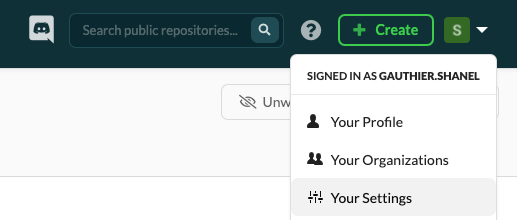

Then, you need to clik on -> Tokens and copy your token

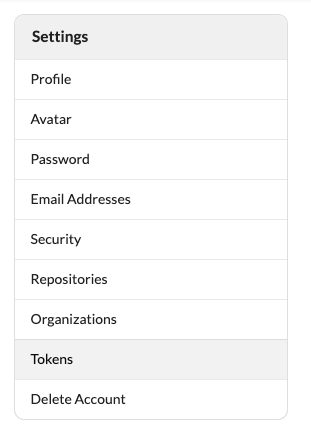

**Set Environment Variables**


In [2]:
#@title Enter the repository name for the project:

REPO_NAME= "skin_disease" #@param {type:"string"}

In [3]:
#@title Enter the repository name for the project:

REPO_OWNER= "gauthier.shanel" #@param {type:"string"}

** Please make sure to change "gauthier.shanel" for YOUR user name in DAGsHub**

In [4]:
#@title Enter the username of your DAGsHub account:

USER_NAME = "gauthier.shanel" #@param {type:"string"}

**Set Local Configurations**

Under the [Token tab](https://dagshub.com/user/settings/tokens) in the user setting, copy the default token and use it here.

In [5]:
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

Enter your DAGsHub access token or password:  ········································


# 2. Create Pytorch Dataset

In this section, we create the pytorch dataset and dataloader.

In [7]:
#Settings and hyperparamerters for this experiment
workers = 4
batch_size=16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Create Dataset
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))

In the dataset, we normalize the images by the mean and std per channel. Below, you can see how we computed the mean and std per channel.

Mean: [0.6475, 0.4907, 0.4165]
std: [0.1875, 0.1598, 0.1460]

In [9]:
# code from: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def get_mean_std_per_channel(loader):
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages
    return mean, std
# create dataloader
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
get_mean_std_per_channel(loader)

(tensor([-3.0636e-05,  1.2784e-04, -9.0759e-05]),
 tensor([1.0036, 1.0057, 1.0070]))

# 3. Hyperparameter Search

In this section, we consider 4 different architectures: vanilla cnn, pretrained resnet50, big tranfer model from this [paper](https://arxiv.org/abs/1912.11370) and parametric scattering network from this [paper](https://arxiv.org/abs/2107.09539).

For each architecture, we do a simple hyperparameter search.

The next cell allows you to visualize the results from DAGsHub. 
Make sure you followed the instruction of section 1. 



In [9]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))

## 3.1 Vanilla CNN

In [12]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-3, 1e-4)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 18, 'lr': 0.0006000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:14.83497562011083, Test Loss: 20.602964401245117
Epoch 2-- Train Loss:23.964456001917522, Test Loss: 24.20540428161621
Epoch 3-- Train Loss:11.12871960798899, Test Loss: 7.205683708190918
Epoch 4-- Train Loss:2.6986592113970005, Test Loss: 3.7977356910705566
Epoch 5-- Train Loss:3.8727974891662598, Test Loss: 29.49567985534668
Epoch 6-- Train Loss:12.071016589800516, Test Loss: 16.990989685058594
Epoch 7-- Train Loss:4.541417578856151, Test Loss: 52.698883056640625
Epoch 8-- Train Loss:12.521948854119424, Test Loss: 0.24940113723278046
Epoch 9-- Train Loss:1.422837754090627, Test Loss: 17.476686477661133
Epoch 10-- Train Loss:1.1547197198494057, Test Loss: 3.050602436065674
Epoch 11-- Train Loss:1.1525965892360546, Test Loss: 2.174943208694458
Epoch 12-- Train Loss:0.46754601285404834, Test Loss: 3.6261534690856934
Epoch 13-- Train Loss:6.380407337409754, Test 

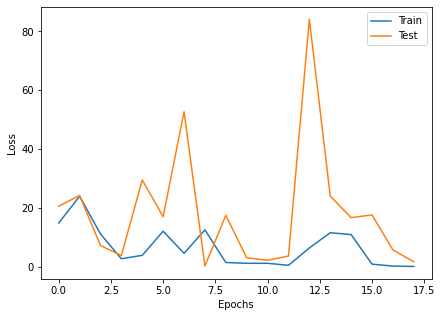

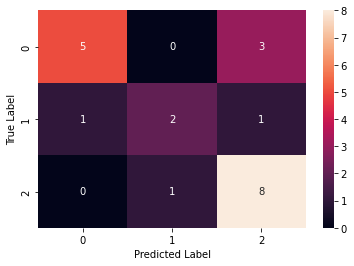

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.576192915439606, Test Loss: 42.92252731323242
Epoch 2-- Train Loss:15.71370538075765, Test Loss: 23.08866310119629
Epoch 3-- Train Loss:24.237290223439533, Test Loss: 16.89044761657715
Epoch 4-- Train Loss:13.832703431447348, Test Loss: 24.427066802978516
Epoch 5-- Train Loss:5.738704641660054, Test Loss: 14.695231437683105
Epoch 6-- Train Loss:2.7879174252351127, Test Loss: 4.6819634437561035
Epoch 7-- Train Loss:1.568098021428644, Test Loss: 6.257899761199951
Epoch 8-- Train Loss:0.31802403274923563, Test Loss: 0.5110155344009399
Epoch 9-- Train Loss:0.42483106985067326, Test Loss: 1.2975348234176636
Epoch 10-- Train Loss:2.193865768611431, Test Loss: 37.38546371459961
Epoch 11-- Train Loss:14.251225739717484, Test Loss: 0.22693148255348206
Epoch 12-- Train Loss:0.5239329139391581, Test Loss: 4.03952169418335
Epoch 13-- Train Loss:0.49246234943469364, Test Loss: 8.113544464111328
Epoch 14-- Train Loss:0.

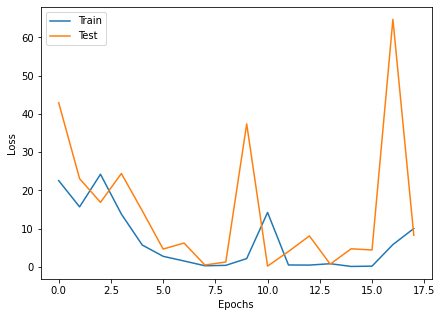

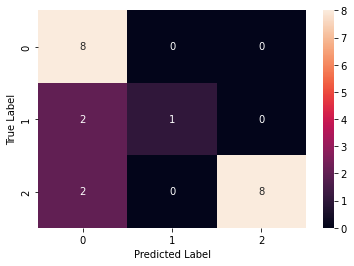

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:23.527909954388935, Test Loss: 70.15656280517578
Epoch 2-- Train Loss:20.57497163613637, Test Loss: 29.946002960205078
Epoch 3-- Train Loss:11.619932174682617, Test Loss: 1.2027069330215454
Epoch 4-- Train Loss:11.499897142251333, Test Loss: 34.22471618652344
Epoch 5-- Train Loss:6.815811527272065, Test Loss: 6.2824907302856445
Epoch 6-- Train Loss:2.2796107303972044, Test Loss: 1.1815348863601685
Epoch 7-- Train Loss:2.544737145411394, Test Loss: 10.443262100219727
Epoch 8-- Train Loss:1.1634993313540083, Test Loss: 4.218282222747803
Epoch 9-- Train Loss:0.9916671266158422, Test Loss: 14.259482383728027
Epoch 10-- Train Loss:2.309330117267867, Test Loss: 0.25594496726989746
Epoch 11-- Train Loss:1.6971495943143964, Test Loss: 39.59164047241211
Epoch 12-- Train Loss:5.590722649523134, Test Loss: 3.5649967193603516
Epoch 13-- Train Loss:0.4833354279398918, Test Loss: 20.39670753479004
Epoch 14-- Train Loss:1.4

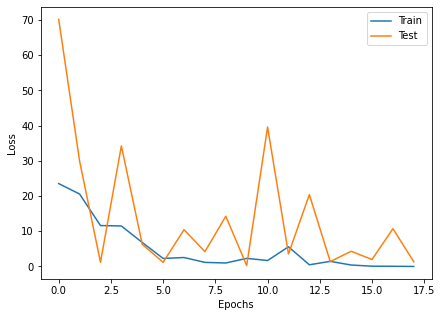

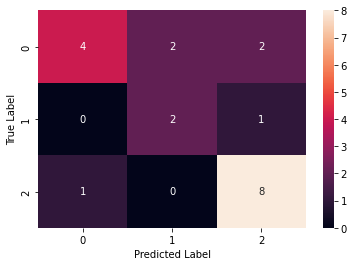

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.995556076367695, Test Loss: 33.69646072387695
Epoch 2-- Train Loss:26.840409358342487, Test Loss: 71.082763671875
Epoch 3-- Train Loss:12.50273863474528, Test Loss: 30.458890914916992
Epoch 4-- Train Loss:15.519630710283915, Test Loss: 32.35808181762695
Epoch 5-- Train Loss:18.913035710652668, Test Loss: 14.2379150390625
Epoch 6-- Train Loss:9.39051990287991, Test Loss: 3.473371744155884
Epoch 7-- Train Loss:2.6546814780061445, Test Loss: 5.020379543304443
Epoch 8-- Train Loss:3.499921315393294, Test Loss: 3.587583541870117
Epoch 9-- Train Loss:1.1057101152837276, Test Loss: 4.395010471343994
Epoch 10-- Train Loss:0.7531687002859447, Test Loss: 3.1509900093078613
Epoch 11-- Train Loss:0.36747296285951353, Test Loss: 1.6179288625717163
Epoch 12-- Train Loss:0.24813174842468774, Test Loss: 0.4279630482196808
Epoch 13-- Train Loss:0.21032395364682088, Test Loss: 0.0006503741024062037
Epoch 14-- Train Loss:0.0

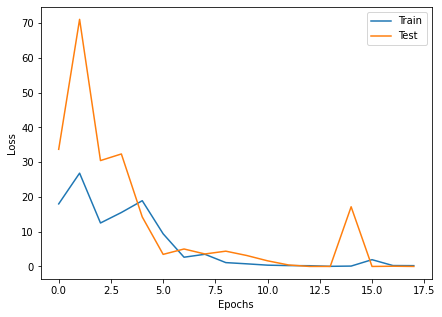

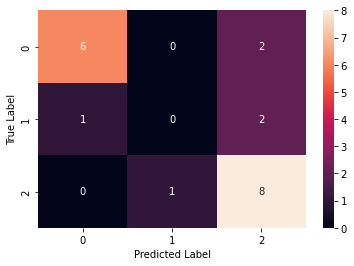

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:15.131161669890085, Test Loss: 0.0
Epoch 2-- Train Loss:15.995742221097336, Test Loss: 15.335518836975098
Epoch 3-- Train Loss:7.769476100802422, Test Loss: 11.49760627746582
Epoch 4-- Train Loss:5.7584832310676575, Test Loss: 25.225862503051758
Epoch 5-- Train Loss:3.6691076954205832, Test Loss: 23.42190933227539
Epoch 6-- Train Loss:6.450722733267715, Test Loss: 3.2758939266204834
Epoch 7-- Train Loss:1.4478254394475887, Test Loss: 13.596173286437988
Epoch 8-- Train Loss:0.8581065436204275, Test Loss: 24.84503936767578
Epoch 9-- Train Loss:0.11911176015322174, Test Loss: 0.021298419684171677
Epoch 10-- Train Loss:0.0957187623619878, Test Loss: 6.868587970733643
Epoch 11-- Train Loss:0.14863650247768115, Test Loss: 9.10596752166748
Epoch 12-- Train Loss:0.07110110257250568, Test Loss: 27.416900634765625
Epoch 13-- Train Loss:0.04488876857794762, Test Loss: 9.00124740600586
Epoch 14-- Train Loss:0.00665216624

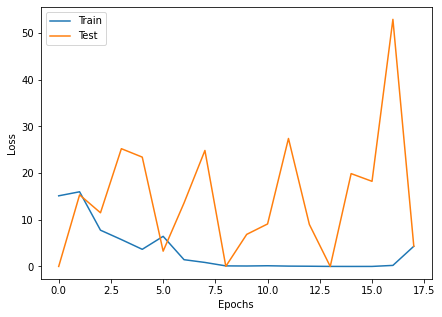

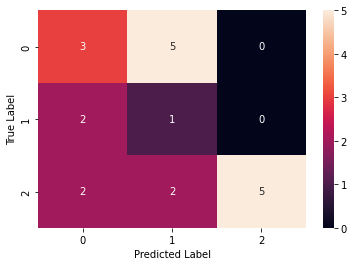

Starting testing
Training Complete
{'0': {'f1-score': '0.671±0.113',
       'precision': '0.751±0.216',
       'recall': '0.65±0.146',
       'support': 8},
 '1': {'f1-score': '0.401±0.129',
       'precision': '0.529±0.273',
       'recall': '0.383±0.145',
       'support': 4},
 '2': {'f1-score': '0.761±0.033',
       'precision': '0.805±0.159',
       'recall': '0.787±0.176',
       'support': 9},
 'accuracy': '0.667±0.097',
 'macro avg': {'f1-score': '0.611±0.085',
               'precision': '0.695±0.117',
               'recall': '0.607±0.084',
               'support': 21},
 'weighted avg': {'f1-score': '0.669±0.076',
                  'precision': '0.743±0.075',
                  'recall': '0.667±0.097',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0001, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:5.434096500233171, Test Loss: 2.3706343173980713
Epoch 2-- Train Loss:2.0836130284393826, Test Loss: 1.311301275563892e-06
Epoch 3-- T

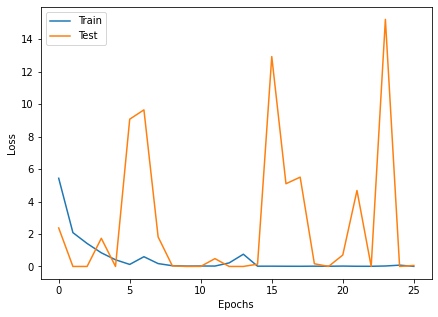

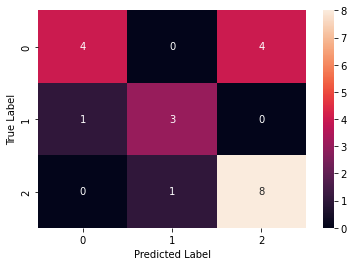

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.565731181630066, Test Loss: 0.0015906550688669086
Epoch 2-- Train Loss:3.3382297330314206, Test Loss: 0.0075643532909452915
Epoch 3-- Train Loss:1.197145220083517, Test Loss: 5.831211090087891
Epoch 4-- Train Loss:0.7058068399450609, Test Loss: 0.00400099391117692
Epoch 5-- Train Loss:0.15741300726776467, Test Loss: 0.00031585473334416747
Epoch 6-- Train Loss:0.3246451542869354, Test Loss: 7.748303323751315e-05
Epoch 7-- Train Loss:0.25374519586746047, Test Loss: 0.04877592623233795
Epoch 8-- Train Loss:0.09660421868691282, Test Loss: 0.0026291587855666876
Epoch 9-- Train Loss:0.04449514368094415, Test Loss: 0.09553147107362747
Epoch 10-- Train Loss:0.01652241304483531, Test Loss: 0.0007108307327143848
Epoch 11-- Train Loss:0.029123964833464317, Test Loss: 0.12602591514587402
Epoch 12-- Train Loss:0.02494369542996754, Test Loss: 0.0012738931691274047
Epoch 13-- Train Loss:0.016402278849065106, Test Loss: 0.

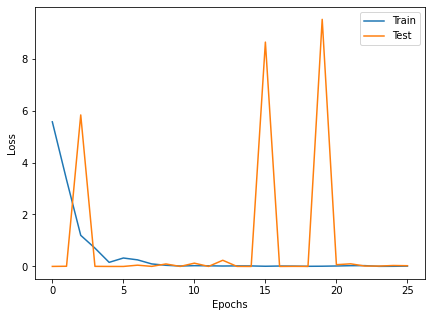

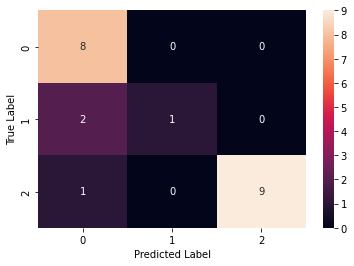

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.940126311211078, Test Loss: 17.62938690185547
Epoch 2-- Train Loss:3.0320258961430575, Test Loss: 2.523991584777832
Epoch 3-- Train Loss:0.859642367178042, Test Loss: 1.5480892658233643
Epoch 4-- Train Loss:1.3449126002725236, Test Loss: 1.7535548210144043
Epoch 5-- Train Loss:0.8061715047224425, Test Loss: 0.00021962517348583788
Epoch 6-- Train Loss:0.35555511791469707, Test Loss: 1.1138737201690674
Epoch 7-- Train Loss:0.4533610153275298, Test Loss: 0.2783510088920593
Epoch 8-- Train Loss:0.024329992541814654, Test Loss: 1.5503103733062744
Epoch 9-- Train Loss:0.04376048561902107, Test Loss: 0.1999194175004959
Epoch 10-- Train Loss:0.04916966374202318, Test Loss: 1.463464617729187
Epoch 11-- Train Loss:0.037868378868941885, Test Loss: 0.004213558044284582
Epoch 12-- Train Loss:0.03436747489052193, Test Loss: 0.0007061108481138945
Epoch 13-- Train Loss:0.026922091381579992, Test Loss: 0.2704322040081024
Ep

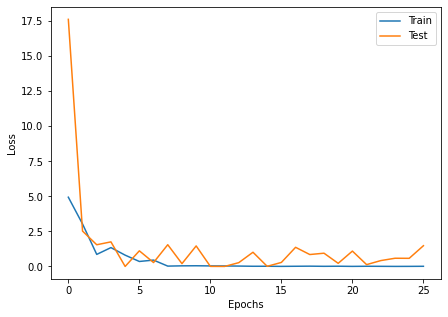

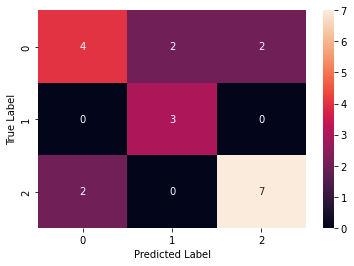

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.880289125434328, Test Loss: 9.766251564025879
Epoch 2-- Train Loss:1.700307182346781, Test Loss: 0.04680273309350014
Epoch 3-- Train Loss:1.2249268902731794, Test Loss: 2.140839099884033
Epoch 4-- Train Loss:1.4931093826889992, Test Loss: 1.3906644582748413
Epoch 5-- Train Loss:0.9460143559762011, Test Loss: 2.5886123180389404
Epoch 6-- Train Loss:0.2954378156545794, Test Loss: 0.663447916507721
Epoch 7-- Train Loss:0.21108703439330428, Test Loss: 0.1103866696357727
Epoch 8-- Train Loss:0.23752465235338605, Test Loss: 0.024443967267870903
Epoch 9-- Train Loss:0.03645667736704387, Test Loss: 0.21506433188915253
Epoch 10-- Train Loss:0.019386006029630413, Test Loss: 0.03461645543575287
Epoch 11-- Train Loss:0.027659081249112205, Test Loss: 0.04417983442544937
Epoch 12-- Train Loss:0.018373001967445037, Test Loss: 0.7053921222686768
Epoch 13-- Train Loss:0.011322037657789354, Test Loss: 0.08261307328939438
Epo

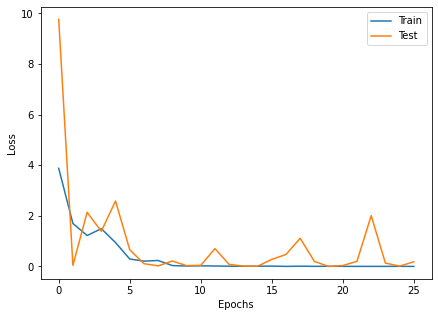

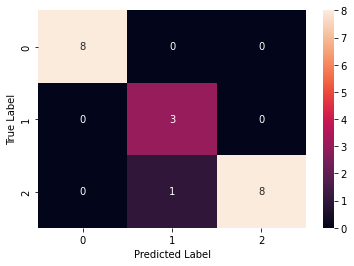

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.2499080016121815, Test Loss: 2.1373393535614014
Epoch 2-- Train Loss:2.0358290442354265, Test Loss: 5.694689750671387
Epoch 3-- Train Loss:1.5521854752940791, Test Loss: 3.9943454265594482
Epoch 4-- Train Loss:0.3278725197638518, Test Loss: 3.0468244552612305
Epoch 5-- Train Loss:0.3756722134733406, Test Loss: 2.00480580329895
Epoch 6-- Train Loss:0.3237206318091402, Test Loss: 1.3495959043502808
Epoch 7-- Train Loss:0.06625886582506132, Test Loss: 0.3869105577468872
Epoch 8-- Train Loss:0.23265636064622544, Test Loss: 0.46974220871925354
Epoch 9-- Train Loss:0.02442192534259188, Test Loss: 0.3676738142967224
Epoch 10-- Train Loss:0.029299851890148904, Test Loss: 2.693638801574707
Epoch 11-- Train Loss:0.036788254775317566, Test Loss: 1.218961238861084
Epoch 12-- Train Loss:0.025287808557983397, Test Loss: 4.395337104797363
Epoch 13-- Train Loss:0.016603595367909986, Test Loss: 0.00661975285038352
Epoch 14-

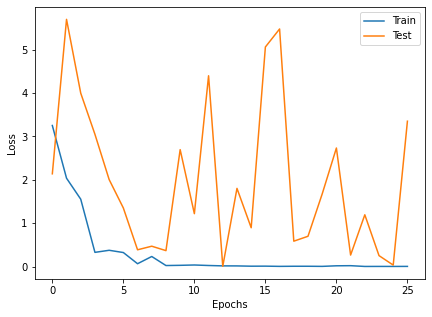

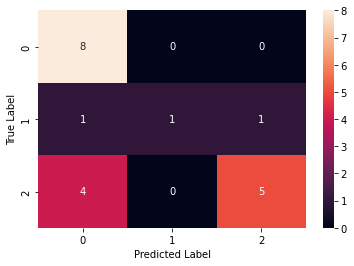

Starting testing
Training Complete
{'0': {'f1-score': '0.73±0.145',
       'precision': '0.734±0.16',
       'recall': '0.775±0.229',
       'support': 8},
 '1': {'f1-score': '0.614±0.337',
       'precision': '0.7±0.367',
       'recall': '0.617±0.393',
       'support': 4},
 '2': {'f1-score': '0.798±0.114',
       'precision': '0.816±0.124',
       'recall': '0.802±0.165',
       'support': 9},
 'accuracy': '0.764±0.103',
 'macro avg': {'f1-score': '0.714±0.141',
               'precision': '0.75±0.165',
               'recall': '0.731±0.128',
               'support': 21},
 'weighted avg': {'f1-score': '0.745±0.117',
                  'precision': '0.769±0.127',
                  'recall': '0.764±0.103',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0007000000000000001, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.81275433843786, Test Loss: 14.851936340332031
Epoch 2-- Train Loss:11.161917729811234, Test Loss: 13.595778465270996
Epo

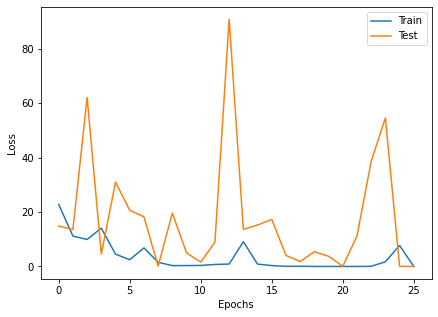

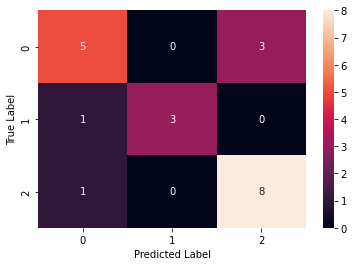

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:19.310629801316693, Test Loss: 1.6219122409820557
Epoch 2-- Train Loss:13.173426368358461, Test Loss: 24.02875518798828
Epoch 3-- Train Loss:11.826947588367727, Test Loss: 8.863362312316895
Epoch 4-- Train Loss:5.284485654397444, Test Loss: 6.787484645843506
Epoch 5-- Train Loss:4.052818055518649, Test Loss: 11.156764030456543
Epoch 6-- Train Loss:2.403472556901926, Test Loss: 0.6564351320266724
Epoch 7-- Train Loss:1.2035850281645666, Test Loss: 12.718863487243652
Epoch 8-- Train Loss:0.3990386274689089, Test Loss: 0.4142172336578369
Epoch 9-- Train Loss:0.3259879518848482, Test Loss: 16.81661605834961
Epoch 10-- Train Loss:0.3723427221085461, Test Loss: 11.149901390075684
Epoch 11-- Train Loss:2.00676780364963, Test Loss: 0.003120279172435403
Epoch 12-- Train Loss:1.0476916413571111, Test Loss: 0.5966852903366089
Epoch 13-- Train Loss:0.031010701733884295, Test Loss: 14.737385749816895
Epoch 14-- Train Loss

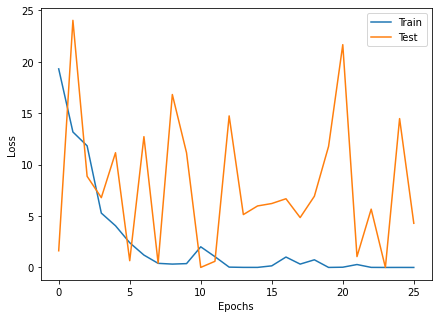

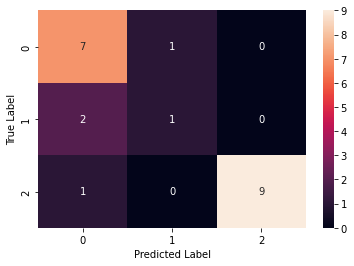

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.771355162967335, Test Loss: 25.13228988647461
Epoch 2-- Train Loss:22.63544463478452, Test Loss: 8.167078971862793
Epoch 3-- Train Loss:3.157989222524603, Test Loss: 5.269038200378418
Epoch 4-- Train Loss:6.068696749481288, Test Loss: 11.544976234436035
Epoch 5-- Train Loss:7.595675327561119, Test Loss: 26.03386688232422
Epoch 6-- Train Loss:7.3563387243279355, Test Loss: 3.7869150638580322
Epoch 7-- Train Loss:1.8557506762616531, Test Loss: 0.38354262709617615
Epoch 8-- Train Loss:0.7941468290512096, Test Loss: 21.404090881347656
Epoch 9-- Train Loss:1.730744562684177, Test Loss: 0.011679603718221188
Epoch 10-- Train Loss:0.10799709903573416, Test Loss: 3.6730148792266846
Epoch 11-- Train Loss:0.6922329174670714, Test Loss: 2.533575207053218e-05
Epoch 12-- Train Loss:0.7379905422767944, Test Loss: 0.0
Epoch 13-- Train Loss:0.01560132085447014, Test Loss: 3.900759696960449
Epoch 14-- Train Loss:0.311770921

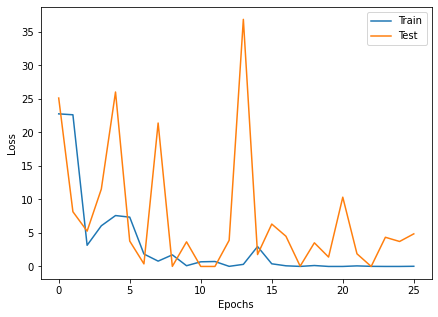

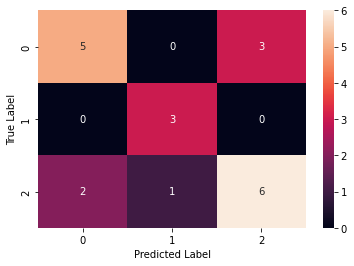

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:14.198468381708318, Test Loss: 16.564294815063477
Epoch 2-- Train Loss:8.711349178665676, Test Loss: 16.15514373779297
Epoch 3-- Train Loss:13.197261875325983, Test Loss: 6.387543678283691
Epoch 4-- Train Loss:10.984893514244256, Test Loss: 18.70136260986328
Epoch 5-- Train Loss:11.442410268566825, Test Loss: 31.13215446472168
Epoch 6-- Train Loss:5.2093593862770255, Test Loss: 11.387978553771973
Epoch 7-- Train Loss:1.0057751570514022, Test Loss: 6.839578628540039
Epoch 8-- Train Loss:2.3336396193353206, Test Loss: 26.704376220703125
Epoch 9-- Train Loss:1.6115474142302033, Test Loss: 2.5755743990885094e-06
Epoch 10-- Train Loss:0.2266093096891795, Test Loss: 0.005449254065752029
Epoch 11-- Train Loss:0.19961281081351656, Test Loss: 7.4081349339394365e-06
Epoch 12-- Train Loss:0.13225633562443628, Test Loss: 6.3784637451171875
Epoch 13-- Train Loss:0.2438439203592802, Test Loss: 19.535335540771484
Epoch 14--

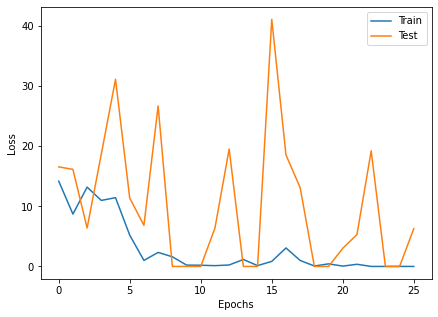

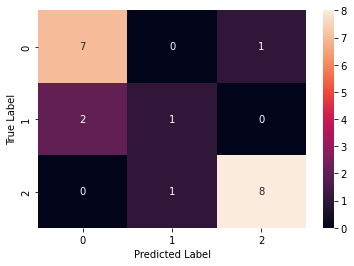

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:23.214471751993354, Test Loss: 13.105443954467773
Epoch 2-- Train Loss:9.526900537989356, Test Loss: 51.6890983581543
Epoch 3-- Train Loss:10.091504833915018, Test Loss: 19.268823623657227
Epoch 4-- Train Loss:3.036816796118563, Test Loss: 73.6788330078125
Epoch 5-- Train Loss:7.560777237794983, Test Loss: 13.079243659973145
Epoch 6-- Train Loss:3.318051171778026, Test Loss: 4.870923042297363
Epoch 7-- Train Loss:0.7724543448057601, Test Loss: 14.740324974060059
Epoch 8-- Train Loss:1.6351664508269592, Test Loss: 1.2605160474777222
Epoch 9-- Train Loss:4.33381559361111, Test Loss: 4.692018032073975
Epoch 10-- Train Loss:0.18800543892373092, Test Loss: 16.848886489868164
Epoch 11-- Train Loss:0.30229047634741785, Test Loss: 3.128079414367676
Epoch 12-- Train Loss:0.11794287681029586, Test Loss: 29.654600143432617
Epoch 13-- Train Loss:0.024512562138109848, Test Loss: 5.5285461542098346e-08
Epoch 14-- Train Los

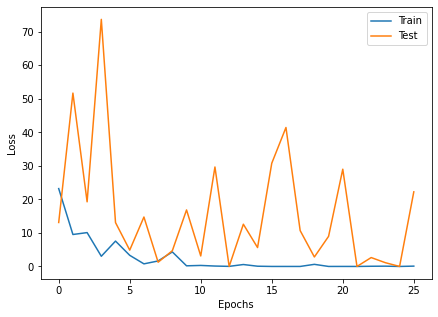

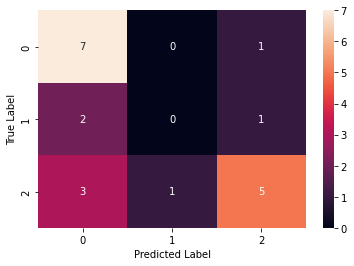

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.108',
       'precision': '0.685±0.054',
       'recall': '0.75±0.209',
       'support': 8},
 '1': {'f1-score': '0.503±0.324',
       'precision': '0.55±0.332',
       'recall': '0.483±0.351',
       'support': 4},
 '2': {'f1-score': '0.779±0.123',
       'precision': '0.798±0.146',
       'recall': '0.78±0.142',
       'support': 9},
 'accuracy': '0.725±0.069',
 'macro avg': {'f1-score': '0.661±0.093',
               'precision': '0.678±0.103',
               'recall': '0.671±0.077',
               'support': 21},
 'weighted avg': {'f1-score': '0.71±0.079',
                  'precision': '0.72±0.075',
                  'recall': '0.725±0.069',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:17.08117268482844, Test Loss: 23.533405303955078
Epoch 2-- Train Loss:19.376420656840008, Test Loss: 13.70435905456543
Epo

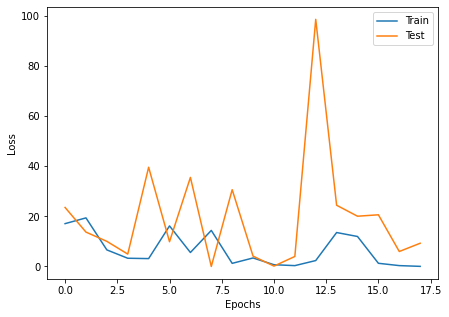

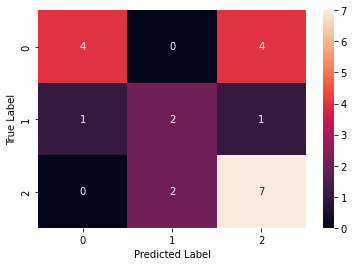

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:25.94160681962967, Test Loss: 48.68276596069336
Epoch 2-- Train Loss:18.23030153910319, Test Loss: 25.216947555541992
Epoch 3-- Train Loss:21.55200469493866, Test Loss: 21.893407821655273
Epoch 4-- Train Loss:18.535629908243816, Test Loss: 33.729209899902344
Epoch 5-- Train Loss:6.437748114267985, Test Loss: 17.46828842163086
Epoch 6-- Train Loss:2.7430567940076194, Test Loss: 7.877059459686279
Epoch 7-- Train Loss:2.440691277384758, Test Loss: 10.665400505065918
Epoch 8-- Train Loss:2.2104099839925766, Test Loss: 0.03930874168872833
Epoch 9-- Train Loss:0.2769340851000379, Test Loss: 2.8299384117126465
Epoch 10-- Train Loss:2.0286681552339965, Test Loss: 41.44314193725586
Epoch 11-- Train Loss:14.84067408243815, Test Loss: 0.005765122827142477
Epoch 12-- Train Loss:0.5932459160685539, Test Loss: 4.920825481414795
Epoch 13-- Train Loss:0.3603244076136889, Test Loss: 7.789449691772461
Epoch 14-- Train Loss:0.5

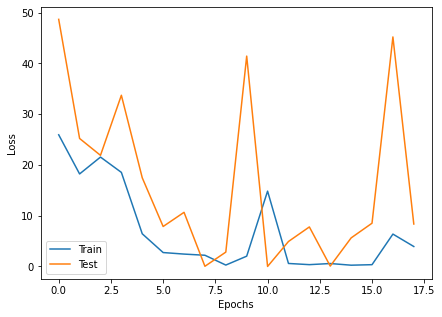

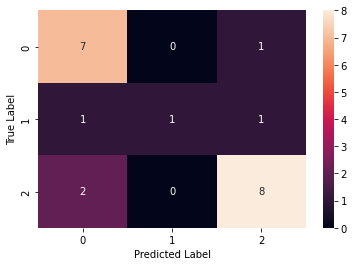

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:26.888345917065937, Test Loss: 78.03092193603516
Epoch 2-- Train Loss:22.956286549568176, Test Loss: 34.45304489135742
Epoch 3-- Train Loss:13.992546558380127, Test Loss: 5.147427082061768
Epoch 4-- Train Loss:16.101831912994385, Test Loss: 35.08517837524414
Epoch 5-- Train Loss:12.598899702231089, Test Loss: 23.22519874572754
Epoch 6-- Train Loss:8.590551495552063, Test Loss: 26.40656852722168
Epoch 7-- Train Loss:10.86738563157894, Test Loss: 16.531326293945312
Epoch 8-- Train Loss:4.376152687159522, Test Loss: 4.28563117980957
Epoch 9-- Train Loss:0.8562851262589296, Test Loss: 9.228754997253418
Epoch 10-- Train Loss:5.305767297744751, Test Loss: 19.306726455688477
Epoch 11-- Train Loss:2.6659273778398833, Test Loss: 36.25355529785156
Epoch 12-- Train Loss:4.835556425134655, Test Loss: 1.9473230838775635
Epoch 13-- Train Loss:0.2617940669207428, Test Loss: 3.786576986312866
Epoch 14-- Train Loss:0.45263441

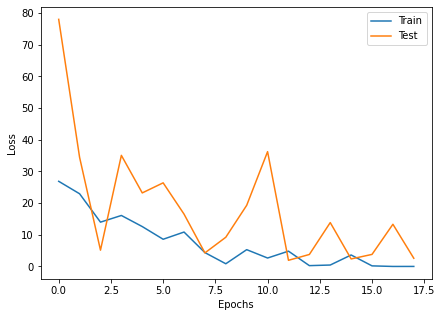

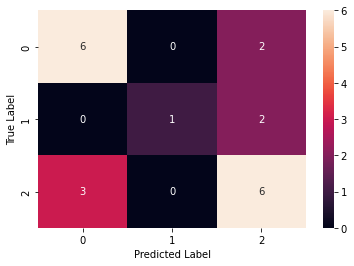

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:20.58783503373464, Test Loss: 39.224605560302734
Epoch 2-- Train Loss:30.03880039850871, Test Loss: 86.39058685302734
Epoch 3-- Train Loss:17.58573325475057, Test Loss: 33.52543640136719
Epoch 4-- Train Loss:14.126523534456888, Test Loss: 36.182743072509766
Epoch 5-- Train Loss:25.932143370310467, Test Loss: 15.065438270568848
Epoch 6-- Train Loss:9.535974462827047, Test Loss: 4.500993728637695
Epoch 7-- Train Loss:1.6636032462120056, Test Loss: 1.904711365699768
Epoch 8-- Train Loss:3.423779025518646, Test Loss: 3.6225123405456543
Epoch 9-- Train Loss:1.3070030250310083, Test Loss: 2.3507566452026367
Epoch 10-- Train Loss:0.7698474352558454, Test Loss: 0.7654411196708679
Epoch 11-- Train Loss:0.6175520902930126, Test Loss: 1.1678569316864014
Epoch 12-- Train Loss:0.5817482411606155, Test Loss: 24.064149856567383
Epoch 13-- Train Loss:2.349023523286936, Test Loss: 32.397727966308594
Epoch 14-- Train Loss:7.27

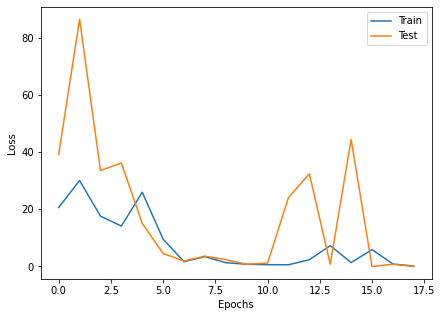

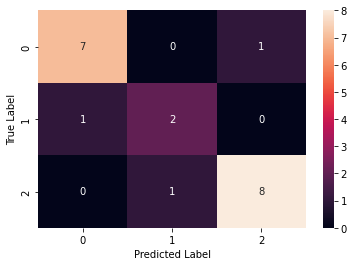

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:17.568267186482746, Test Loss: 0.0
Epoch 2-- Train Loss:14.272380113601685, Test Loss: 27.14473533630371
Epoch 3-- Train Loss:9.69626717052112, Test Loss: 4.842234134674072
Epoch 4-- Train Loss:3.351365089416504, Test Loss: 65.75961303710938
Epoch 5-- Train Loss:18.73086444536845, Test Loss: 25.887540817260742
Epoch 6-- Train Loss:6.715407793575953, Test Loss: 0.11151491105556488
Epoch 7-- Train Loss:1.779951345675272, Test Loss: 16.66236114501953
Epoch 8-- Train Loss:0.6438094675540924, Test Loss: 36.391998291015625
Epoch 9-- Train Loss:0.3277437225721466, Test Loss: 0.010938315652310848
Epoch 10-- Train Loss:0.16921274608466774, Test Loss: 10.593913078308105
Epoch 11-- Train Loss:0.08061087884319325, Test Loss: 21.288408279418945
Epoch 12-- Train Loss:0.5356397857928338, Test Loss: 39.70759963989258
Epoch 13-- Train Loss:0.14284992446331066, Test Loss: 8.837084770202637
Epoch 14-- Train Loss:0.0076712758436

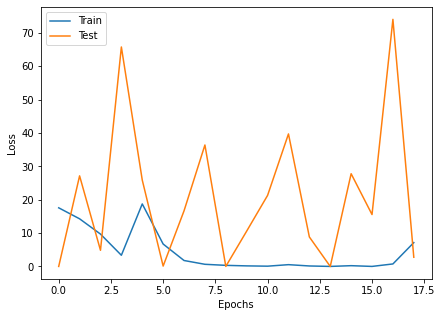

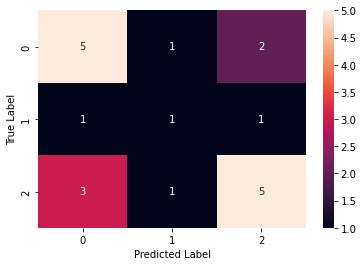

Starting testing
Training Complete
{'0': {'f1-score': '0.614±0.181',
       'precision': '0.612±0.144',
       'recall': '0.625±0.224',
       'support': 8},
 '1': {'f1-score': '0.313±0.218',
       'precision': '0.323±0.234',
       'recall': '0.317±0.213',
       'support': 4},
 '2': {'f1-score': '0.731±0.119',
       'precision': '0.733±0.166',
       'recall': '0.74±0.085',
       'support': 9},
 'accuracy': '0.628±0.148',
 'macro avg': {'f1-score': '0.553±0.168',
               'precision': '0.556±0.175',
               'recall': '0.561±0.16',
               'support': 21},
 'weighted avg': {'f1-score': '0.62±0.156',
                  'precision': '0.622±0.164',
                  'recall': '0.628±0.148',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0008, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:27.370760321617126, Test Loss: 32.71680450439453
Epoch 2-- Train Loss:11.915194294669412, Test Loss: 7.696902275085449
Epoch 3-- Train L

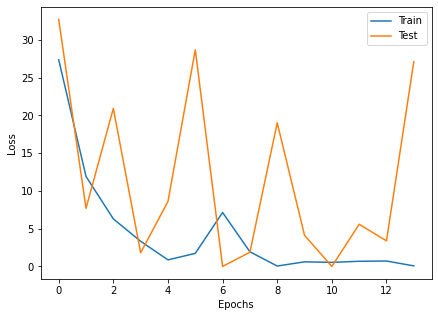

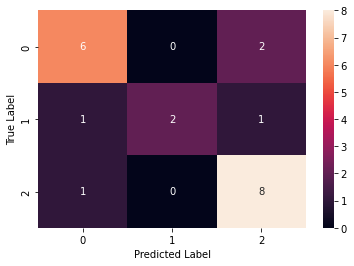

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:22.51239853555506, Test Loss: 26.804832458496094
Epoch 2-- Train Loss:14.849236141551625, Test Loss: 107.55430603027344
Epoch 3-- Train Loss:18.165345647118308, Test Loss: 5.898932456970215
Epoch 4-- Train Loss:2.6665726862847805, Test Loss: 25.3705997467041
Epoch 5-- Train Loss:4.948985197327354, Test Loss: 36.57582473754883
Epoch 6-- Train Loss:9.234738863327287, Test Loss: 13.172436714172363
Epoch 7-- Train Loss:2.2683120323723744, Test Loss: 7.089029312133789
Epoch 8-- Train Loss:0.44572494316492917, Test Loss: 1.1694719791412354
Epoch 9-- Train Loss:0.5751635575911936, Test Loss: 8.258698463439941
Epoch 10-- Train Loss:0.4729079912548183, Test Loss: 2.058015823364258
Epoch 11-- Train Loss:0.7272431864711725, Test Loss: 6.4952192306518555
Epoch 12-- Train Loss:0.6438522550557686, Test Loss: 0.0
Epoch 13-- Train Loss:0.09897930194269251, Test Loss: 2.4243216514587402
Epoch 14-- Train Loss:0.139183737221314

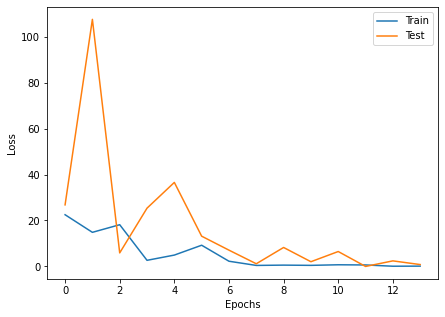

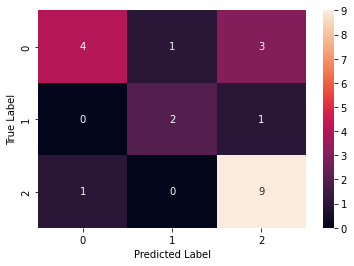

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:22.087477109648965, Test Loss: 37.80642318725586
Epoch 2-- Train Loss:16.397154549136758, Test Loss: 17.9265079498291
Epoch 3-- Train Loss:9.20434713916091, Test Loss: 9.308344841003418
Epoch 4-- Train Loss:4.354276359081268, Test Loss: 8.417181015014648
Epoch 5-- Train Loss:2.7298121318389432, Test Loss: 16.67641830444336
Epoch 6-- Train Loss:5.243318118801519, Test Loss: 6.4753031730651855
Epoch 7-- Train Loss:1.5259591860151638, Test Loss: 1.662113904953003
Epoch 8-- Train Loss:3.0766205983959067, Test Loss: 0.0
Epoch 9-- Train Loss:3.4157549316278657, Test Loss: 1.3179892301559448
Epoch 10-- Train Loss:1.0935040388974977, Test Loss: 21.0550479888916
Epoch 11-- Train Loss:3.9953855082714487, Test Loss: 7.286447048187256
Epoch 12-- Train Loss:1.3266620126503932, Test Loss: 5.194606304168701
Epoch 13-- Train Loss:0.0848198661253796, Test Loss: 0.011659127660095692
Epoch 14-- Train Loss:1.0771341475756757, Te

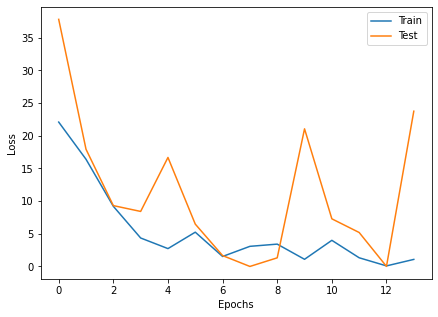

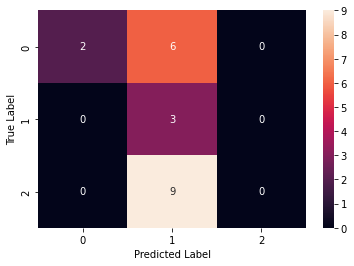

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:21.49950035051866, Test Loss: 126.0076904296875
Epoch 2-- Train Loss:26.784501162442293, Test Loss: 95.7547607421875
Epoch 3-- Train Loss:21.83338900587775, Test Loss: 2.3587536811828613
Epoch 4-- Train Loss:8.520265224982392, Test Loss: 55.22544860839844
Epoch 5-- Train Loss:10.520527021366764, Test Loss: 7.963538646697998
Epoch 6-- Train Loss:8.042849652651057, Test Loss: 10.404261589050293
Epoch 7-- Train Loss:4.378562254946536, Test Loss: 3.387173652648926
Epoch 8-- Train Loss:1.3739385749774804, Test Loss: 0.10180430114269257
Epoch 9-- Train Loss:1.5668234633400986, Test Loss: 30.380348205566406
Epoch 10-- Train Loss:1.2917883622242499, Test Loss: 12.040501594543457
Epoch 11-- Train Loss:0.45965562040560765, Test Loss: 1.690215867711231e-05
Epoch 12-- Train Loss:0.15735638669423685, Test Loss: 0.0022840688470751047
Epoch 13-- Train Loss:0.1419839967485073, Test Loss: 7.186026096343994
Epoch 14-- Train Lo

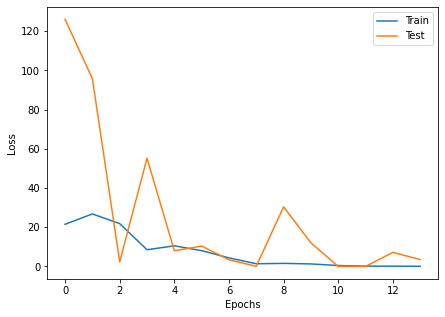

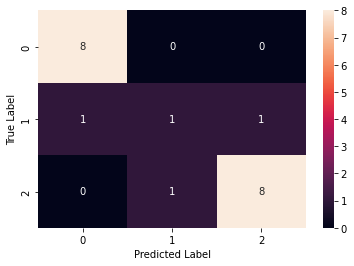

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:14.025893135504289, Test Loss: 40.83993911743164
Epoch 2-- Train Loss:15.142958272587169, Test Loss: 48.61009979248047
Epoch 3-- Train Loss:9.347690163169649, Test Loss: 19.81572723388672
Epoch 4-- Train Loss:3.7022790957072917, Test Loss: 10.917143821716309
Epoch 5-- Train Loss:4.406172166477042, Test Loss: 25.581031799316406
Epoch 6-- Train Loss:5.898808465906603, Test Loss: 1.607177972793579
Epoch 7-- Train Loss:6.060204291755165, Test Loss: 0.14888592064380646
Epoch 8-- Train Loss:2.292091027922032, Test Loss: 6.316395282745361
Epoch 9-- Train Loss:0.7319051093760539, Test Loss: 57.93919372558594
Epoch 10-- Train Loss:1.1861323554634593, Test Loss: 12.960517883300781
Epoch 11-- Train Loss:0.012035351353203034, Test Loss: 10.82888126373291
Epoch 12-- Train Loss:1.2194594788830024e-05, Test Loss: 30.792049407958984
Epoch 13-- Train Loss:4.136162640138769e-05, Test Loss: 7.7468791007995605
Epoch 14-- Train L

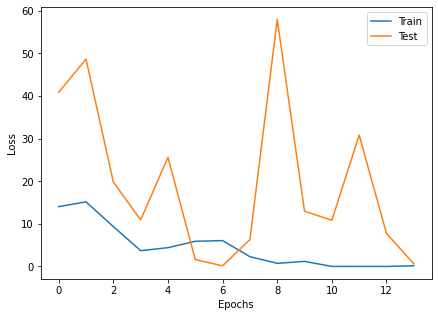

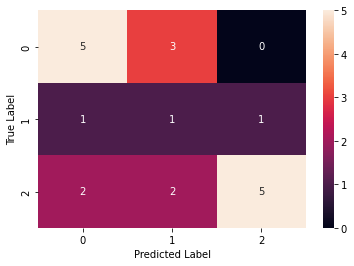

Starting testing
Training Complete
{'0': {'f1-score': '0.701±0.183',
       'precision': '0.859±0.085',
       'recall': '0.65±0.255',
       'support': 8},
 '1': {'f1-score': '0.42±0.151',
       'precision': '0.407±0.193',
       'recall': '0.567±0.249',
       'support': 4},
 '2': {'f1-score': '0.674±0.344',
       'precision': '0.668±0.342',
       'recall': '0.691±0.362',
       'support': 9},
 'accuracy': '0.655±0.214',
 'macro avg': {'f1-score': '0.599±0.194',
               'precision': '0.645±0.14',
               'recall': '0.636±0.125',
               'support': 21},
 'weighted avg': {'f1-score': '0.645±0.229',
                  'precision': '0.702±0.145',
                  'recall': '0.655±0.214',
                  'support': 21}}
{'num_epochs': 6, 'lr': 0.0009000000000000001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:21.37077711025874, Test Loss: 29.344465255737305
Epoch 2-- Train Loss:22.703934987386067, Test Loss: 21.416288375854492
E

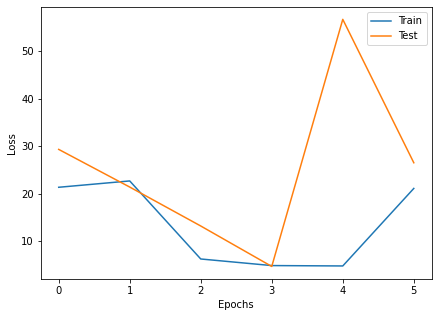

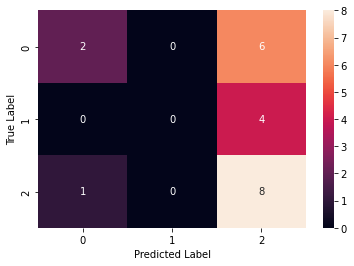

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:16.315745910008747, Test Loss: 99.426025390625
Epoch 2-- Train Loss:33.41328322887421, Test Loss: 71.6002426147461
Epoch 3-- Train Loss:23.229523022969563, Test Loss: 99.11365509033203
Epoch 4-- Train Loss:20.218687375386555, Test Loss: 8.171334266662598
Epoch 5-- Train Loss:4.5631173600753145, Test Loss: 19.59207534790039
Epoch 6-- Train Loss:4.138033489386241, Test Loss: 20.27922821044922


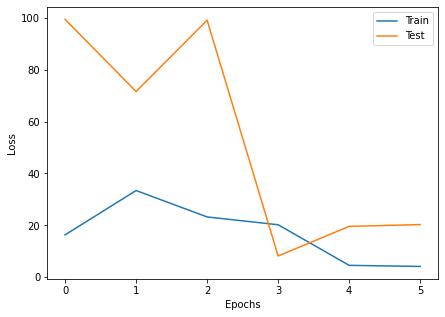

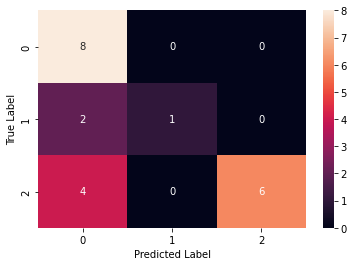

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:19.85719907247403, Test Loss: 39.29193878173828
Epoch 2-- Train Loss:17.856521288553875, Test Loss: 14.180007934570312
Epoch 3-- Train Loss:13.058704536932225, Test Loss: 2.9295601844787598
Epoch 4-- Train Loss:7.497272213300069, Test Loss: 29.060949325561523
Epoch 5-- Train Loss:10.400580525398254, Test Loss: 17.59747886657715
Epoch 6-- Train Loss:3.410335721598434, Test Loss: 4.236244201660156


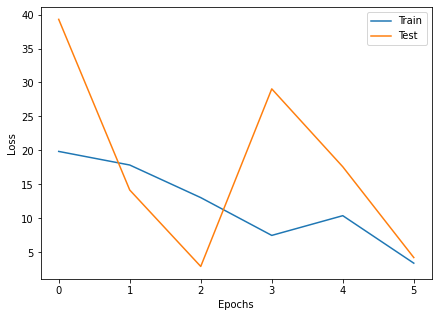

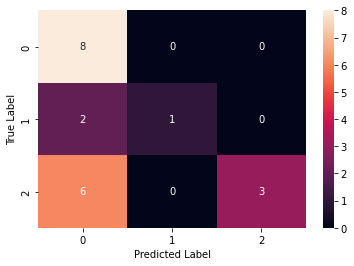

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:17.702440977096558, Test Loss: 76.44143676757812
Epoch 2-- Train Loss:25.103265285491943, Test Loss: 62.14335632324219
Epoch 3-- Train Loss:14.414668281873068, Test Loss: 0.00173378165345639
Epoch 4-- Train Loss:8.235747337341309, Test Loss: 17.887250900268555
Epoch 5-- Train Loss:11.969253540039062, Test Loss: 49.87586212158203
Epoch 6-- Train Loss:10.12745514077445, Test Loss: 6.955880165100098


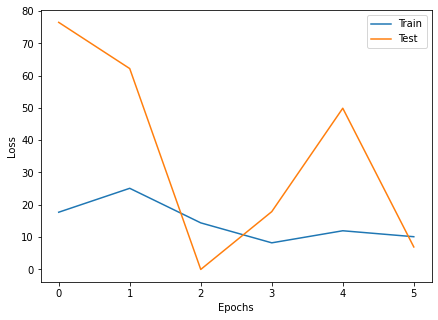

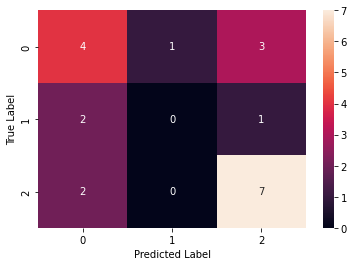

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:22.127427001794178, Test Loss: 21.227291107177734
Epoch 2-- Train Loss:16.10554790496826, Test Loss: 27.652482986450195
Epoch 3-- Train Loss:16.297329485416395, Test Loss: 18.393938064575195
Epoch 4-- Train Loss:5.965506474177043, Test Loss: 20.234251022338867
Epoch 5-- Train Loss:7.368496576944987, Test Loss: 16.247539520263672
Epoch 6-- Train Loss:2.5149483781230324, Test Loss: 6.430737018585205


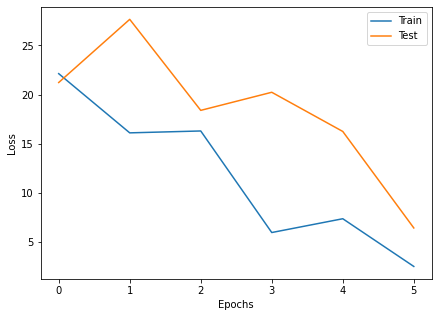

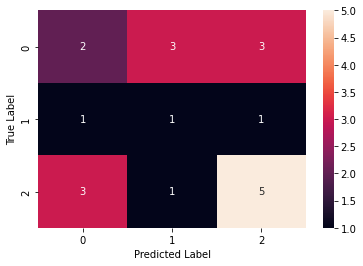

Starting testing
Training Complete
{'0': {'f1-score': '0.594±0.16',
       'precision': '0.544±0.068',
       'recall': '0.725±0.3',
       'support': 8},
 '1': {'f1-score': '0.344±0.203',
       'precision': '0.633±0.452',
       'recall': '0.267±0.133',
       'support': 4},
 '2': {'f1-score': '0.659±0.169',
       'precision': '0.836±0.194',
       'recall': '0.629±0.23',
       'support': 9},
 'accuracy': '0.608±0.123',
 'macro avg': {'f1-score': '0.532±0.143',
               'precision': '0.671±0.22',
               'recall': '0.54±0.115',
               'support': 21},
 'weighted avg': {'f1-score': '0.583±0.142',
                  'precision': '0.686±0.17',
                  'recall': '0.608±0.123',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.0002, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.399681528409322, Test Loss: 4.01616096496582
Epoch 2-- Train Loss:2.7691367864608765, Test Loss: 18.227651596069336
Epoch 3-- Train Loss:

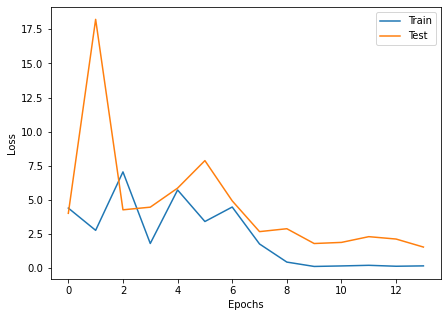

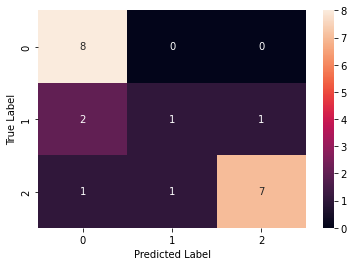

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.3155494133631387, Test Loss: 4.043296813964844
Epoch 2-- Train Loss:5.923967679341634, Test Loss: 3.9575037956237793
Epoch 3-- Train Loss:3.7478838761647544, Test Loss: 2.81997013092041
Epoch 4-- Train Loss:4.45164422194163, Test Loss: 6.701615333557129
Epoch 5-- Train Loss:5.980390310287476, Test Loss: 6.0411481857299805
Epoch 6-- Train Loss:3.2891701459884644, Test Loss: 1.2032123804092407
Epoch 7-- Train Loss:0.6190206607182821, Test Loss: 2.4030561447143555
Epoch 8-- Train Loss:1.6209492286046345, Test Loss: 3.214366912841797
Epoch 9-- Train Loss:1.0869629283746083, Test Loss: 1.48428475856781
Epoch 10-- Train Loss:0.22424795230229697, Test Loss: 1.4877986907958984
Epoch 11-- Train Loss:0.16867139687140784, Test Loss: 1.3627585172653198
Epoch 12-- Train Loss:0.09179737667242686, Test Loss: 1.0076793432235718
Epoch 13-- Train Loss:0.09501754616697629, Test Loss: 0.8773171901702881
Epoch 14-- Train Loss:0

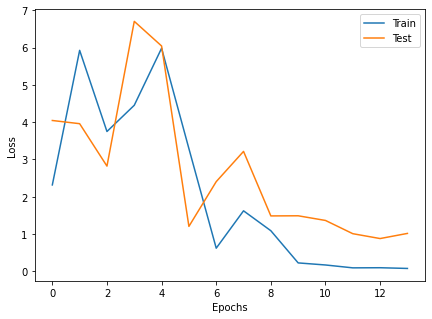

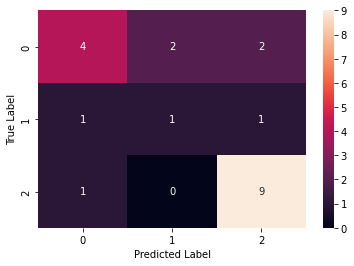

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:6.044020255406697, Test Loss: 2.175837993621826
Epoch 2-- Train Loss:2.39297616481781, Test Loss: 5.018950462341309
Epoch 3-- Train Loss:4.39246129989624, Test Loss: 10.106586456298828
Epoch 4-- Train Loss:3.2890155712763467, Test Loss: 3.779914379119873
Epoch 5-- Train Loss:3.5215245882670083, Test Loss: 5.511815071105957
Epoch 6-- Train Loss:2.9365479151407876, Test Loss: 2.47198748588562
Epoch 7-- Train Loss:1.5942762692769368, Test Loss: 2.2181432247161865
Epoch 8-- Train Loss:1.6060574054718018, Test Loss: 5.66386604309082
Epoch 9-- Train Loss:1.847012460231781, Test Loss: 1.2174174785614014
Epoch 10-- Train Loss:0.2741992101073265, Test Loss: 0.9848167896270752
Epoch 11-- Train Loss:0.14400208741426468, Test Loss: 0.9093694090843201
Epoch 12-- Train Loss:0.08034365934630235, Test Loss: 0.7966197729110718
Epoch 13-- Train Loss:0.05576181039214134, Test Loss: 0.9281231760978699
Epoch 14-- Train Loss:0.062

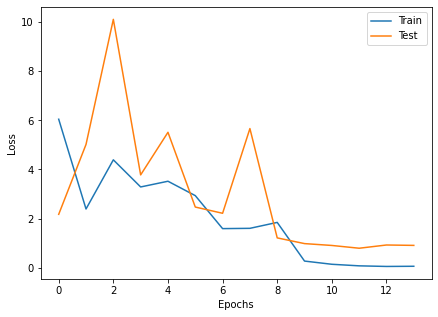

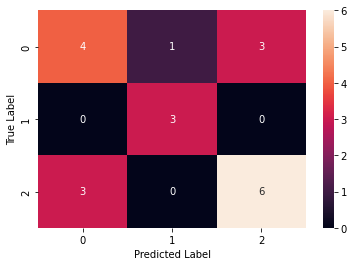

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.023623983065287, Test Loss: 6.319670677185059
Epoch 2-- Train Loss:5.3386945724487305, Test Loss: 8.019007682800293
Epoch 3-- Train Loss:4.529183983802795, Test Loss: 2.621616840362549
Epoch 4-- Train Loss:3.662787675857544, Test Loss: 3.2012245655059814
Epoch 5-- Train Loss:2.3877113858858743, Test Loss: 0.665510892868042
Epoch 6-- Train Loss:0.8771684964497884, Test Loss: 4.4119954109191895
Epoch 7-- Train Loss:2.4033839305241904, Test Loss: 5.1315460205078125
Epoch 8-- Train Loss:1.7601100603739421, Test Loss: 1.587570071220398
Epoch 9-- Train Loss:0.6205457051595052, Test Loss: 0.6857282519340515
Epoch 10-- Train Loss:0.3697345058123271, Test Loss: 1.5258421897888184
Epoch 11-- Train Loss:0.9329206446806589, Test Loss: 1.800817608833313
Epoch 12-- Train Loss:0.39228344957033795, Test Loss: 0.7885932326316833
Epoch 13-- Train Loss:0.21714123586813608, Test Loss: 0.977042019367218
Epoch 14-- Train Loss:0.

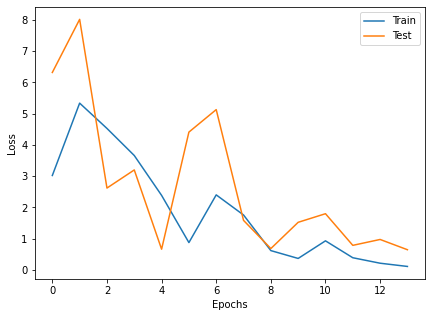

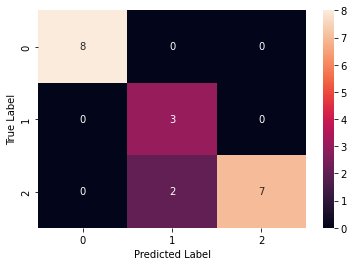

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:6.387618978818257, Test Loss: 14.382262229919434
Epoch 2-- Train Loss:7.32007098197937, Test Loss: 11.237951278686523
Epoch 3-- Train Loss:3.3500083287556968, Test Loss: 5.878403186798096
Epoch 4-- Train Loss:1.5566679040590923, Test Loss: 2.867447853088379
Epoch 5-- Train Loss:0.8578056991100311, Test Loss: 6.271010875701904
Epoch 6-- Train Loss:3.7783323923746743, Test Loss: 3.8922064304351807
Epoch 7-- Train Loss:3.0672496954600015, Test Loss: 6.41180944442749
Epoch 8-- Train Loss:0.6601718813180923, Test Loss: 3.7088708877563477
Epoch 9-- Train Loss:0.12981491163372993, Test Loss: 2.698572874069214
Epoch 10-- Train Loss:0.09686398692429066, Test Loss: 2.7042179107666016
Epoch 11-- Train Loss:0.05716824779907862, Test Loss: 2.8238861560821533
Epoch 12-- Train Loss:0.10088491812348366, Test Loss: 2.861476421356201
Epoch 13-- Train Loss:0.03895637020468712, Test Loss: 2.8362696170806885
Epoch 14-- Train Loss

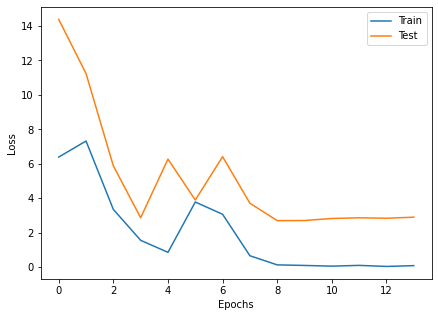

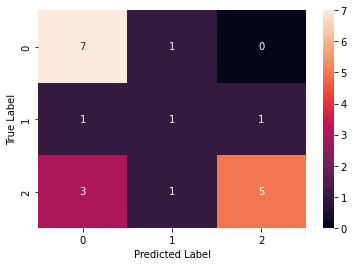

Starting testing
Training Complete
{'0': {'f1-score': '0.765±0.154',
       'precision': '0.726±0.155',
       'recall': '0.825±0.187',
       'support': 8},
 '1': {'f1-score': '0.535±0.223',
       'precision': '0.537±0.137',
       'recall': '0.583±0.342',
       'support': 4},
 '2': {'f1-score': '0.759±0.119',
       'precision': '0.832±0.108',
       'recall': '0.713±0.153',
       'support': 9},
 'accuracy': '0.735±0.104',
 'macro avg': {'f1-score': '0.686±0.109',
               'precision': '0.698±0.095',
               'recall': '0.707±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.725±0.109',
                  'precision': '0.744±0.109',
                  'recall': '0.735±0.104',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.0007000000000000001, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:15.097132404645285, Test Loss: 21.623083114624023
Epoch 2-- Train Loss:27.259419759114582, Test Loss: 9.4313497543334

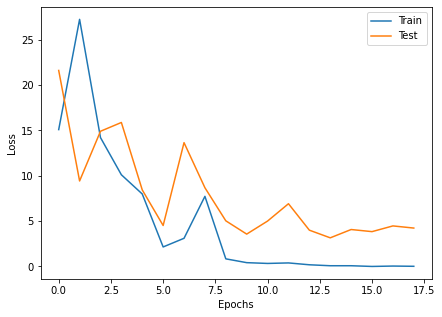

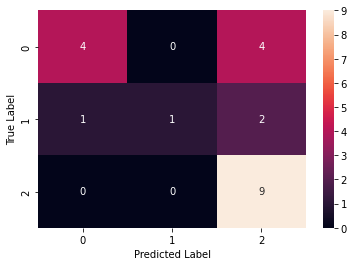

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:12.237455646197, Test Loss: 12.426193237304688
Epoch 2-- Train Loss:19.56914742787679, Test Loss: 32.671478271484375
Epoch 3-- Train Loss:17.862018426259358, Test Loss: 4.445107460021973
Epoch 4-- Train Loss:8.904840071996054, Test Loss: 18.740921020507812
Epoch 5-- Train Loss:6.1377187098066015, Test Loss: 5.767404079437256
Epoch 6-- Train Loss:7.413443962732951, Test Loss: 18.68760108947754
Epoch 7-- Train Loss:8.032029549280802, Test Loss: 5.091812610626221
Epoch 8-- Train Loss:1.479429731766383, Test Loss: 5.466792106628418
Epoch 9-- Train Loss:1.3082074125607808, Test Loss: 5.199647903442383
Epoch 10-- Train Loss:0.45805225272973377, Test Loss: 3.0966691970825195
Epoch 11-- Train Loss:0.07118930884947379, Test Loss: 3.1893537044525146
Epoch 12-- Train Loss:0.06076087926824888, Test Loss: 3.0789458751678467
Epoch 13-- Train Loss:0.09641345745573442, Test Loss: 3.270142078399658
Epoch 14-- Train Loss:0.067

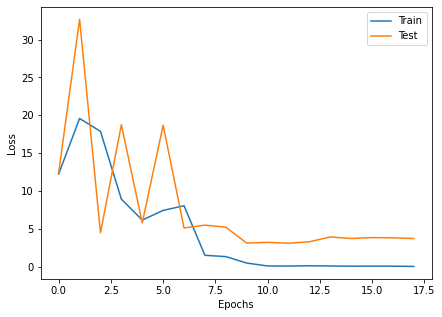

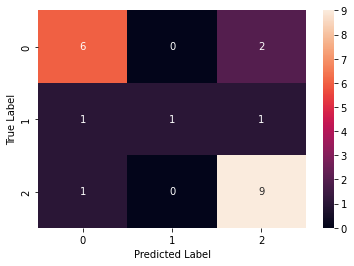

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:17.62214740117391, Test Loss: 16.02485466003418
Epoch 2-- Train Loss:27.721161206563313, Test Loss: 10.028367042541504
Epoch 3-- Train Loss:18.73430411020915, Test Loss: 13.569053649902344
Epoch 4-- Train Loss:3.7157293558120728, Test Loss: 13.729292869567871
Epoch 5-- Train Loss:5.5215427080790205, Test Loss: 7.53116512298584
Epoch 6-- Train Loss:1.760329931974411, Test Loss: 2.6151857376098633
Epoch 7-- Train Loss:1.5769200921058655, Test Loss: 3.151122570037842
Epoch 8-- Train Loss:2.480681538581848, Test Loss: 1.3580867052078247
Epoch 9-- Train Loss:0.30273295442263287, Test Loss: 4.780571460723877
Epoch 10-- Train Loss:4.63416314125061, Test Loss: 8.754263877868652
Epoch 11-- Train Loss:4.119185368220012, Test Loss: 5.306562423706055
Epoch 12-- Train Loss:2.931932032108307, Test Loss: 1.8819801807403564
Epoch 13-- Train Loss:0.24782687425613403, Test Loss: 2.5859017372131348
Epoch 14-- Train Loss:0.13390

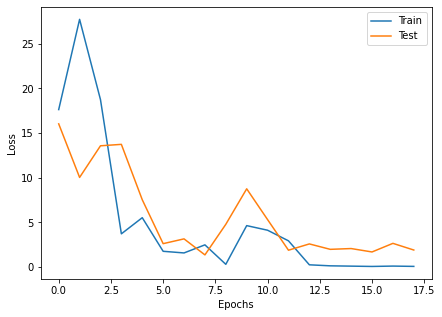

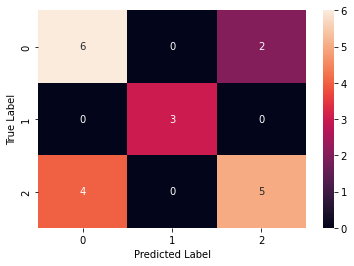

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:15.093869010607401, Test Loss: 56.828086853027344
Epoch 2-- Train Loss:25.44400469462077, Test Loss: 44.76962661743164
Epoch 3-- Train Loss:27.084795316060383, Test Loss: 42.47867965698242
Epoch 4-- Train Loss:17.288227876027424, Test Loss: 12.689784049987793
Epoch 5-- Train Loss:4.4041407108306885, Test Loss: 7.436413288116455
Epoch 6-- Train Loss:1.7507953246434529, Test Loss: 4.4232964515686035
Epoch 7-- Train Loss:0.5640606035788854, Test Loss: 2.258326292037964
Epoch 8-- Train Loss:0.5291722615559896, Test Loss: 2.9674057960510254
Epoch 9-- Train Loss:0.15552389497558275, Test Loss: 2.0017170906066895
Epoch 10-- Train Loss:0.13333220135731003, Test Loss: 2.119682788848877
Epoch 11-- Train Loss:2.5469817171494165, Test Loss: 21.30783462524414
Epoch 12-- Train Loss:12.535054842631022, Test Loss: 4.719979286193848
Epoch 13-- Train Loss:0.6211918336339295, Test Loss: 3.574536085128784
Epoch 14-- Train Loss:0

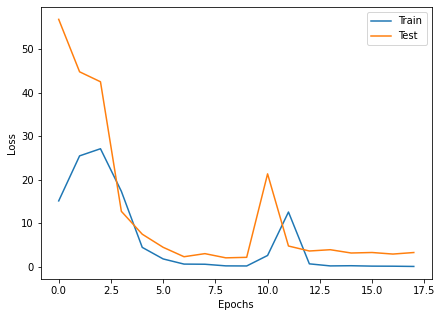

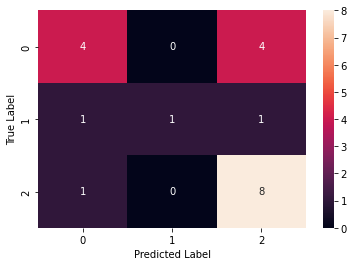

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.9982606172561646, Test Loss: 39.10810470581055
Epoch 2-- Train Loss:18.713172753651936, Test Loss: 13.253471374511719
Epoch 3-- Train Loss:10.618326187133789, Test Loss: 10.370238304138184
Epoch 4-- Train Loss:3.36781636873881, Test Loss: 20.376922607421875
Epoch 5-- Train Loss:18.885130564371746, Test Loss: 34.06557083129883
Epoch 6-- Train Loss:8.922913253307343, Test Loss: 7.924511432647705
Epoch 7-- Train Loss:0.7760430773099264, Test Loss: 9.008190155029297
Epoch 8-- Train Loss:0.564764271179835, Test Loss: 10.512274742126465
Epoch 9-- Train Loss:0.7253016261383891, Test Loss: 8.186540603637695
Epoch 10-- Train Loss:0.1300396754522808, Test Loss: 7.69350528717041
Epoch 11-- Train Loss:0.04216915931707869, Test Loss: 7.28368616104126
Epoch 12-- Train Loss:0.17575287818908691, Test Loss: 7.06102180480957
Epoch 13-- Train Loss:0.014939381430546442, Test Loss: 7.752157211303711
Epoch 14-- Train Loss:0.0313

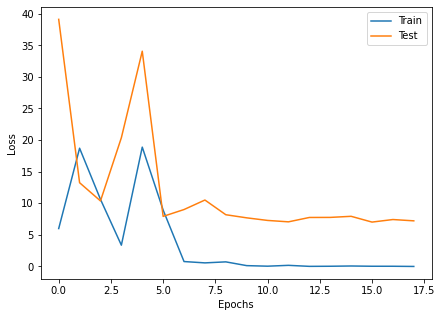

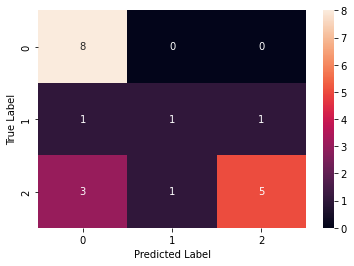

Starting testing
Training Complete
{'0': {'f1-score': '0.718±0.073',
       'precision': '0.718±0.095',
       'recall': '0.75±0.158',
       'support': 8},
 '1': {'f1-score': '0.591±0.198',
       'precision': '0.85±0.2',
       'recall': '0.517±0.281',
       'support': 4},
 '2': {'f1-score': '0.729±0.054',
       'precision': '0.744±0.086',
       'recall': '0.76±0.179',
       'support': 9},
 'accuracy': '0.716±0.045',
 'macro avg': {'f1-score': '0.679±0.076',
               'precision': '0.771±0.067',
               'recall': '0.676±0.078',
               'support': 21},
 'weighted avg': {'f1-score': '0.702±0.055',
                  'precision': '0.752±0.036',
                  'recall': '0.716±0.045',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0002, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:8.250165959021874, Test Loss: 0.0017556031234562397
Epoch 2-- Train Loss:3.312033048343091, Test Loss: 1.1920928244535389e-07
Epoch 3-- Tr

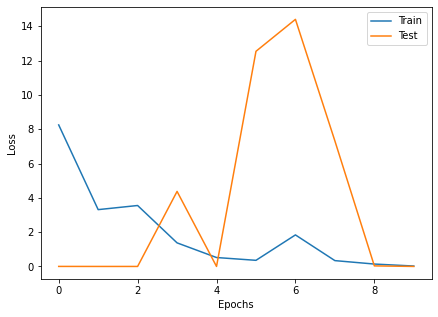

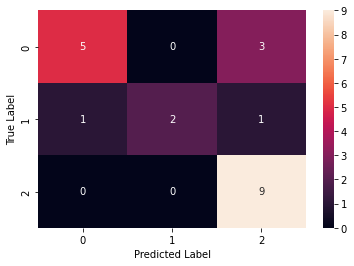

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:9.844312554314023, Test Loss: 46.57035827636719
Epoch 2-- Train Loss:3.7455379270970646, Test Loss: 0.0
Epoch 3-- Train Loss:1.3805879953769054, Test Loss: 1.1920928244535389e-07
Epoch 4-- Train Loss:0.794443562684599, Test Loss: 0.02688816376030445
Epoch 5-- Train Loss:0.9653607553861698, Test Loss: 5.6429924964904785
Epoch 6-- Train Loss:1.7427576303520407, Test Loss: 9.756468772888184
Epoch 7-- Train Loss:0.2543583657149078, Test Loss: 0.002148702275007963
Epoch 8-- Train Loss:0.15936073786853977, Test Loss: 10.762555122375488
Epoch 9-- Train Loss:0.16182790116309456, Test Loss: 0.1181052178144455
Epoch 10-- Train Loss:0.11936933754818552, Test Loss: 5.5598368644714355


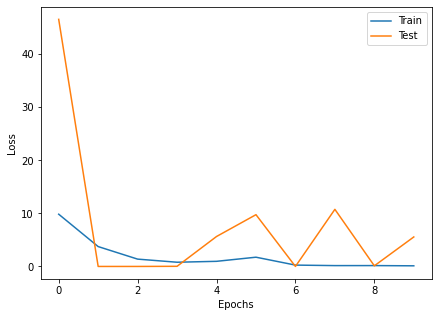

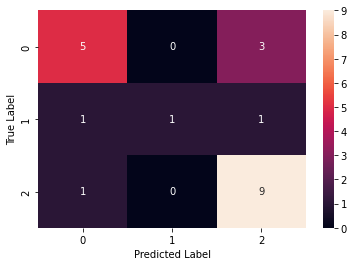

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:10.620266375087557, Test Loss: 16.72955322265625
Epoch 2-- Train Loss:6.176115771511658, Test Loss: 6.042259216308594
Epoch 3-- Train Loss:2.9770722577589344, Test Loss: 3.35455584526062
Epoch 4-- Train Loss:1.0132920041083016, Test Loss: 1.0942524671554565
Epoch 5-- Train Loss:0.9658591733286379, Test Loss: 0.35713887214660645
Epoch 6-- Train Loss:0.5888496628859208, Test Loss: 6.791024208068848
Epoch 7-- Train Loss:0.3870856743057651, Test Loss: 2.026533842086792
Epoch 8-- Train Loss:1.067525230962344, Test Loss: 10.61401081085205
Epoch 9-- Train Loss:1.3571999318727475, Test Loss: 1.358145833015442
Epoch 10-- Train Loss:0.31308640406340243, Test Loss: 10.832744598388672


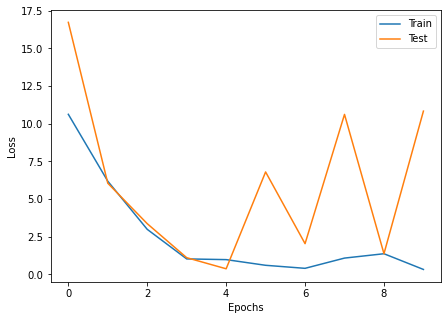

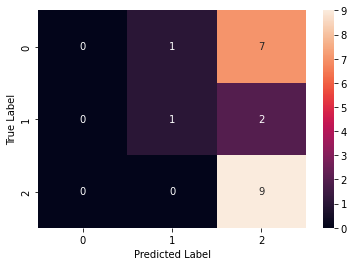

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:7.323378854995099, Test Loss: 10.525237083435059
Epoch 2-- Train Loss:4.54526332276255, Test Loss: 12.607965469360352
Epoch 3-- Train Loss:2.616939101444911, Test Loss: 10.460124015808105
Epoch 4-- Train Loss:1.908842015077209, Test Loss: 1.4411280155181885
Epoch 5-- Train Loss:1.0617996855005025, Test Loss: 26.09577751159668
Epoch 6-- Train Loss:4.622819190735927, Test Loss: 8.234493255615234
Epoch 7-- Train Loss:1.3962720929730696, Test Loss: 2.6239118576049805
Epoch 8-- Train Loss:0.16967863030123115, Test Loss: 2.6089580059051514
Epoch 9-- Train Loss:0.13126258674577448, Test Loss: 1.1155943870544434
Epoch 10-- Train Loss:0.10621988946944666, Test Loss: 0.00016874349967110902


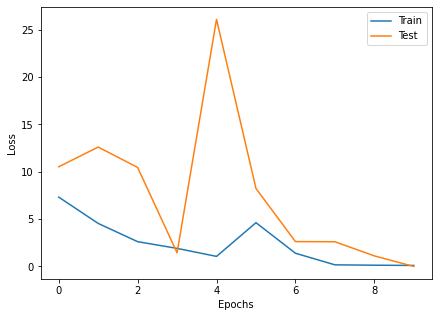

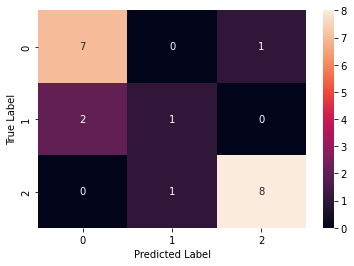

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:7.942674749397805, Test Loss: 14.098074913024902
Epoch 2-- Train Loss:2.6479655756939193, Test Loss: 7.0518341064453125
Epoch 3-- Train Loss:1.6861476791698027, Test Loss: 2.0799143314361572
Epoch 4-- Train Loss:0.8949401152744291, Test Loss: 2.935753345489502
Epoch 5-- Train Loss:2.002051531506281, Test Loss: 5.123984336853027
Epoch 6-- Train Loss:0.20740361481994168, Test Loss: 1.985959768295288
Epoch 7-- Train Loss:0.040511060996892855, Test Loss: 2.960548162460327
Epoch 8-- Train Loss:0.02957749693954847, Test Loss: 1.3334858417510986
Epoch 9-- Train Loss:0.05183565732380623, Test Loss: 3.4535863399505615
Epoch 10-- Train Loss:0.009360166027238933, Test Loss: 7.160511016845703


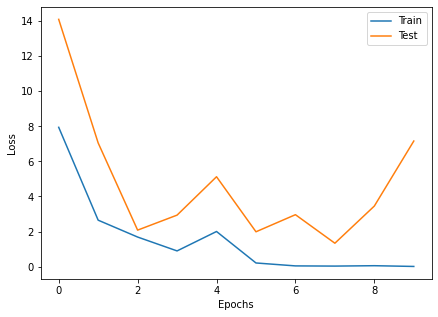

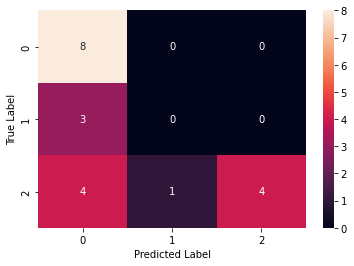

Starting testing
Training Complete
{'0': {'f1-score': '0.622±0.333',
       'precision': '0.6±0.335',
       'recall': '0.675±0.367',
       'support': 8},
 '1': {'f1-score': '0.351±0.325',
       'precision': '0.55±0.458',
       'recall': '0.317±0.367',
       'support': 4},
 '2': {'f1-score': '0.754±0.137',
       'precision': '0.738±0.178',
       'recall': '0.847±0.207',
       'support': 9},
 'accuracy': '0.695±0.167',
 'macro avg': {'f1-score': '0.576±0.246',
               'precision': '0.629±0.289',
               'recall': '0.613±0.21',
               'support': 21},
 'weighted avg': {'f1-score': '0.639±0.224',
                  'precision': '0.657±0.258',
                  'recall': '0.695±0.167',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0005, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:22.21025715824882, Test Loss: 24.447242736816406
Epoch 2-- Train Loss:8.703252960444107, Test Loss: 0.0
Epoch 3-- Train Loss:7.3196437965

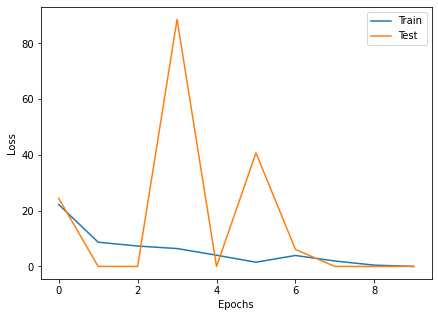

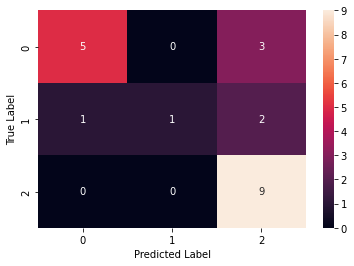

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:18.50179310072036, Test Loss: 86.12899780273438
Epoch 2-- Train Loss:9.71733204874077, Test Loss: 0.0
Epoch 3-- Train Loss:5.2163387400424615, Test Loss: 0.0
Epoch 4-- Train Loss:2.846625990405876, Test Loss: 0.0
Epoch 5-- Train Loss:2.6752638647607303, Test Loss: 0.0016094601014629006
Epoch 6-- Train Loss:4.986770296294232, Test Loss: 19.813552856445312
Epoch 7-- Train Loss:1.4261955799607984, Test Loss: 6.437280717364047e-06
Epoch 8-- Train Loss:1.4699484958472258, Test Loss: 30.217926025390625
Epoch 9-- Train Loss:0.6892224115059175, Test Loss: 0.0
Epoch 10-- Train Loss:0.21474689851600848, Test Loss: 7.027565956115723


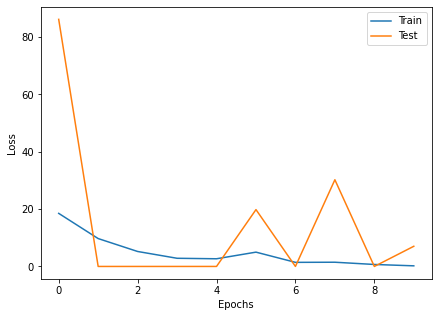

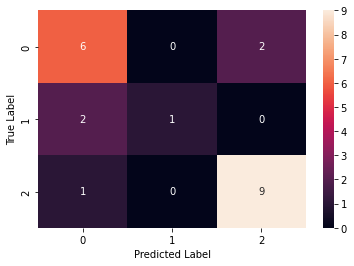

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:21.162108336176193, Test Loss: 23.72809410095215
Epoch 2-- Train Loss:15.167345137823196, Test Loss: 11.777033805847168
Epoch 3-- Train Loss:7.570309984373688, Test Loss: 4.252788066864014
Epoch 4-- Train Loss:1.6561259441386464, Test Loss: 2.6230974197387695
Epoch 5-- Train Loss:5.016696150050853, Test Loss: 5.085975170135498
Epoch 6-- Train Loss:3.8684595788441962, Test Loss: 8.5978364944458
Epoch 7-- Train Loss:2.378188478624947, Test Loss: 3.927168607711792
Epoch 8-- Train Loss:2.3760029047540048, Test Loss: 1.7223223447799683
Epoch 9-- Train Loss:0.11351224298179018, Test Loss: 0.9006800651550293
Epoch 10-- Train Loss:0.6754793893558332, Test Loss: 10.341068267822266


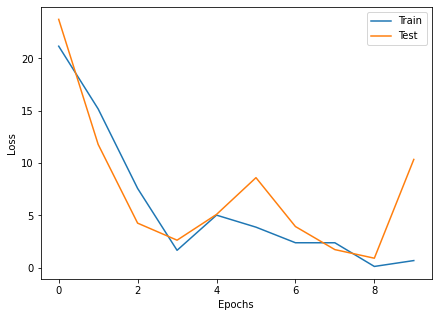

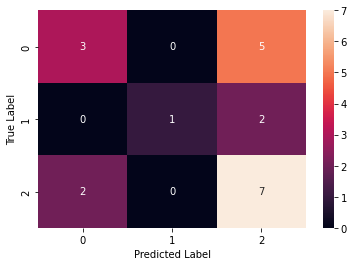

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:19.8403010054997, Test Loss: 18.683374404907227
Epoch 2-- Train Loss:12.138088346583014, Test Loss: 16.51934051513672
Epoch 3-- Train Loss:7.746610689023868, Test Loss: 15.022052764892578
Epoch 4-- Train Loss:8.375761200715951, Test Loss: 4.087178707122803
Epoch 5-- Train Loss:2.842754348029492, Test Loss: 25.118133544921875
Epoch 6-- Train Loss:3.2803154886435997, Test Loss: 23.62407112121582
Epoch 7-- Train Loss:2.4237766504210887, Test Loss: 1.1700398921966553
Epoch 8-- Train Loss:1.9469656707466627, Test Loss: 2.0907325744628906
Epoch 9-- Train Loss:1.6911919282697563, Test Loss: 2.3114583492279053
Epoch 10-- Train Loss:1.1551554029858135, Test Loss: 0.001354564563371241


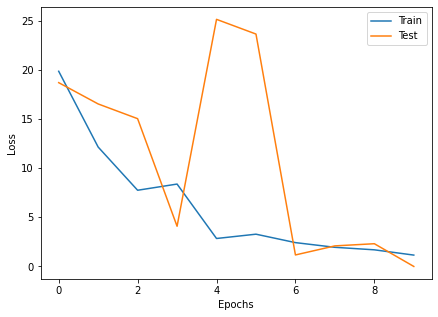

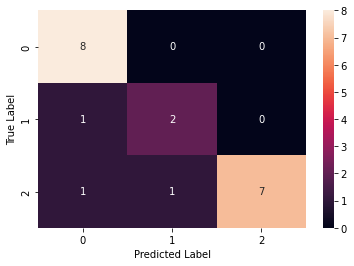

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:18.540600682837606, Test Loss: 31.393661499023438
Epoch 2-- Train Loss:5.792889508148489, Test Loss: 6.886603832244873
Epoch 3-- Train Loss:5.615210931537495, Test Loss: 45.922630310058594
Epoch 4-- Train Loss:2.890594693384255, Test Loss: 1.7506742477416992
Epoch 5-- Train Loss:6.021024298963658, Test Loss: 8.569826126098633
Epoch 6-- Train Loss:2.507200018345332, Test Loss: 6.714245870398372e-08
Epoch 7-- Train Loss:0.7814919895865164, Test Loss: 7.4315948486328125
Epoch 8-- Train Loss:0.15619910877907323, Test Loss: 2.157374620437622
Epoch 9-- Train Loss:0.3025330688044767, Test Loss: 7.195704460144043
Epoch 10-- Train Loss:0.18278579377805756, Test Loss: 25.54849624633789


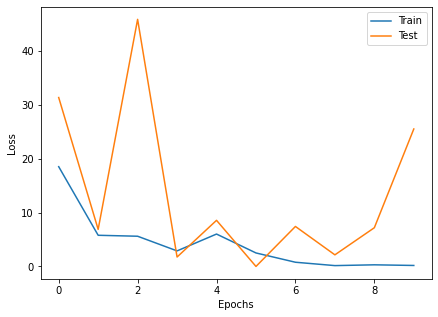

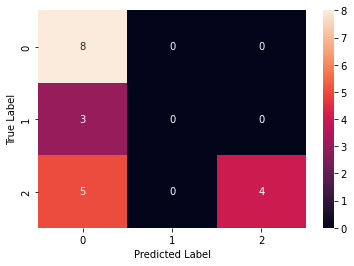

Starting testing
Training Complete
{'0': {'f1-score': '0.699±0.162',
       'precision': '0.694±0.152',
       'recall': '0.75±0.237',
       'support': 8},
 '1': {'f1-score': '0.347±0.299',
       'precision': '0.367±0.306',
       'recall': '0.333±0.298',
       'support': 4},
 '2': {'f1-score': '0.754±0.112',
       'precision': '0.791±0.177',
       'recall': '0.782±0.186',
       'support': 9},
 'accuracy': '0.696±0.111',
 'macro avg': {'f1-score': '0.6±0.14',
               'precision': '0.617±0.128',
               'recall': '0.622±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.665±0.124',
                  'precision': '0.683±0.113',
                  'recall': '0.696±0.111',
                  'support': 21}}


In [83]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='cnn'
    results = train_model(name=name, dataset=dataset, k_folds =5, device=device, **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )


## 3.2 Petrained Resnet-50

In [24]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-3,1e-1, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(2,30, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 26, 'lr': 0.024, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.118453606878492, Test Loss: 3.5611629486083984
Epoch 2-- Train Loss:1.3606377433646808, Test Loss: 1.3608299493789673
Epoch 3-- Train Loss:0.7666072005575354, Test Loss: 1.7608681917190552
Epoch 4-- Train Loss:0.779224616560069, Test Loss: 2.2890007495880127
Epoch 5-- Train Loss:0.3262865448539907, Test Loss: 0.6017875075340271
Epoch 6-- Train Loss:0.6562170785936442, Test Loss: 3.7590529918670654
Epoch 7-- Train Loss:0.6786810904741287, Test Loss: 2.716679811477661
Epoch 8-- Train Loss:0.6395591561767188, Test Loss: 2.6875641345977783
Epoch 9-- Train Loss:0.6423318050801754, Test Loss: 7.269541263580322
Epoch 10-- Train Loss:0.5653241432525895, Test Loss: 0.9683863520622253
Epoch 11-- Train Loss:0.23376225138252432, Test Loss: 0.7311140894889832
Epoch 12-- Train Loss:0.6433180894025348, Test Loss: 2.0085911750793457
Epoch 13-- Train Loss:0.8599966815249487, Test Loss: 23.326

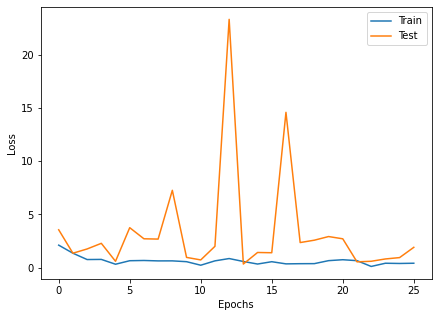

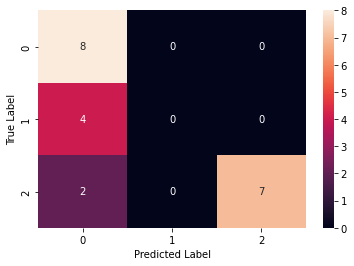

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.7225829362869263, Test Loss: 30.219533920288086
Epoch 2-- Train Loss:1.51633581654592, Test Loss: 1.6044291257858276
Epoch 3-- Train Loss:0.8538554988124154, Test Loss: 3.1878280639648438
Epoch 4-- Train Loss:0.8728363649411635, Test Loss: 6.314393520355225
Epoch 5-- Train Loss:0.6553037789734927, Test Loss: 3.0811355113983154
Epoch 6-- Train Loss:0.4825022877617316, Test Loss: 0.525909423828125
Epoch 7-- Train Loss:0.6014882339672609, Test Loss: 27.01627540588379
Epoch 8-- Train Loss:0.792198627509854, Test Loss: 1.6440706253051758
Epoch 9-- Train Loss:0.512605652382428, Test Loss: 7.517221927642822
Epoch 10-- Train Loss:0.834645440293984, Test Loss: 3.0360641479492188
Epoch 11-- Train Loss:0.7892693381079219, Test Loss: 1.2198785543441772
Epoch 12-- Train Loss:0.48178441932594235, Test Loss: 0.9471743106842041
Epoch 13-- Train Loss:0.3440785670483654, Test Loss: 2.000725507736206
Epoch 14-- Train Loss:0.7

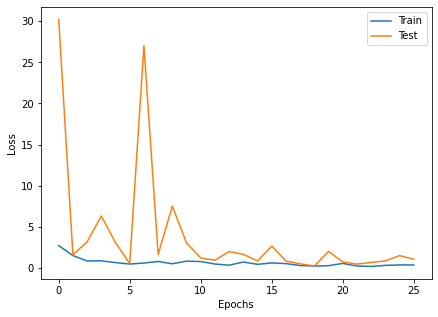

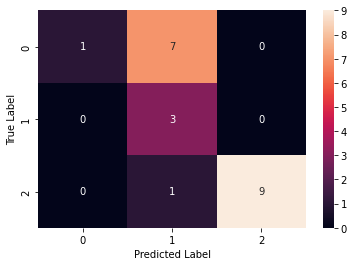

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.8796739307316868, Test Loss: 1.725298285484314
Epoch 2-- Train Loss:1.0947687033225189, Test Loss: 2.366194486618042
Epoch 3-- Train Loss:0.48297975838861684, Test Loss: 1.1751395463943481
Epoch 4-- Train Loss:0.519197894090956, Test Loss: 2.6896469593048096
Epoch 5-- Train Loss:0.7219643796032126, Test Loss: 1.976487159729004
Epoch 6-- Train Loss:0.4644145963882858, Test Loss: 5.070931911468506
Epoch 7-- Train Loss:0.7097969569943168, Test Loss: 1.3438867330551147
Epoch 11-- Train Loss:0.259519312530756, Test Loss: 1.4089326858520508
Epoch 12-- Train Loss:0.156648679594086, Test Loss: 0.28194430470466614
Epoch 13-- Train Loss:0.14011421376331287, Test Loss: 0.5556700229644775
Epoch 14-- Train Loss:0.05722972141070799, Test Loss: 0.3312894403934479
Epoch 15-- Train Loss:0.038796682810326194, Test Loss: 0.2990967929363251
Epoch 16-- Train Loss:0.013583282940089703, Test Loss: 0.4405970573425293
Epoch 17-- Tr

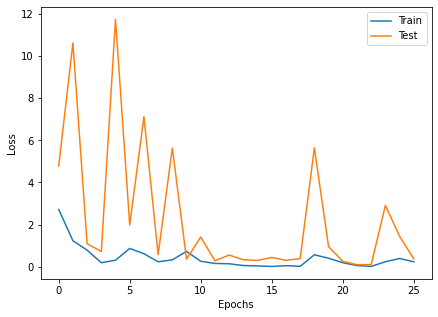

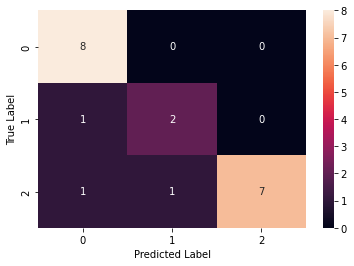

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.51842678676952, Test Loss: 2.3590548038482666
Epoch 2-- Train Loss:1.5609530318867078, Test Loss: 1.120517611503601
Epoch 3-- Train Loss:1.1653152433308689, Test Loss: 6.06915283203125
Epoch 4-- Train Loss:0.984206730669195, Test Loss: 1.2917886972427368
Epoch 5-- Train Loss:0.7693310285156424, Test Loss: 1.5457366704940796
Epoch 6-- Train Loss:0.6597271311012182, Test Loss: 1.6853790283203125
Epoch 7-- Train Loss:0.24705106527967888, Test Loss: 1.2306550741195679
Epoch 8-- Train Loss:0.1493705211376602, Test Loss: 1.098402738571167
Epoch 9-- Train Loss:0.5156059276989915, Test Loss: 2.0855493545532227
Epoch 10-- Train Loss:0.6616755060174249, Test Loss: 4.571737766265869
Epoch 11-- Train Loss:0.29274831305850635, Test Loss: 1.1288689374923706
Epoch 12-- Train Loss:0.05757964520969174, Test Loss: 0.9952275156974792
Epoch 13-- Train Loss:0.09743004732511261, Test Loss: 0.907365083694458
Epoch 14-- Train Loss

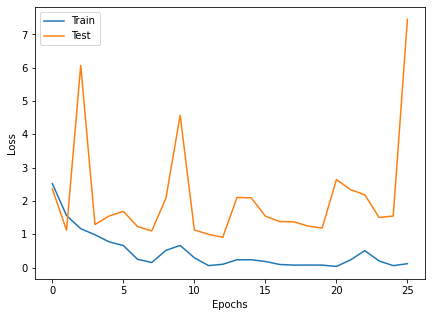

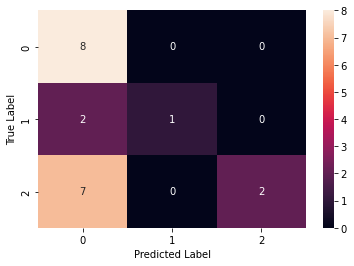

Starting testing
Training Complete
{'0': {'f1-score': '0.655±0.23',
       'precision': '0.7±0.184',
       'recall': '0.825±0.35',
       'support': 8},
 '1': {'f1-score': '0.519±0.326',
       'precision': '0.588±0.398',
       'recall': '0.6±0.389',
       'support': 4},
 '2': {'f1-score': '0.767±0.155',
       'precision': '1.0±0.0',
       'recall': '0.647±0.194',
       'support': 9},
 'accuracy': '0.707±0.1',
 'macro avg': {'f1-score': '0.647±0.146',
               'precision': '0.763±0.132',
               'recall': '0.691±0.125',
               'support': 21},
 'weighted avg': {'f1-score': '0.682±0.115',
                  'precision': '0.813±0.096',
                  'recall': '0.707±0.1',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.08600000000000001, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.5545246736569838, Test Loss: 106499.5390625
Epoch 2-- Train Loss:1.573064767501571, Test Loss: 451.7523498535156
Epoch 3-- Train Los

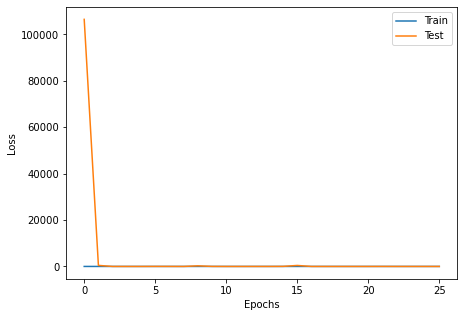

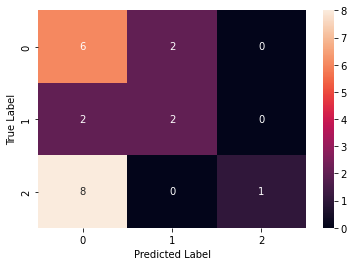

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:4.284208254380659, Test Loss: 616.859375
Epoch 2-- Train Loss:1.0964084294709293, Test Loss: 3.0331428050994873
Epoch 3-- Train Loss:1.0850981961597095, Test Loss: 4.892027854919434
Epoch 4-- Train Loss:1.4605233615094966, Test Loss: 1.6476421356201172
Epoch 5-- Train Loss:1.010450460694053, Test Loss: 2.9505069255828857
Epoch 6-- Train Loss:0.971256061033769, Test Loss: 0.6530117392539978
Epoch 7-- Train Loss:1.0916209573095494, Test Loss: 2.0674936771392822
Epoch 8-- Train Loss:1.2541030862114646, Test Loss: 0.9699737429618835
Epoch 9-- Train Loss:1.2564603198658337, Test Loss: 1.0036624670028687
Epoch 10-- Train Loss:1.0150741663846103, Test Loss: 0.7691246867179871
Epoch 11-- Train Loss:0.9777717752890154, Test Loss: 2.0887272357940674
Epoch 12-- Train Loss:1.2086426290598782, Test Loss: 1.217392086982727
Epoch 13-- Train Loss:1.0304097099737688, Test Loss: 0.9228143692016602
Epoch 14-- Train Loss:1.08614

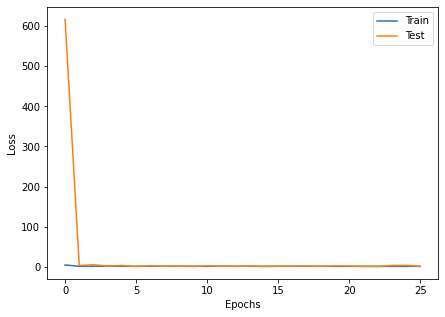

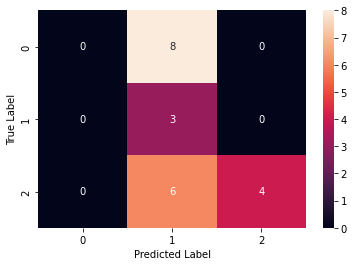

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.08100146597082, Test Loss: 21494.17578125
Epoch 2-- Train Loss:1.0477662953463467, Test Loss: 15.567593574523926
Epoch 3-- Train Loss:0.9085289835929871, Test Loss: 1.2190220355987549
Epoch 4-- Train Loss:0.7764874317429282, Test Loss: 15.298909187316895
Epoch 5-- Train Loss:1.9982320449569009, Test Loss: 1.4526621103286743
Epoch 6-- Train Loss:1.2469976923682473, Test Loss: 1.1428920030593872
Epoch 7-- Train Loss:1.2439799417148938, Test Loss: 1.14362633228302
Epoch 8-- Train Loss:0.9601198922504078, Test Loss: 1.5913077592849731
Epoch 9-- Train Loss:1.087107398293235, Test Loss: 0.9854621291160583
Epoch 10-- Train Loss:1.0072424574331804, Test Loss: 1.3796701431274414
Epoch 11-- Train Loss:0.9663224599578164, Test Loss: 3.883880615234375
Epoch 12-- Train Loss:1.3277803171764722, Test Loss: 1.5561304092407227
Epoch 13-- Train Loss:1.2300529642538591, Test Loss: 1.160869836807251
Epoch 14-- Train Loss:1.171

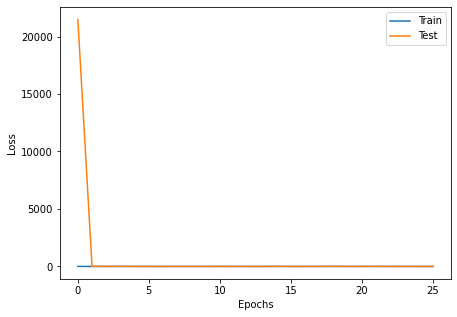

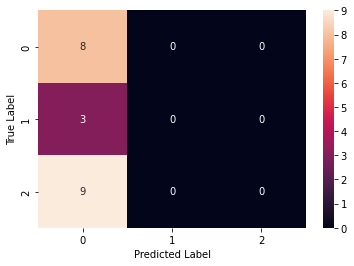

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.780355355956338, Test Loss: 17.530838012695312
Epoch 2-- Train Loss:1.102108353918249, Test Loss: 17.610807418823242
Epoch 3-- Train Loss:2.1078961220654575, Test Loss: 1.195245385169983
Epoch 4-- Train Loss:1.43856111981652, Test Loss: 1.5226284265518188
Epoch 5-- Train Loss:1.1307765733111987, Test Loss: 1.3581055402755737
Epoch 6-- Train Loss:1.3509394309737466, Test Loss: 7.250743389129639
Epoch 7-- Train Loss:1.1302369507876309, Test Loss: 1.803754448890686
Epoch 8-- Train Loss:1.1373188929124312, Test Loss: 1.0799541473388672
Epoch 9-- Train Loss:1.1761895201422952, Test Loss: 37.40623092651367
Epoch 10-- Train Loss:1.0851468443870544, Test Loss: 3.2205755710601807
Epoch 11-- Train Loss:1.0656046271324158, Test Loss: 7.688760280609131
Epoch 12-- Train Loss:0.797845108942552, Test Loss: 0.7881898283958435
Epoch 13-- Train Loss:0.888323350386186, Test Loss: 1.2566689252853394
Epoch 14-- Train Loss:0.796

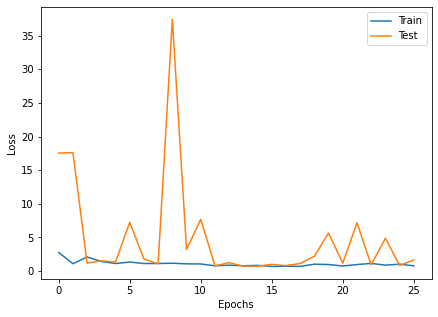

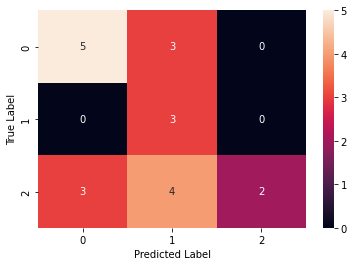

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.758929924531416, Test Loss: 435.0115051269531
Epoch 2-- Train Loss:1.395156199281866, Test Loss: 60.9008903503418
Epoch 3-- Train Loss:1.5356378230181607, Test Loss: 2.7010180950164795
Epoch 4-- Train Loss:1.413647543300282, Test Loss: 1.3566557168960571
Epoch 5-- Train Loss:1.2904714237559924, Test Loss: 1.7895621061325073
Epoch 6-- Train Loss:1.1268595782193271, Test Loss: 1.5768136978149414
Epoch 7-- Train Loss:0.8832650726491754, Test Loss: 1.331628680229187
Epoch 8-- Train Loss:0.7919380935755643, Test Loss: 1.5033620595932007
Epoch 9-- Train Loss:0.9766472334211523, Test Loss: 1.3746124505996704
Epoch 10-- Train Loss:0.8668888238343325, Test Loss: 3.9059627056121826
Epoch 11-- Train Loss:0.7337911643765189, Test Loss: 1.7360972166061401
Epoch 12-- Train Loss:0.8471337963234294, Test Loss: 1.3531233072280884
Epoch 13-- Train Loss:0.6838755201209675, Test Loss: 1.383872389793396
Epoch 14-- Train Loss:0.

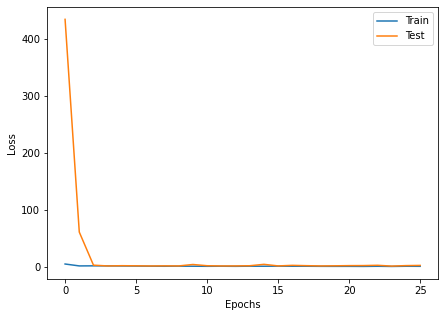

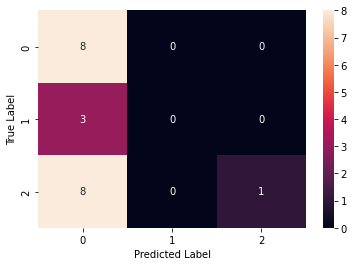

Starting testing
Training Complete
{'0': {'f1-score': '0.458±0.233',
       'precision': '0.364±0.203',
       'recall': '0.675±0.367',
       'support': 8},
 '1': {'f1-score': '0.252±0.217',
       'precision': '0.195±0.19',
       'recall': '0.5±0.447',
       'support': 4},
 '2': {'f1-score': '0.267±0.191',
       'precision': '0.8±0.4',
       'recall': '0.169±0.135',
       'support': 9},
 'accuracy': '0.422±0.055',
 'macro avg': {'f1-score': '0.326±0.104',
               'precision': '0.453±0.185',
               'recall': '0.448±0.098',
               'support': 21},
 'weighted avg': {'f1-score': '0.345±0.083',
                  'precision': '0.538±0.205',
                  'recall': '0.422±0.055',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.063, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.639470661228353, Test Loss: 7.2523579597473145
Epoch 2-- Train Loss:1.2960207787427036, Test Loss: 1.3946542739868164
Epoch 3-- Train Loss:

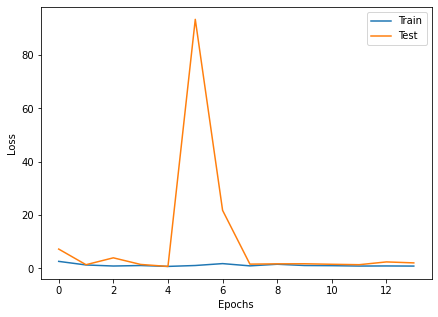

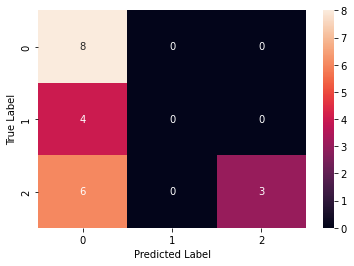

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.9441859505393286, Test Loss: 2.5608644485473633
Epoch 2-- Train Loss:1.4034433960914612, Test Loss: 1.9214550256729126
Epoch 3-- Train Loss:1.20543326031078, Test Loss: 4.6906352043151855
Epoch 4-- Train Loss:1.1568672873757102, Test Loss: 1.592363715171814
Epoch 5-- Train Loss:1.1633737249807878, Test Loss: 1.0216184854507446
Epoch 6-- Train Loss:0.9031527773900465, Test Loss: 1.3803291320800781
Epoch 7-- Train Loss:1.105265506289222, Test Loss: 21.877634048461914
Epoch 8-- Train Loss:1.0935746214606545, Test Loss: 0.9316413402557373
Epoch 9-- Train Loss:0.8401116078550165, Test Loss: 2.4603493213653564
Epoch 10-- Train Loss:0.843466355042024, Test Loss: 0.8715119361877441
Epoch 11-- Train Loss:0.9295935386961157, Test Loss: 1.1655350923538208
Epoch 12-- Train Loss:0.5722115256569602, Test Loss: 0.8543594479560852
Epoch 13-- Train Loss:0.5533808652650226, Test Loss: 56980.45703125
Epoch 14-- Train Loss:1.1

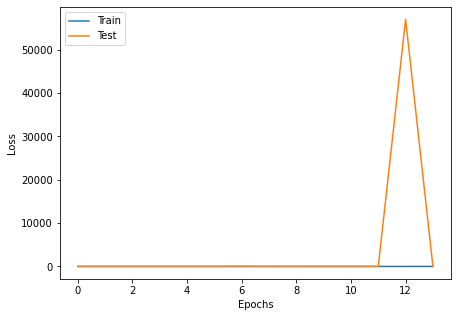

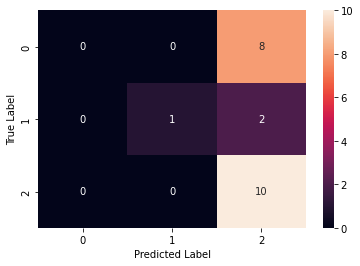

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.9833252863450483, Test Loss: 4.891395568847656
Epoch 2-- Train Loss:1.4755312637849287, Test Loss: 15.662189483642578
Epoch 3-- Train Loss:1.4848740805279126, Test Loss: 1.3331267833709717
Epoch 4-- Train Loss:1.21429734880274, Test Loss: 1.2952767610549927
Epoch 5-- Train Loss:1.1049233620817012, Test Loss: 1.5201082229614258
Epoch 6-- Train Loss:1.0817107937552712, Test Loss: 1.9506354331970215
Epoch 7-- Train Loss:1.0764294320886785, Test Loss: 0.9187643527984619
Epoch 8-- Train Loss:1.1887948567217046, Test Loss: 64.16106414794922
Epoch 9-- Train Loss:0.9529385702176527, Test Loss: 2.1704630851745605
Epoch 10-- Train Loss:1.064560971476815, Test Loss: 0.9867534637451172
Epoch 11-- Train Loss:0.8208253437822516, Test Loss: 0.8345896601676941
Epoch 12-- Train Loss:0.848716055805033, Test Loss: 0.8358750343322754
Epoch 13-- Train Loss:0.815780059857802, Test Loss: 1.0502920150756836
Epoch 14-- Train Loss:0

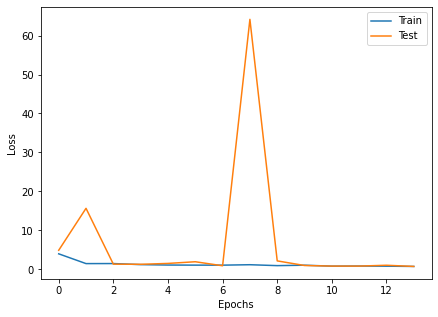

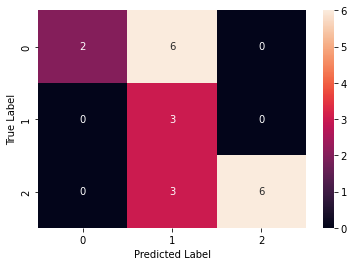

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.361071478236805, Test Loss: 6.0326080322265625
Epoch 2-- Train Loss:1.6929120963270015, Test Loss: 2.6208934783935547
Epoch 3-- Train Loss:1.8041527217084712, Test Loss: 57.544189453125
Epoch 4-- Train Loss:1.3195148543878035, Test Loss: 233.87799072265625
Epoch 5-- Train Loss:1.2660299322821877, Test Loss: 1.6485008001327515
Epoch 6-- Train Loss:1.1538834138350054, Test Loss: 2.5417375564575195
Epoch 7-- Train Loss:1.213620575991544, Test Loss: 1.2109650373458862
Epoch 8-- Train Loss:1.0518897338347002, Test Loss: 1.7678589820861816
Epoch 9-- Train Loss:1.0527612350203774, Test Loss: 1.284017562866211
Epoch 10-- Train Loss:1.1126967560161243, Test Loss: 1.3250746726989746
Epoch 11-- Train Loss:0.9649299301884391, Test Loss: 1.0400339365005493
Epoch 12-- Train Loss:0.7700818451968107, Test Loss: 0.8358294367790222
Epoch 13-- Train Loss:1.0836048207499764, Test Loss: 1.231359839439392
Epoch 14-- Train Loss:0

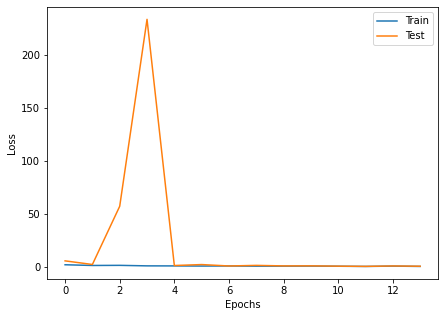

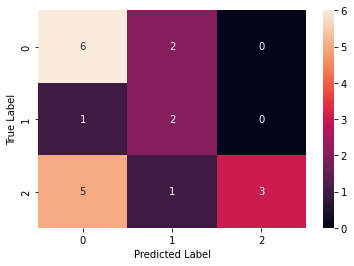

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.744101719422774, Test Loss: 428.9163513183594
Epoch 2-- Train Loss:1.5241212032058022, Test Loss: 1.2872941493988037
Epoch 3-- Train Loss:1.1616032448681919, Test Loss: 1.3946415185928345
Epoch 4-- Train Loss:1.1279823780059814, Test Loss: 25.606040954589844
Epoch 5-- Train Loss:1.1180833957412026, Test Loss: 1.8859413862228394
Epoch 6-- Train Loss:0.7388172041286122, Test Loss: 0.9321340918540955
Epoch 7-- Train Loss:0.8884883468801325, Test Loss: 1.3056362867355347
Epoch 8-- Train Loss:0.8757911703803323, Test Loss: 2.3966832160949707
Epoch 9-- Train Loss:0.5670550722967495, Test Loss: 2.515113592147827
Epoch 10-- Train Loss:0.37617409364743665, Test Loss: 2.240480422973633
Epoch 11-- Train Loss:0.2694508582353592, Test Loss: 1.2612136602401733
Epoch 12-- Train Loss:0.3248240327970548, Test Loss: 1.7417033910751343
Epoch 13-- Train Loss:0.3246756944466721, Test Loss: 2.621062994003296
Epoch 14-- Train Los

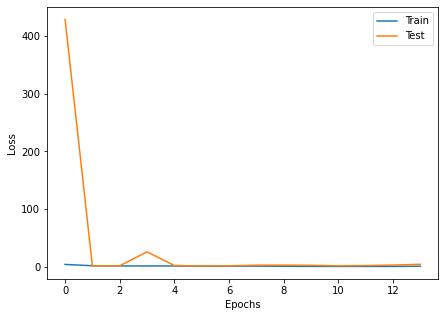

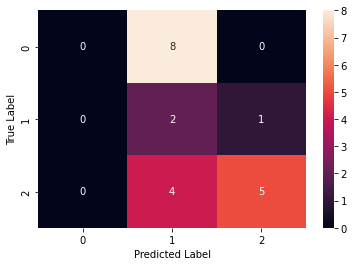

Starting testing
Training Complete
{'0': {'f1-score': '0.349±0.303',
       'precision': '0.403±0.377',
       'recall': '0.45±0.458',
       'support': 8},
 '1': {'f1-score': '0.36±0.228',
       'precision': '0.412±0.369',
       'recall': '0.533±0.34',
       'support': 4},
 '2': {'f1-score': '0.627±0.114',
       'precision': '0.867±0.194',
       'recall': '0.578±0.247',
       'support': 9},
 'accuracy': '0.52±0.097',
 'macro avg': {'f1-score': '0.445±0.12',
               'precision': '0.561±0.165',
               'recall': '0.52±0.109',
               'support': 21},
 'weighted avg': {'f1-score': '0.474±0.108',
                  'precision': '0.608±0.202',
                  'recall': '0.52±0.097',
                  'support': 21}}
{'num_epochs': 14, 'lr': 0.058, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.096713889728893, Test Loss: 42.52909851074219
Epoch 2-- Train Loss:1.517763059247624, Test Loss: 6.4980788230896
Epoch 3-- Train Loss:1.315

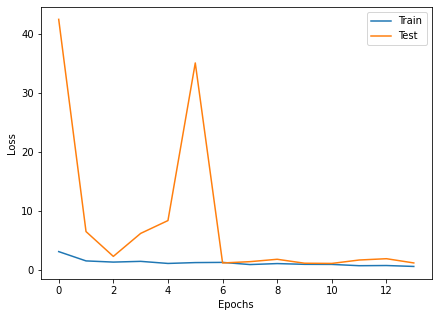

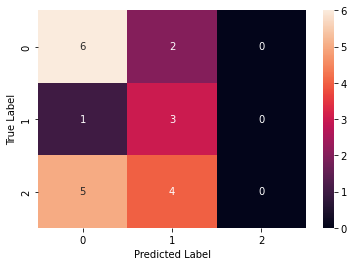

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.677968599579551, Test Loss: 5808.560546875
Epoch 2-- Train Loss:1.5414726788347417, Test Loss: 2.190741777420044
Epoch 3-- Train Loss:1.240825430913405, Test Loss: 2.4990174770355225
Epoch 4-- Train Loss:1.236760594628074, Test Loss: 1.383079171180725
Epoch 5-- Train Loss:1.139269232749939, Test Loss: 1.4124078750610352
Epoch 6-- Train Loss:1.017630633982745, Test Loss: 1.6832717657089233
Epoch 7-- Train Loss:1.311344173821536, Test Loss: 6.216122150421143
Epoch 8-- Train Loss:1.088503274050626, Test Loss: 4.243261337280273
Epoch 9-- Train Loss:1.0726171298460527, Test Loss: 1.4401212930679321
Epoch 10-- Train Loss:1.083472024310719, Test Loss: 1.0833858251571655
Epoch 11-- Train Loss:1.0852182453328914, Test Loss: 1.2980412244796753
Epoch 12-- Train Loss:1.1502979614517905, Test Loss: 1.381508469581604
Epoch 13-- Train Loss:0.9185207675803791, Test Loss: 2.884382486343384
Epoch 14-- Train Loss:1.0170423686

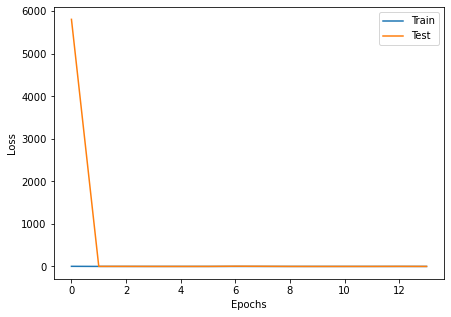

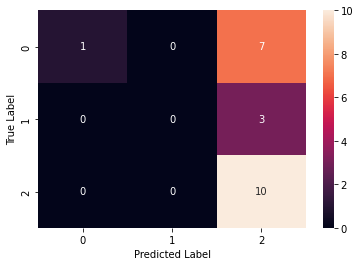

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.079432552511042, Test Loss: 24694.8984375
Epoch 2-- Train Loss:1.5049207969145342, Test Loss: 1.2929739952087402
Epoch 3-- Train Loss:1.3443538384004072, Test Loss: 1.1262856721878052
Epoch 4-- Train Loss:1.1625630422071977, Test Loss: 2.6593539714813232
Epoch 5-- Train Loss:1.1674981821667065, Test Loss: 1.169751763343811
Epoch 6-- Train Loss:1.142360589720986, Test Loss: 2.226155996322632
Epoch 7-- Train Loss:1.1763799298893323, Test Loss: 1.2546696662902832
Epoch 8-- Train Loss:1.0673466595736416, Test Loss: 29642.75
Epoch 9-- Train Loss:1.1080394278873096, Test Loss: 1.8619190454483032
Epoch 10-- Train Loss:1.100256004116752, Test Loss: 1.059799313545227
Epoch 11-- Train Loss:0.8643900643695485, Test Loss: 1.0790627002716064
Epoch 12-- Train Loss:0.8964170271700079, Test Loss: 1.08149254322052
Epoch 13-- Train Loss:1.151579737663269, Test Loss: 1.0003873109817505
Epoch 14-- Train Loss:0.8236127658323809

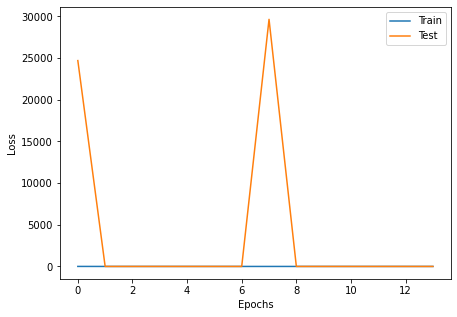

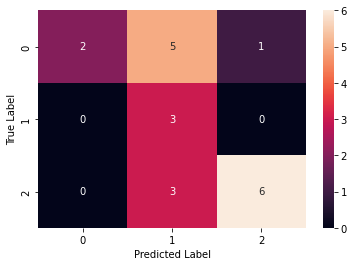

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.784416848962957, Test Loss: 12.706990242004395
Epoch 2-- Train Loss:1.758506883274425, Test Loss: 707.1723022460938
Epoch 3-- Train Loss:1.6473905715075405, Test Loss: 1.6401009559631348
Epoch 4-- Train Loss:1.1399070620536804, Test Loss: 1.5689939260482788
Epoch 5-- Train Loss:1.0570580254901538, Test Loss: 1.4800440073013306
Epoch 6-- Train Loss:1.1099046902223066, Test Loss: 1.1567870378494263
Epoch 7-- Train Loss:1.0952051607045261, Test Loss: 24.205520629882812
Epoch 8-- Train Loss:0.9630930748852816, Test Loss: 1.301963210105896
Epoch 9-- Train Loss:1.0361173152923584, Test Loss: 1.0596641302108765
Epoch 10-- Train Loss:0.9768126254731958, Test Loss: 1.5544430017471313
Epoch 11-- Train Loss:0.8428002514622428, Test Loss: 2.74389386177063
Epoch 12-- Train Loss:0.7481929659843445, Test Loss: 8.257805824279785
Epoch 13-- Train Loss:0.9582558870315552, Test Loss: 1.3915060758590698
Epoch 14-- Train Loss:1

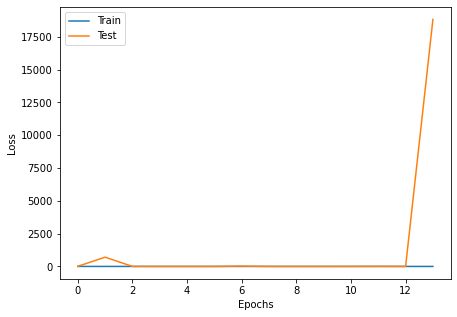

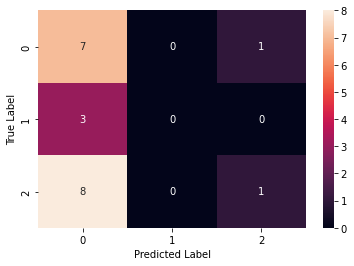

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.9526506174694407, Test Loss: 92.48912811279297
Epoch 2-- Train Loss:1.5313796130093662, Test Loss: 1.3765230178833008
Epoch 3-- Train Loss:1.4053642587228254, Test Loss: 6.140177249908447
Epoch 4-- Train Loss:1.1973693750121377, Test Loss: 1.4602079391479492
Epoch 5-- Train Loss:1.2143942605365405, Test Loss: 1.4259840250015259
Epoch 6-- Train Loss:1.041416590864008, Test Loss: 1.1324464082717896
Epoch 7-- Train Loss:1.0762460936199536, Test Loss: 1.7547720670700073
Epoch 8-- Train Loss:1.080790189179507, Test Loss: 1.7697898149490356
Epoch 9-- Train Loss:0.890562729402022, Test Loss: 12.467769622802734
Epoch 10-- Train Loss:0.7908141897483305, Test Loss: 1.6696683168411255
Epoch 11-- Train Loss:0.5409198877486315, Test Loss: 1.2233977317810059
Epoch 12-- Train Loss:0.5869307368993759, Test Loss: 2.4312610626220703
Epoch 13-- Train Loss:0.4789666641842235, Test Loss: 2.104970693588257
Epoch 14-- Train Loss:

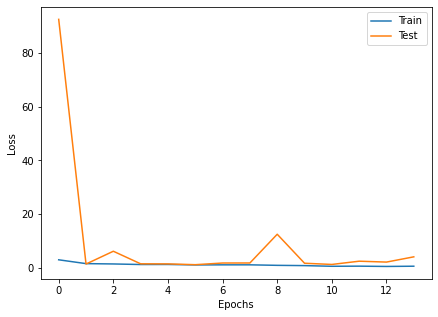

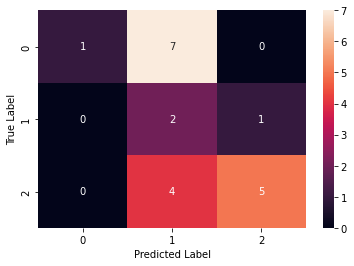

Starting testing
Training Complete
{'0': {'f1-score': '0.397±0.156',
       'precision': '0.778±0.274',
       'recall': '0.425±0.322',
       'support': 8},
 '1': {'f1-score': '0.228±0.2',
       'precision': '0.152±0.137',
       'recall': '0.483±0.41',
       'support': 4},
 '2': {'f1-score': '0.453±0.303',
       'precision': '0.538±0.31',
       'recall': '0.467±0.368',
       'support': 9},
 'accuracy': '0.46±0.064',
 'macro avg': {'f1-score': '0.359±0.096',
               'precision': '0.489±0.179',
               'recall': '0.458±0.108',
               'support': 21},
 'weighted avg': {'f1-score': '0.401±0.094',
                  'precision': '0.576±0.226',
                  'recall': '0.46±0.064',
                  'support': 21}}
{'num_epochs': 2, 'lr': 0.037000000000000005, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.6974878758192062, Test Loss: 3.0949909687042236
Epoch 2-- Train Loss:2.736312965552012, Test Loss: 24.73233985900879


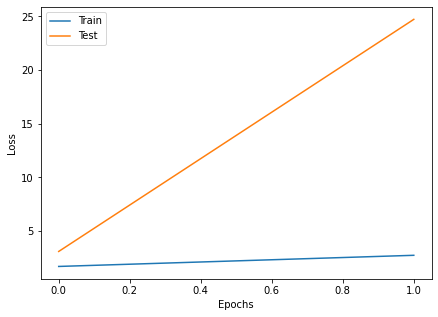

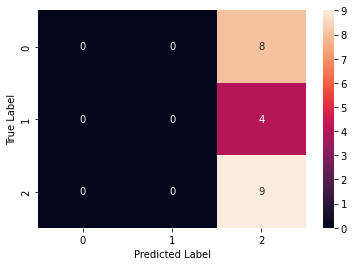

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.6861055940389633, Test Loss: 18.326950073242188
Epoch 2-- Train Loss:1.9026250839233398, Test Loss: 10.223421096801758


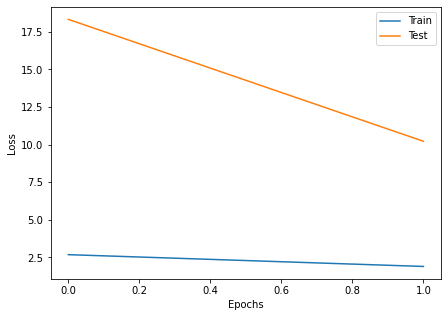

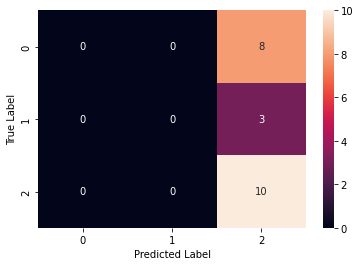

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.5521573225657144, Test Loss: 2.6692285537719727
Epoch 2-- Train Loss:4.732485791047414, Test Loss: 173.68136596679688


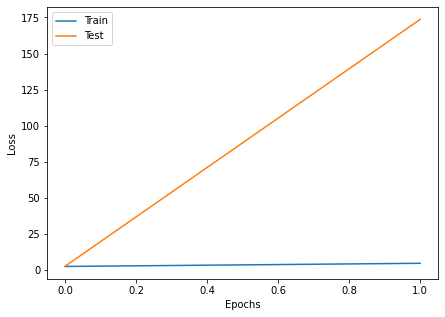

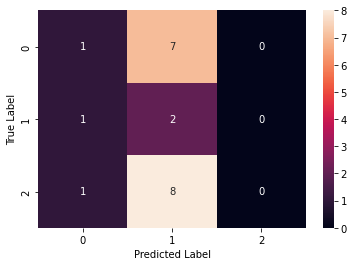

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.0342098297551274, Test Loss: 10.353907585144043
Epoch 2-- Train Loss:1.8967872659365337, Test Loss: 5.245150566101074


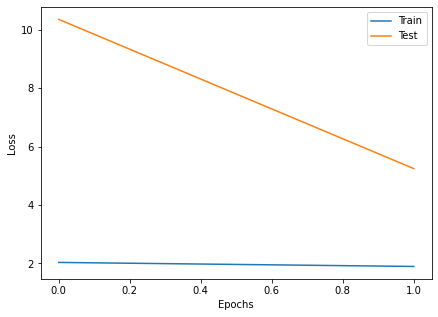

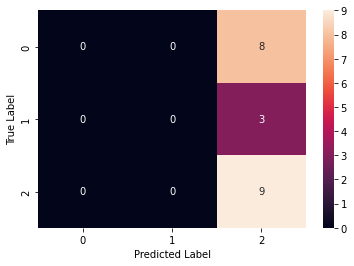

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.454903026421865, Test Loss: 8.151079177856445
Epoch 2-- Train Loss:3.3936102787653604, Test Loss: 12.788899421691895


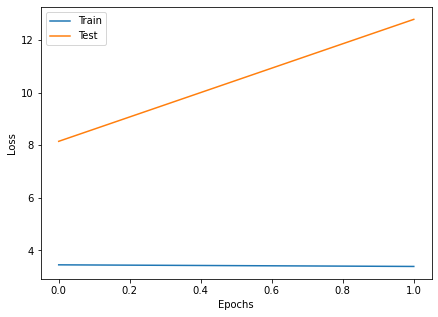

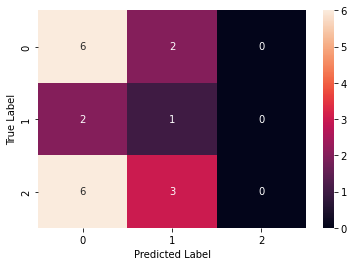

Starting testing
Training Complete
{'0': {'f1-score': '0.141±0.203',
       'precision': '0.147±0.181',
       'recall': '0.175±0.292',
       'support': 8},
 '1': {'f1-score': '0.04±0.08',
       'precision': '0.024±0.047',
       'recall': '0.133±0.267',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.361±0.122',
 'macro avg': {'f1-score': '0.185±0.032',
               'precision': '0.147±0.009',
               'recall': '0.303±0.038',
               'support': 21},
 'weighted avg': {'f1-score': '0.231±0.072',
                  'precision': '0.185±0.028',
                  'recall': '0.361±0.122',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.013000000000000001, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.211307446161906, Test Loss: 1.5375308990478516
Epoch 2-- Train Loss:1.5780400037765503, Test Loss: 1.6387380361557007
Epo

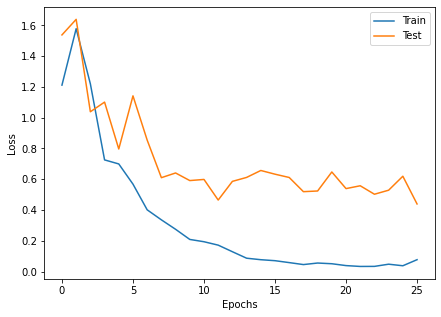

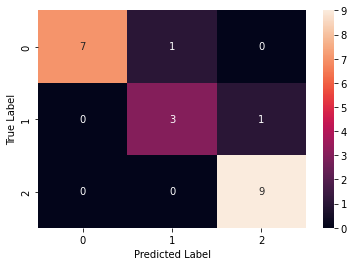

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1063997348149617, Test Loss: 1.0349124670028687
Epoch 2-- Train Loss:1.001333236694336, Test Loss: 1.094357967376709
Epoch 3-- Train Loss:1.1356277267138164, Test Loss: 1.0109750032424927
Epoch 4-- Train Loss:1.0222235123316448, Test Loss: 0.807460606098175
Epoch 5-- Train Loss:0.5426867206891378, Test Loss: 1.0852699279785156
Epoch 6-- Train Loss:0.520857701698939, Test Loss: 0.8773468136787415
Epoch 7-- Train Loss:0.3209247589111328, Test Loss: 0.6657610535621643
Epoch 8-- Train Loss:0.34403371810913086, Test Loss: 0.7085268497467041
Epoch 9-- Train Loss:0.211257537206014, Test Loss: 0.7159494161605835
Epoch 10-- Train Loss:0.1723185877005259, Test Loss: 0.5855082869529724
Epoch 11-- Train Loss:0.13044985632101694, Test Loss: 0.5837701559066772
Epoch 12-- Train Loss:0.1320992186665535, Test Loss: 0.5034275650978088
Epoch 13-- Train Loss:0.08868194371461868, Test Loss: 0.5543121099472046
Epoch 14-- Train L

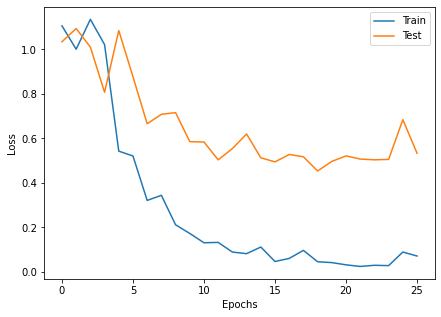

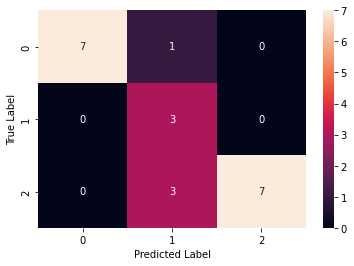

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.3627719084421794, Test Loss: 1.0717717409133911
Epoch 2-- Train Loss:0.9655280709266663, Test Loss: 1.1266382932662964
Epoch 3-- Train Loss:0.8900766770044962, Test Loss: 0.8844248056411743
Epoch 4-- Train Loss:0.6633949081103007, Test Loss: 1.073146104812622
Epoch 5-- Train Loss:0.6468164523442587, Test Loss: 0.8698930144309998
Epoch 6-- Train Loss:0.4610037902990977, Test Loss: 0.6885244250297546
Epoch 7-- Train Loss:0.4168230692545573, Test Loss: 0.7841246128082275
Epoch 8-- Train Loss:0.35926063855489093, Test Loss: 0.9538163542747498
Epoch 9-- Train Loss:0.32485108574231464, Test Loss: 0.733625054359436
Epoch 10-- Train Loss:0.3387547979752223, Test Loss: 0.7050987482070923
Epoch 11-- Train Loss:0.14610110719998678, Test Loss: 0.6939828991889954
Epoch 12-- Train Loss:0.14585995922485986, Test Loss: 0.6860055923461914
Epoch 13-- Train Loss:0.09965709100166957, Test Loss: 0.6421546936035156
Epoch 14-- Tr

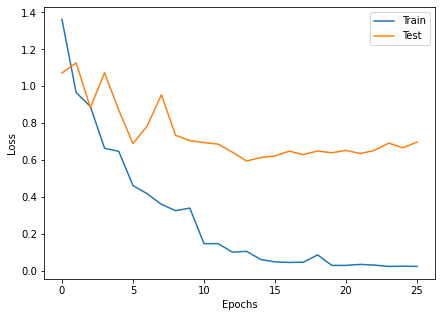

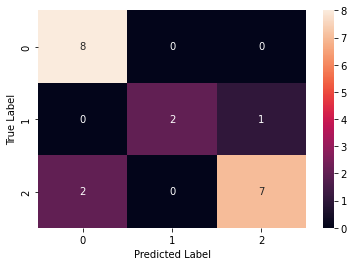

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.0906154712041218, Test Loss: 1.0236830711364746
Epoch 2-- Train Loss:0.9688487847646078, Test Loss: 1.0390279293060303
Epoch 3-- Train Loss:0.8103485902150472, Test Loss: 0.8785287141799927
Epoch 4-- Train Loss:0.6883930166562399, Test Loss: 0.8297461271286011
Epoch 5-- Train Loss:0.5947127540906271, Test Loss: 1.022508144378662
Epoch 6-- Train Loss:0.6005762418111166, Test Loss: 0.6594735383987427
Epoch 7-- Train Loss:0.4216528038183848, Test Loss: 0.646750271320343
Epoch 8-- Train Loss:0.30704959233601886, Test Loss: 0.5900998115539551
Epoch 9-- Train Loss:0.21301730473836264, Test Loss: 0.5990941524505615
Epoch 10-- Train Loss:0.24888824423154196, Test Loss: 0.7197948098182678
Epoch 11-- Train Loss:0.1841469183564186, Test Loss: 0.637724757194519
Epoch 12-- Train Loss:0.10331412156422932, Test Loss: 0.5786412954330444
Epoch 13-- Train Loss:0.09958309431870778, Test Loss: 0.5098950266838074
Epoch 14-- Tra

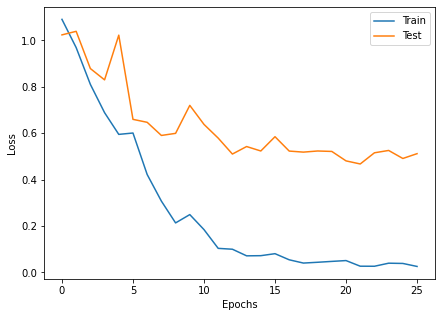

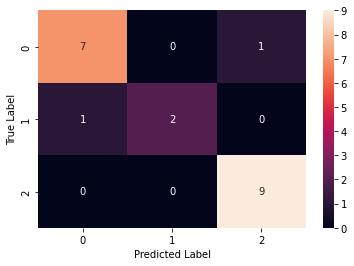

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.2157844305038452, Test Loss: 1.3195664882659912
Epoch 2-- Train Loss:1.1830114126205444, Test Loss: 1.3012417554855347
Epoch 3-- Train Loss:0.8698460857073466, Test Loss: 1.1631768941879272
Epoch 4-- Train Loss:0.8658876816431681, Test Loss: 0.9123483300209045
Epoch 5-- Train Loss:0.5431061685085297, Test Loss: 0.9192747473716736
Epoch 6-- Train Loss:0.5505437850952148, Test Loss: 1.0653307437896729
Epoch 7-- Train Loss:0.4078890383243561, Test Loss: 1.025499701499939
Epoch 8-- Train Loss:0.26748823126157123, Test Loss: 0.8023219704627991
Epoch 9-- Train Loss:0.22732064127922058, Test Loss: 0.7891634106636047
Epoch 10-- Train Loss:0.19084104398886362, Test Loss: 0.732872724533081
Epoch 11-- Train Loss:0.13611675053834915, Test Loss: 0.8413076400756836
Epoch 12-- Train Loss:0.14872452119986215, Test Loss: 0.8923792243003845
Epoch 13-- Train Loss:0.10349355389674504, Test Loss: 0.8723959922790527
Epoch 14-- T

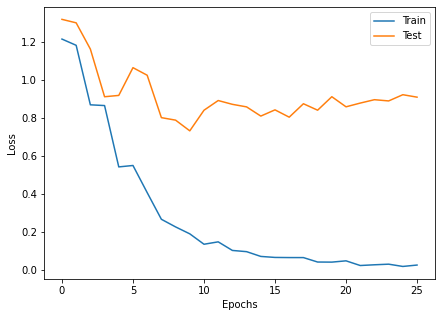

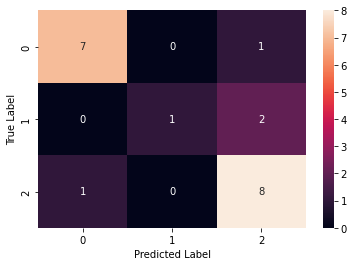

Starting testing
Training Complete
{'0': {'f1-score': '0.873±0.036',
       'precision': '0.906±0.085',
       'recall': '0.85±0.05',
       'support': 8},
 '1': {'f1-score': '0.647±0.098',
       'precision': '0.739±0.227',
       'recall': '0.683±0.213',
       'support': 4},
 '2': {'f1-score': '0.868±0.065',
       'precision': '0.88±0.088',
       'recall': '0.873±0.12',
       'support': 9},
 'accuracy': '0.833±0.039',
 'macro avg': {'f1-score': '0.796±0.05',
               'precision': '0.842±0.052',
               'recall': '0.802±0.059',
               'support': 21},
 'weighted avg': {'f1-score': '0.835±0.04',
                  'precision': '0.867±0.044',
                  'recall': '0.833±0.039',
                  'support': 21}}
{'num_epochs': 18, 'lr': 0.067, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.529892643292745, Test Loss: 147.9536895751953
Epoch 2-- Train Loss:1.4917694273449125, Test Loss: 1.4455952644348145
Epoch 3-- Train Loss:

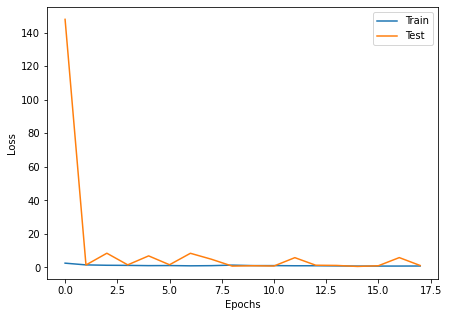

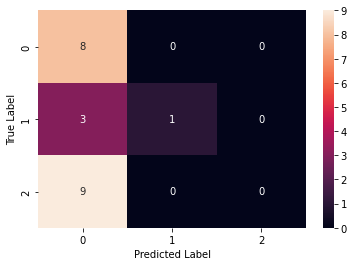

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.2516245203358785, Test Loss: 2.0102360248565674
Epoch 2-- Train Loss:1.2893973219962347, Test Loss: 408.9942321777344
Epoch 3-- Train Loss:1.3164712304160708, Test Loss: 1.1298693418502808
Epoch 4-- Train Loss:1.1950675674847193, Test Loss: 1.6591476202011108
Epoch 5-- Train Loss:1.2081337429228283, Test Loss: 1.2191437482833862
Epoch 6-- Train Loss:1.2002571792829604, Test Loss: 1.4738388061523438
Epoch 7-- Train Loss:1.1944098245529902, Test Loss: 1.1542167663574219
Epoch 8-- Train Loss:1.134408025514512, Test Loss: 2.8537938594818115
Epoch 9-- Train Loss:1.1514201958974202, Test Loss: 1.5360201597213745
Epoch 10-- Train Loss:1.1031472143672763, Test Loss: 1.5317416191101074
Epoch 11-- Train Loss:1.1564845102173942, Test Loss: 172.3000030517578
Epoch 12-- Train Loss:1.1163228750228882, Test Loss: 2.721956253051758
Epoch 13-- Train Loss:1.1133018788837252, Test Loss: 2.305304765701294
Epoch 14-- Train Loss

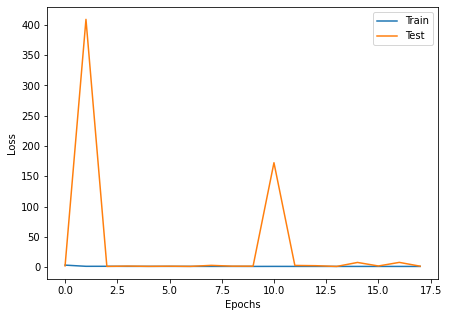

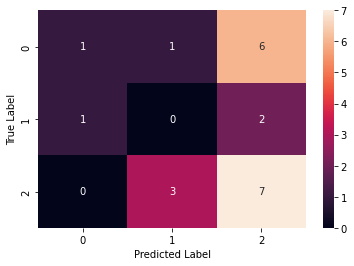

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.42478193839391, Test Loss: 36.26700973510742
Epoch 2-- Train Loss:1.3054484128952026, Test Loss: 1.0776283740997314
Epoch 3-- Train Loss:1.2101330274627322, Test Loss: 1.365701675415039
Epoch 4-- Train Loss:1.2041033591542925, Test Loss: 1.2658627033233643
Epoch 5-- Train Loss:1.200458600407555, Test Loss: 1.1952041387557983
Epoch 6-- Train Loss:1.1438054953302657, Test Loss: 0.9791288375854492
Epoch 7-- Train Loss:1.1500393265769595, Test Loss: 1.1088659763336182
Epoch 8-- Train Loss:1.180864950021108, Test Loss: 1.1154121160507202
Epoch 9-- Train Loss:1.1459016374179296, Test Loss: 1.041591763496399
Epoch 10-- Train Loss:1.1538535157839458, Test Loss: 1.0378391742706299
Epoch 11-- Train Loss:1.117628622622717, Test Loss: 0.9974783658981323
Epoch 12-- Train Loss:1.1445690506980533, Test Loss: 0.9636184573173523
Epoch 13-- Train Loss:1.0913524613493966, Test Loss: 1.090806245803833
Epoch 14-- Train Loss:1.1

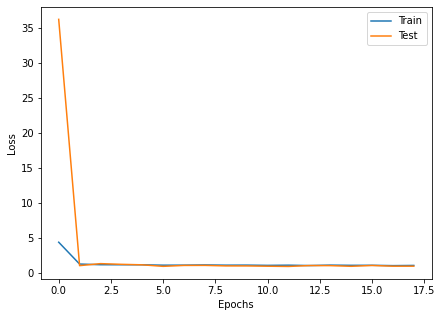

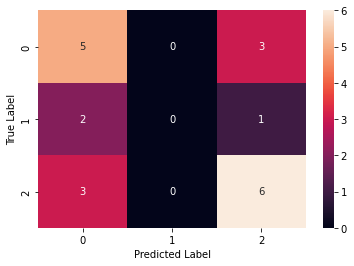

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.6169292699723017, Test Loss: 300.6617431640625
Epoch 2-- Train Loss:1.432742138703664, Test Loss: 1.141562819480896
Epoch 3-- Train Loss:1.2305370512462797, Test Loss: 32.50796127319336
Epoch 4-- Train Loss:1.3612893904958452, Test Loss: 25.324935913085938
Epoch 5-- Train Loss:1.1794252140181405, Test Loss: 1.3110153675079346
Epoch 6-- Train Loss:1.0842073673293704, Test Loss: 4.2982916831970215
Epoch 7-- Train Loss:1.1649287825538999, Test Loss: 0.9742660522460938
Epoch 8-- Train Loss:0.890381783246994, Test Loss: 0.952881932258606
Epoch 9-- Train Loss:0.9396911206699553, Test Loss: 1.1133482456207275
Epoch 10-- Train Loss:1.1137333313624065, Test Loss: 0.8551536798477173
Epoch 11-- Train Loss:0.956661574897312, Test Loss: 1.1814597845077515
Epoch 12-- Train Loss:0.9587404756318956, Test Loss: 0.9132855534553528
Epoch 13-- Train Loss:1.1658088848704384, Test Loss: 0.8650063276290894
Epoch 14-- Train Loss:0

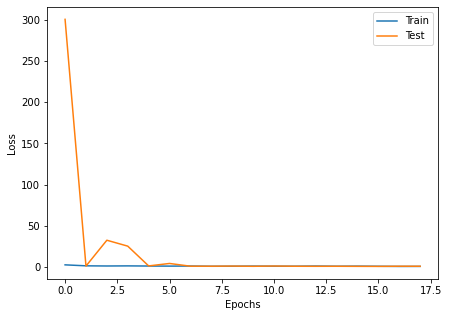

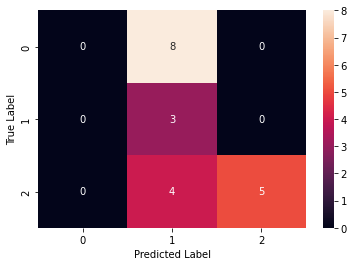

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.301624147664933, Test Loss: 103.07879638671875
Epoch 2-- Train Loss:1.3280080074355716, Test Loss: 1.4198813438415527
Epoch 3-- Train Loss:1.145505876768203, Test Loss: 1.0779905319213867
Epoch 4-- Train Loss:0.9850790074893406, Test Loss: 1.7771375179290771
Epoch 5-- Train Loss:0.9243554912862324, Test Loss: 3.133225440979004
Epoch 6-- Train Loss:0.9052149483135769, Test Loss: 1.7104876041412354
Epoch 7-- Train Loss:0.8674669719877697, Test Loss: 2.352381944656372
Epoch 8-- Train Loss:0.8353099865572793, Test Loss: 1.4219717979431152
Epoch 9-- Train Loss:0.843845709448769, Test Loss: 1.755173683166504
Epoch 10-- Train Loss:0.7620893340735209, Test Loss: 1.0508415699005127
Epoch 11-- Train Loss:0.9001466795092538, Test Loss: 1.3932318687438965
Epoch 12-- Train Loss:0.7602406264770598, Test Loss: 1.239959955215454
Epoch 13-- Train Loss:0.8559453373863584, Test Loss: 1.2171019315719604
Epoch 14-- Train Loss:0

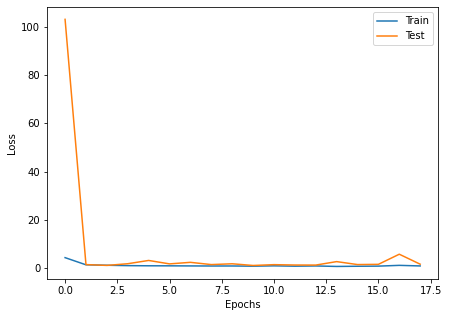

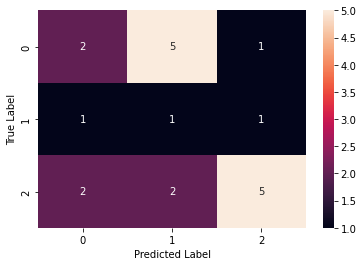

Starting testing
Training Complete
{'0': {'f1-score': '0.345±0.215',
       'precision': '0.455±0.321',
       'recall': '0.425±0.359',
       'support': 8},
 '1': {'f1-score': '0.237±0.137',
       'precision': '0.309±0.353',
       'recall': '0.383±0.332',
       'support': 4},
 '2': {'f1-score': '0.495±0.254',
       'precision': '0.573±0.339',
       'recall': '0.473±0.253',
       'support': 9},
 'accuracy': '0.441±0.056',
 'macro avg': {'f1-score': '0.359±0.026',
               'precision': '0.446±0.065',
               'recall': '0.427±0.049',
               'support': 21},
 'weighted avg': {'f1-score': '0.399±0.071',
                  'precision': '0.491±0.094',
                  'recall': '0.441±0.056',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.078, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.8044577945362437, Test Loss: 82144.2265625
Epoch 2-- Train Loss:1.7029371586712925, Test Loss: 11.593505859375
Epoch 3-- Train Loss:

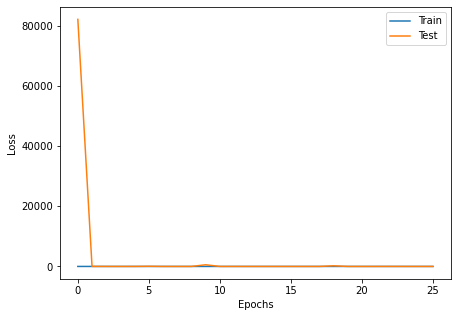

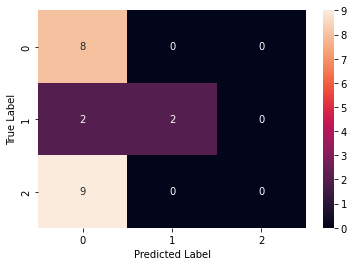

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.9376637177033857, Test Loss: 2807.587158203125
Epoch 2-- Train Loss:1.6639358008449727, Test Loss: 5.3021745681762695
Epoch 3-- Train Loss:1.3026759407737039, Test Loss: 15.302291870117188
Epoch 4-- Train Loss:1.3391570936549793, Test Loss: 1.5591474771499634
Epoch 5-- Train Loss:1.1890432184392756, Test Loss: 1.5947233438491821
Epoch 6-- Train Loss:1.2475791573524475, Test Loss: 16.363576889038086
Epoch 7-- Train Loss:1.2464885765855962, Test Loss: 3.5314152240753174
Epoch 8-- Train Loss:1.1866500702771274, Test Loss: 1.6593300104141235
Epoch 9-- Train Loss:1.1038150137121028, Test Loss: 2.2054283618927
Epoch 10-- Train Loss:1.2142048532312566, Test Loss: 1.7157058715820312
Epoch 11-- Train Loss:1.1236145279624246, Test Loss: 2.438277006149292
Epoch 12-- Train Loss:1.45846397226507, Test Loss: 1.2314153909683228
Epoch 13-- Train Loss:1.2011354511434382, Test Loss: 1.2830592393875122
Epoch 14-- Train Loss:1

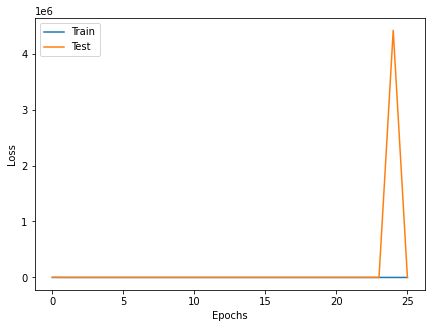

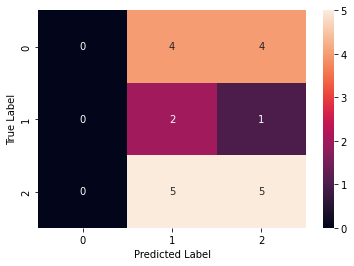

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.358172091570768, Test Loss: 2.522308111190796
Epoch 2-- Train Loss:1.0835202661427585, Test Loss: 1.0869386196136475
Epoch 3-- Train Loss:1.1332485729997808, Test Loss: 2.669415235519409
Epoch 4-- Train Loss:0.9150247519666498, Test Loss: 1.6593014001846313
Epoch 5-- Train Loss:1.0362832112745806, Test Loss: 0.7848955988883972
Epoch 6-- Train Loss:0.8566582500934601, Test Loss: 0.9734900593757629
Epoch 7-- Train Loss:1.1969006928530606, Test Loss: 0.9441444277763367
Epoch 8-- Train Loss:0.8772098259492354, Test Loss: 2.2554140090942383
Epoch 9-- Train Loss:1.108003106984225, Test Loss: 0.8094449639320374
Epoch 10-- Train Loss:0.8511757742274891, Test Loss: 0.7788856625556946
Epoch 11-- Train Loss:1.0177285183559766, Test Loss: 1.0779047012329102
Epoch 12-- Train Loss:0.8910087292844598, Test Loss: 1.0097095966339111
Epoch 13-- Train Loss:0.7566015070134943, Test Loss: 0.9214348793029785
Epoch 14-- Train Los

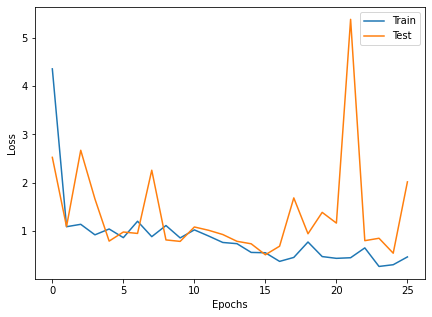

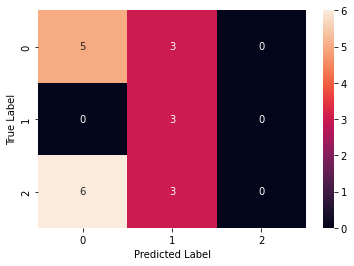

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.166992577639493, Test Loss: 4.4131622314453125
Epoch 2-- Train Loss:1.418872128833424, Test Loss: 1.8547109365463257
Epoch 3-- Train Loss:1.2952261025255376, Test Loss: 2.9990427494049072
Epoch 4-- Train Loss:1.0180349620905789, Test Loss: 1.0123943090438843
Epoch 5-- Train Loss:1.0153716145591303, Test Loss: 5.2288312911987305
Epoch 6-- Train Loss:1.0177862725474618, Test Loss: 0.875819742679596
Epoch 7-- Train Loss:0.9421314542943781, Test Loss: 3.801530122756958
Epoch 8-- Train Loss:0.9279348200017755, Test Loss: 0.6882128715515137
Epoch 9-- Train Loss:0.9128052267161283, Test Loss: 3.9162180423736572
Epoch 10-- Train Loss:0.8819809772751548, Test Loss: 0.7752153277397156
Epoch 11-- Train Loss:0.7845163914290342, Test Loss: 2.2485971450805664
Epoch 12-- Train Loss:0.6414817761291157, Test Loss: 0.7876474857330322
Epoch 13-- Train Loss:0.7245350480079651, Test Loss: 1.1923922300338745
Epoch 14-- Train Los

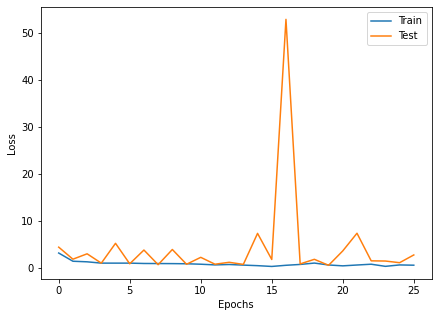

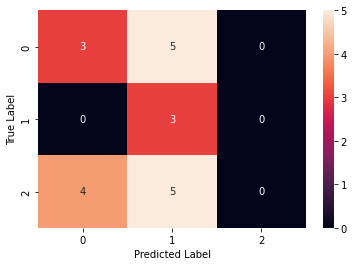

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.2794277397069065, Test Loss: 96996.6015625
Epoch 2-- Train Loss:1.6624129143628208, Test Loss: 34.36445236206055
Epoch 3-- Train Loss:1.0989284298636697, Test Loss: 2.771062135696411
Epoch 4-- Train Loss:0.9998159354383295, Test Loss: 3.4642183780670166
Epoch 5-- Train Loss:0.9167219996452332, Test Loss: 2.9056434631347656
Epoch 6-- Train Loss:1.092750142921101, Test Loss: 1.6257400512695312
Epoch 7-- Train Loss:0.8015242137692191, Test Loss: 1.2590752840042114
Epoch 8-- Train Loss:0.7544287768277255, Test Loss: 1.1972662210464478
Epoch 9-- Train Loss:0.947323045947335, Test Loss: 1.3092743158340454
Epoch 10-- Train Loss:0.7998316965319894, Test Loss: 1.6720212697982788
Epoch 11-- Train Loss:0.8011765534227545, Test Loss: 93.77172088623047
Epoch 12-- Train Loss:1.4871137575669722, Test Loss: 1.934248447418213
Epoch 13-- Train Loss:1.3702337525107644, Test Loss: 1.3277673721313477
Epoch 14-- Train Loss:1.400

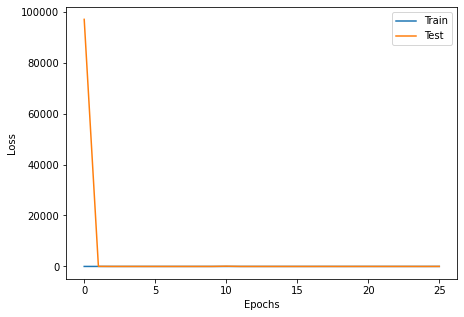

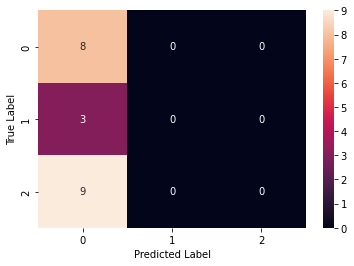

Starting testing
Training Complete
{'0': {'f1-score': '0.418±0.219',
       'precision': '0.341±0.171',
       'recall': '0.6±0.382',
       'support': 8},
 '1': {'f1-score': '0.37±0.222',
       'precision': '0.353±0.341',
       'recall': '0.633±0.371',
       'support': 4},
 '2': {'f1-score': '0.095±0.19',
       'precision': '0.091±0.182',
       'recall': '0.1±0.2',
       'support': 9},
 'accuracy': '0.382±0.061',
 'macro avg': {'f1-score': '0.294±0.079',
               'precision': '0.262±0.114',
               'recall': '0.444±0.075',
               'support': 21},
 'weighted avg': {'f1-score': '0.271±0.048',
                  'precision': '0.239±0.063',
                  'recall': '0.382±0.061',
                  'support': 21}}
{'num_epochs': 6, 'lr': 0.048, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.491684309073857, Test Loss: 298.25103759765625
Epoch 2-- Train Loss:1.4280293541295188, Test Loss: 3.5891096591949463
Epoch 3-- Train Loss:1.

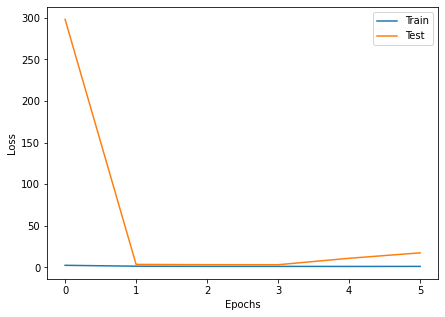

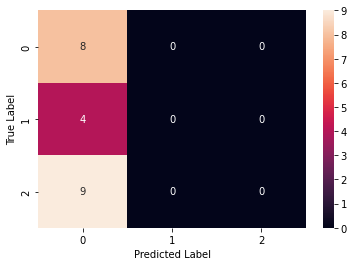

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.3381165649209703, Test Loss: 1.8433796167373657
Epoch 2-- Train Loss:1.3606472583044142, Test Loss: 3.8401858806610107
Epoch 3-- Train Loss:1.2160846363930475, Test Loss: 2.3995590209960938
Epoch 4-- Train Loss:0.9843603784129733, Test Loss: 13.703827857971191
Epoch 5-- Train Loss:0.9801293497993833, Test Loss: 9.723126411437988
Epoch 6-- Train Loss:1.050040019409997, Test Loss: 6.079090595245361


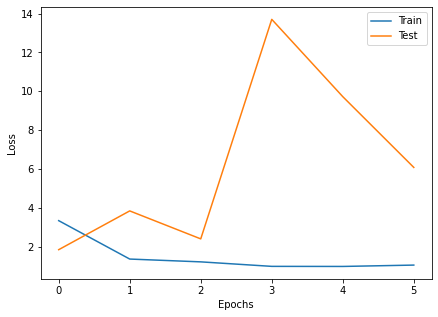

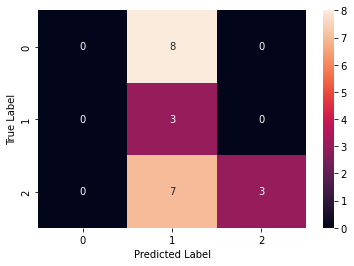

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.6289823324907395, Test Loss: 34.38616180419922
Epoch 2-- Train Loss:1.4663247537045252, Test Loss: 7.381718635559082
Epoch 3-- Train Loss:1.3022967662130083, Test Loss: 1.12909734249115
Epoch 4-- Train Loss:1.3005898566473097, Test Loss: 1.200028896331787
Epoch 5-- Train Loss:1.2997644146283467, Test Loss: 1.0723528861999512
Epoch 6-- Train Loss:1.2052632428350902, Test Loss: 1.0675840377807617


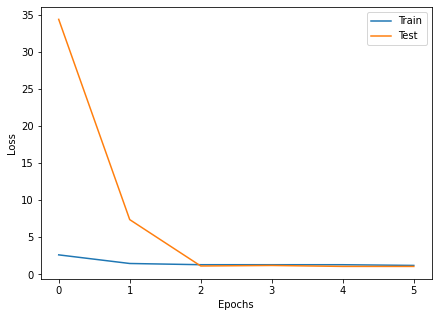

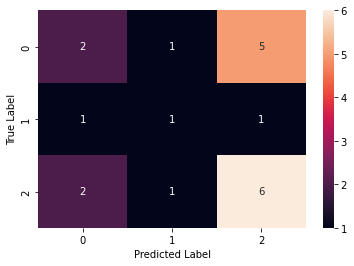

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:2.576572883696783, Test Loss: 84.3505630493164
Epoch 2-- Train Loss:1.423622483298892, Test Loss: 1.3237344026565552
Epoch 3-- Train Loss:1.355511174315498, Test Loss: 2.369875192642212
Epoch 4-- Train Loss:1.365740458170573, Test Loss: 1.1902990341186523
Epoch 5-- Train Loss:1.1952461798985798, Test Loss: 1.2985213994979858
Epoch 6-- Train Loss:1.1549277844883146, Test Loss: 1.1041462421417236


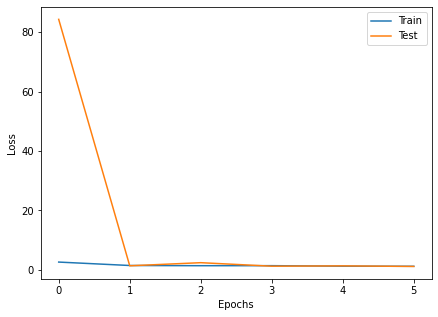

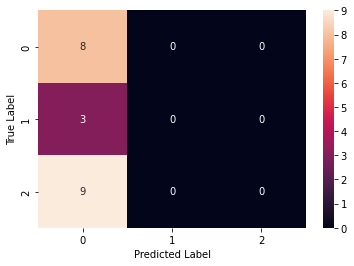

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.1665506618363515, Test Loss: 238.926025390625
Epoch 2-- Train Loss:1.2401925722757976, Test Loss: 2.5059854984283447
Epoch 3-- Train Loss:1.1810128816536494, Test Loss: 1.6260108947753906
Epoch 4-- Train Loss:0.993257577930178, Test Loss: 1.2274832725524902
Epoch 5-- Train Loss:0.9963457385698954, Test Loss: 1.157334566116333
Epoch 6-- Train Loss:1.034555155606497, Test Loss: 1.3763917684555054


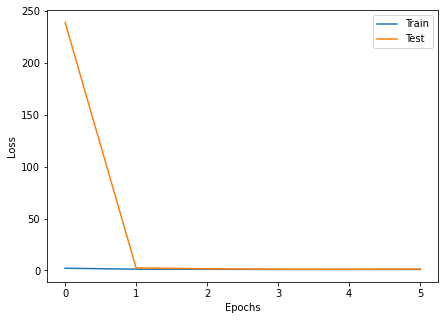

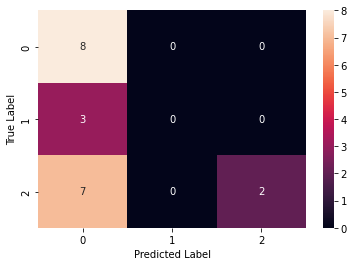

Starting testing
Training Complete
{'0': {'f1-score': '0.405±0.233',
       'precision': '0.312±0.16',
       'recall': '0.65±0.436',
       'support': 8},
 '1': {'f1-score': '0.114±0.14',
       'precision': '0.083±0.105',
       'recall': '0.267±0.389',
       'support': 4},
 '2': {'f1-score': '0.291±0.253',
       'precision': '0.52±0.449',
       'recall': '0.238±0.245',
       'support': 9},
 'accuracy': '0.403±0.072',
 'macro avg': {'f1-score': '0.27±0.083',
               'precision': '0.305±0.147',
               'recall': '0.385±0.043',
               'support': 21},
 'weighted avg': {'f1-score': '0.31±0.096',
                  'precision': '0.375±0.191',
                  'recall': '0.403±0.072',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.014000000000000002, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.4158670902252197, Test Loss: 2.9655327796936035
Epoch 2-- Train Loss:1.4588144421577454, Test Loss: 1.57886803150177
Epoch

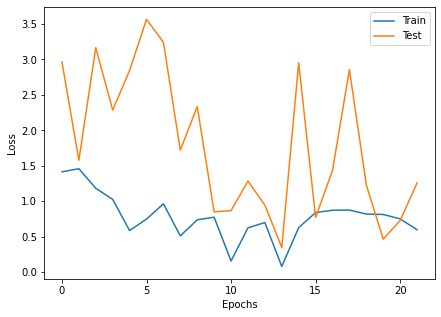

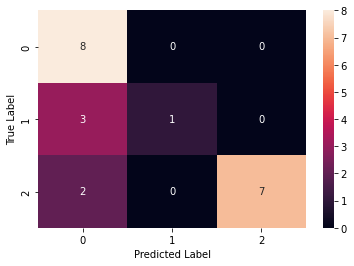

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.426540474096934, Test Loss: 3.400754928588867
Epoch 2-- Train Loss:1.3794318636258442, Test Loss: 3.4785122871398926
Epoch 3-- Train Loss:1.5112183094024658, Test Loss: 3.9381935596466064
Epoch 4-- Train Loss:0.956760361790657, Test Loss: 2.3258771896362305
Epoch 5-- Train Loss:0.532344381014506, Test Loss: 3.095677137374878
Epoch 6-- Train Loss:0.7047959392269453, Test Loss: 2.322488784790039
Epoch 7-- Train Loss:0.5225850573430458, Test Loss: 2.393772840499878
Epoch 8-- Train Loss:0.30978117417544127, Test Loss: 1.2188119888305664
Epoch 9-- Train Loss:0.6688954941928387, Test Loss: 3.2267980575561523
Epoch 10-- Train Loss:0.4824329148977995, Test Loss: 1.4141883850097656
Epoch 11-- Train Loss:0.7775186536212763, Test Loss: 2.9476184844970703
Epoch 12-- Train Loss:0.528556151005129, Test Loss: 2.0958385467529297
Epoch 13-- Train Loss:0.6993502168916166, Test Loss: 1.0833892822265625
Epoch 14-- Train Loss:0

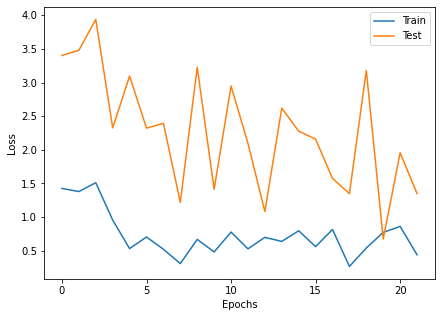

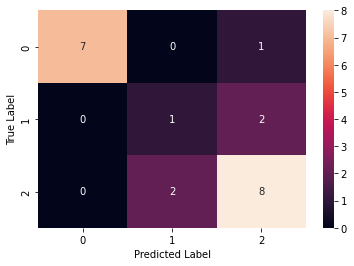

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0645610292752583, Test Loss: 1.2847408056259155
Epoch 2-- Train Loss:1.0895148118336995, Test Loss: 2.494715690612793
Epoch 3-- Train Loss:0.9567412734031677, Test Loss: 0.8085139989852905
Epoch 4-- Train Loss:0.6640656838814417, Test Loss: 1.933383584022522
Epoch 5-- Train Loss:0.6971889237562815, Test Loss: 1.4890613555908203
Epoch 6-- Train Loss:0.49262377619743347, Test Loss: 1.942884922027588
Epoch 7-- Train Loss:0.48883717879652977, Test Loss: 0.9639592170715332
Epoch 8-- Train Loss:0.14070980933805308, Test Loss: 0.5014094710350037
Epoch 9-- Train Loss:0.08288925047963858, Test Loss: 0.621174693107605
Epoch 10-- Train Loss:0.046559050058325134, Test Loss: 1.2321738004684448
Epoch 11-- Train Loss:0.13274038769304752, Test Loss: 1.353297472000122
Epoch 12-- Train Loss:0.3801517753551404, Test Loss: 2.875425338745117
Epoch 13-- Train Loss:0.37727716627220315, Test Loss: 1.707550048828125
Epoch 14-- Trai

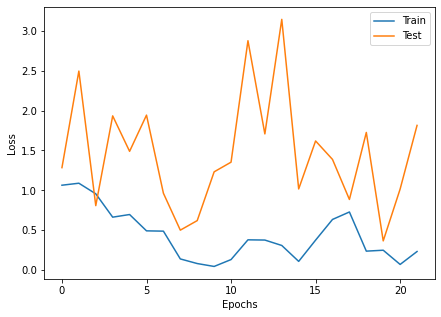

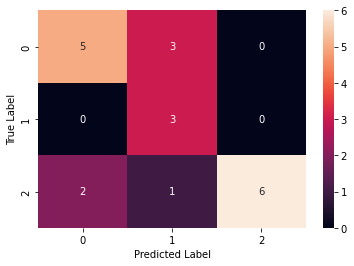

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.0148501346508663, Test Loss: 1.7306491136550903
Epoch 2-- Train Loss:1.0231929471095402, Test Loss: 3.260995864868164
Epoch 3-- Train Loss:1.1606188317139943, Test Loss: 1.2684948444366455
Epoch 4-- Train Loss:0.4624609549840291, Test Loss: 0.6355276107788086
Epoch 5-- Train Loss:0.3085936481753985, Test Loss: 0.6914503574371338
Epoch 6-- Train Loss:0.2755368500947952, Test Loss: 2.6612629890441895
Epoch 7-- Train Loss:0.28756186614433926, Test Loss: 0.4283828139305115
Epoch 8-- Train Loss:0.1836362692217032, Test Loss: 1.3633348941802979
Epoch 9-- Train Loss:0.5648572038238248, Test Loss: 1.7977304458618164
Epoch 10-- Train Loss:0.5713935780028502, Test Loss: 1.9619507789611816
Epoch 11-- Train Loss:0.5031481646001339, Test Loss: 0.8652113676071167
Epoch 12-- Train Loss:0.2927019378791253, Test Loss: 1.4877188205718994
Epoch 13-- Train Loss:0.13387075377007326, Test Loss: 1.3889439105987549
Epoch 14-- Trai

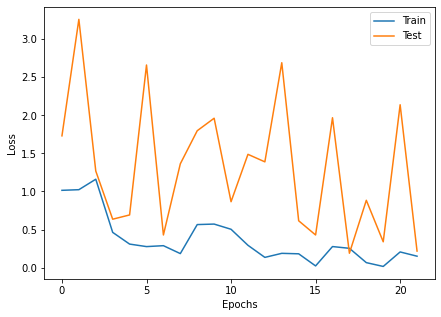

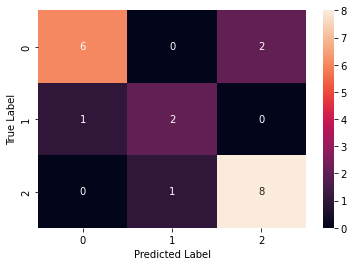

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.4762409726778667, Test Loss: 1.3918198347091675
Epoch 2-- Train Loss:1.2646487355232239, Test Loss: 1.9722644090652466
Epoch 3-- Train Loss:1.346727614601453, Test Loss: 1.726956844329834
Epoch 4-- Train Loss:0.4229789500435193, Test Loss: 0.7145926356315613
Epoch 5-- Train Loss:0.33457904557387036, Test Loss: 1.358461618423462
Epoch 6-- Train Loss:0.398897943397363, Test Loss: 3.8159236907958984
Epoch 7-- Train Loss:0.4231251999735832, Test Loss: 3.661167621612549
Epoch 8-- Train Loss:0.5608203827093045, Test Loss: 4.6169257164001465
Epoch 9-- Train Loss:0.42275965586304665, Test Loss: 1.5868113040924072
Epoch 10-- Train Loss:0.07209478473911683, Test Loss: 0.7909484505653381
Epoch 11-- Train Loss:0.04499878206600746, Test Loss: 0.9135388731956482
Epoch 12-- Train Loss:0.36125578948607046, Test Loss: 2.9262075424194336
Epoch 13-- Train Loss:0.4484610743820667, Test Loss: 0.766193687915802
Epoch 14-- Train 

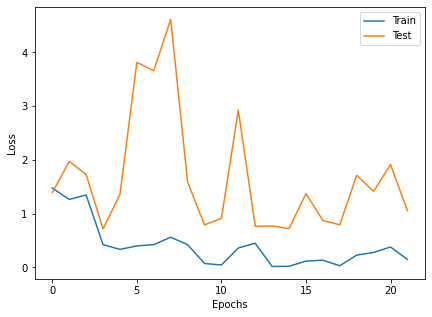

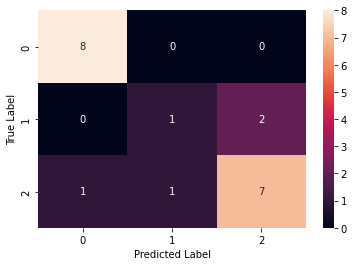

Starting testing
Training Complete
{'0': {'f1-score': '0.791±0.126',
       'precision': '0.788±0.137',
       'recall': '0.825±0.187',
       'support': 8},
 '1': {'f1-score': '0.48±0.129',
       'precision': '0.586±0.234',
       'recall': '0.517±0.281',
       'support': 4},
 '2': {'f1-score': '0.807±0.05',
       'precision': '0.853±0.084',
       'recall': '0.78±0.102',
       'support': 9},
 'accuracy': '0.754±0.057',
 'macro avg': {'f1-score': '0.693±0.046',
               'precision': '0.742±0.081',
               'recall': '0.707±0.036',
               'support': 21},
 'weighted avg': {'f1-score': '0.748±0.053',
                  'precision': '0.788±0.047',
                  'recall': '0.754±0.057',
                  'support': 21}}


In [25]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='resnet50'
    results = train_model(name=name, dataset=dataset, k_folds =5,  device=device, **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 3.3 Big Transfer (BiT)

The model was proposed in this paper: https://arxiv.org/abs/1912.11370







In [43]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 46, 'lr': 0.0001, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.3486628631750743, Test Loss: 1.2714197635650635
Epoch 2-- Train Loss:1.0789705117543538, Test Loss: 1.3415467739105225
Epoch 3-- Train Loss:1.1622687081495922, Test Loss: 0.7432994246482849
Epoch 4-- Train Loss:0.9552438159783682, Test Loss: 0.9491682648658752
Epoch 5-- Train Loss:0.8445883889993032, Test Loss: 1.1346728801727295
Epoch 6-- Train Loss:0.804964691400528, Test Loss: 0.8646690249443054
Epoch 7-- Train Loss:0.6943607280651728, Test Loss: 0.714041531085968
Epoch 8-- Train Loss:0.7045531074206034, Test Loss: 0.7231897711753845
Epoch 9-- Train Loss:0.6844158371289571, Test Loss: 0.39315682649612427
Epoch 10-- Train Loss:0.6455301543076833, Test Loss: 0.4560553729534149
Epoch 11-- Train Loss:0.5019873641431332, Test Loss: 0.5573620796203613
Epoch 12-- Train Loss:0.5998219350973765, Test Loss: 0.8679092526435852
Epoch 13-- Train Loss:0.6540543437004089, Test Loss: 0.

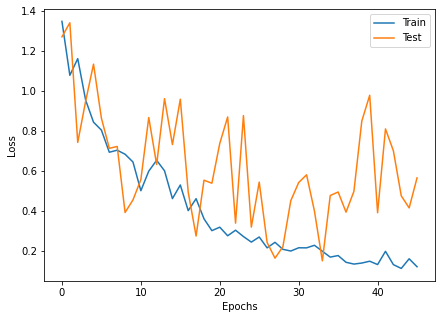

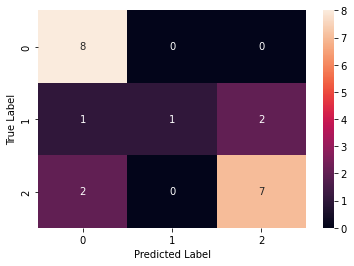

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.5225254893302917, Test Loss: 1.2647398710250854
Epoch 2-- Train Loss:1.147114376227061, Test Loss: 0.5858713984489441
Epoch 3-- Train Loss:1.213329553604126, Test Loss: 1.2105485200881958
Epoch 4-- Train Loss:0.9822944899400076, Test Loss: 1.2276222705841064
Epoch 5-- Train Loss:0.8965856929620107, Test Loss: 0.8639350533485413
Epoch 6-- Train Loss:0.8831270138422648, Test Loss: 0.9648733735084534
Epoch 7-- Train Loss:0.7020261983076731, Test Loss: 1.0296969413757324
Epoch 8-- Train Loss:0.683716873327891, Test Loss: 0.8030332922935486
Epoch 9-- Train Loss:0.621082623799642, Test Loss: 1.625463843345642
Epoch 10-- Train Loss:0.5604476481676102, Test Loss: 0.9027107357978821
Epoch 11-- Train Loss:0.5198149730761846, Test Loss: 1.083030343055725
Epoch 12-- Train Loss:0.49936364591121674, Test Loss: 1.0042273998260498
Epoch 13-- Train Loss:0.48717642823855084, Test Loss: 0.3704129159450531
Epoch 14-- Train Los

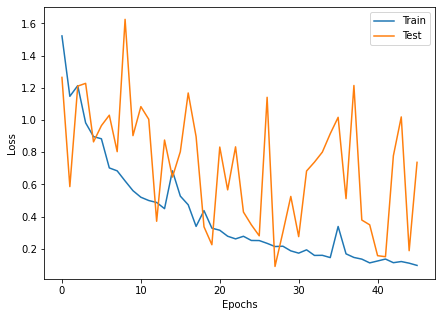

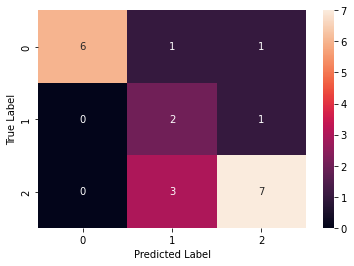

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.0949771702289581, Test Loss: 1.134998083114624
Epoch 2-- Train Loss:1.0948070685068767, Test Loss: 0.6421052813529968
Epoch 3-- Train Loss:0.9091847538948059, Test Loss: 1.378979206085205
Epoch 4-- Train Loss:0.8658732374509176, Test Loss: 0.5785293579101562
Epoch 5-- Train Loss:0.813297301530838, Test Loss: 1.0234944820404053
Epoch 6-- Train Loss:0.6690882245699564, Test Loss: 0.9266753792762756
Epoch 7-- Train Loss:0.6774499515692393, Test Loss: 0.9038825631141663
Epoch 8-- Train Loss:0.6187727500995001, Test Loss: 0.7966030240058899
Epoch 9-- Train Loss:0.5790406614542007, Test Loss: 0.7164974212646484
Epoch 10-- Train Loss:0.5540404518445333, Test Loss: 0.8778901100158691
Epoch 11-- Train Loss:0.5150095224380493, Test Loss: 0.7516739368438721
Epoch 12-- Train Loss:0.49194525678952533, Test Loss: 0.9363875389099121
Epoch 13-- Train Loss:0.4223761012156804, Test Loss: 0.6674624681472778
Epoch 14-- Train L

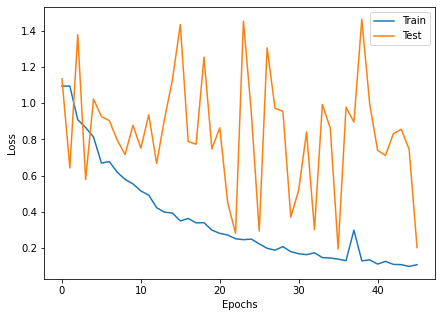

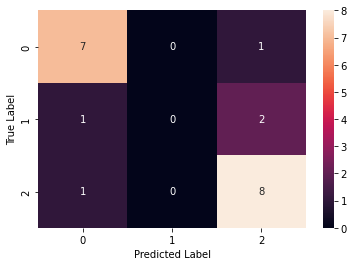

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.1007948815822601, Test Loss: 0.5438940525054932
Epoch 2-- Train Loss:1.0292345583438873, Test Loss: 1.2030556201934814
Epoch 3-- Train Loss:0.9384521842002869, Test Loss: 0.9090700745582581
Epoch 4-- Train Loss:0.8991547723611196, Test Loss: 0.5649817585945129
Epoch 5-- Train Loss:0.8120449384053549, Test Loss: 0.908859372138977
Epoch 6-- Train Loss:0.7897868653138479, Test Loss: 0.2828945517539978
Epoch 7-- Train Loss:0.6806963781515757, Test Loss: 0.5487958192825317
Epoch 8-- Train Loss:0.6514156957467397, Test Loss: 0.7561713457107544
Epoch 9-- Train Loss:0.6556326150894165, Test Loss: 0.7100780010223389
Epoch 10-- Train Loss:0.5447972963253657, Test Loss: 0.37729230523109436
Epoch 11-- Train Loss:0.487045057117939, Test Loss: 0.8194249272346497
Epoch 12-- Train Loss:0.5940054853757223, Test Loss: 0.7675544619560242
Epoch 13-- Train Loss:0.5114011863867441, Test Loss: 0.23054663836956024
Epoch 14-- Train

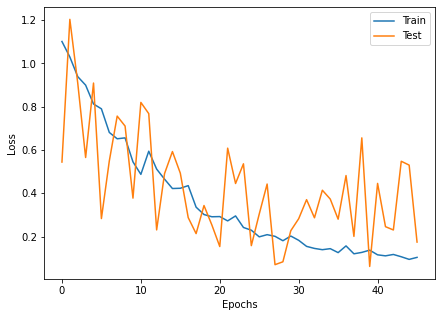

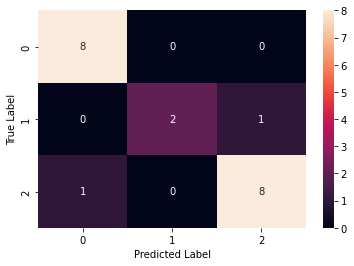

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.3168006936709087, Test Loss: 1.4329901933670044
Epoch 2-- Train Loss:1.1974767446517944, Test Loss: 0.9831809401512146
Epoch 3-- Train Loss:1.1505682269732158, Test Loss: 1.0137817859649658
Epoch 4-- Train Loss:0.9496896266937256, Test Loss: 0.8787071108818054
Epoch 5-- Train Loss:0.9185877243677775, Test Loss: 0.8924341201782227
Epoch 6-- Train Loss:0.8049295047918955, Test Loss: 1.0617341995239258
Epoch 7-- Train Loss:0.7870059212048849, Test Loss: 1.4282994270324707
Epoch 8-- Train Loss:0.6870772341887156, Test Loss: 0.9166424870491028
Epoch 9-- Train Loss:0.6241110066572825, Test Loss: 0.7825220227241516
Epoch 10-- Train Loss:0.6003435850143433, Test Loss: 1.013666033744812
Epoch 11-- Train Loss:0.6856103340784708, Test Loss: 1.1203396320343018
Epoch 12-- Train Loss:0.5760970165332159, Test Loss: 0.9633306264877319
Epoch 13-- Train Loss:0.48204222818215686, Test Loss: 0.7351491451263428
Epoch 14-- Train

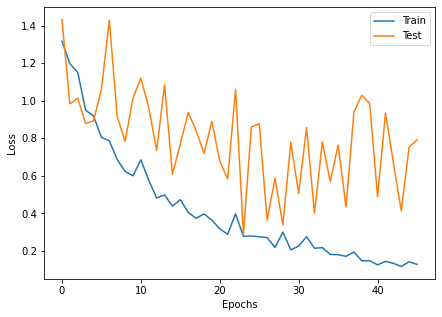

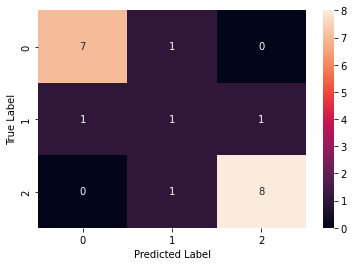

Starting testing
Training Complete
{'0': {'f1-score': '0.855±0.037',
       'precision': '0.822±0.037',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.46±0.293',
       'precision': '0.483±0.351',
       'recall': '0.5±0.333',
       'support': 4},
 '2': {'f1-score': '0.787±0.071',
       'precision': '0.829±0.102',
       'recall': '0.764±0.116',
       'support': 9},
 'accuracy': '0.775±0.063',
 'macro avg': {'f1-score': '0.701±0.107',
               'precision': '0.711±0.134',
               'recall': '0.721±0.1',
               'support': 21},
 'weighted avg': {'f1-score': '0.764±0.064',
                  'precision': '0.776±0.084',
                  'recall': '0.775±0.063',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0081, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:7.296430091063182, Test Loss: 4.5580973625183105
Epoch 2-- Train Loss:3.0199666718641915, Test Loss: 3.5545599460601807
Epoch 3-- Train Los

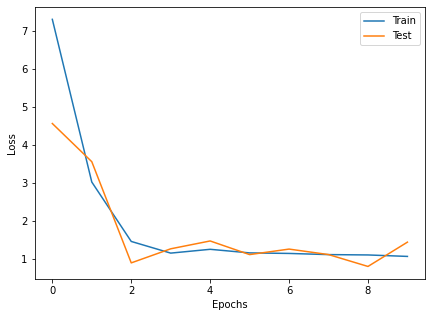

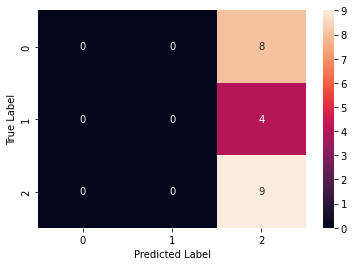

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:7.770596186319987, Test Loss: 4.055522918701172
Epoch 2-- Train Loss:1.9365350008010864, Test Loss: 1.6158970594406128
Epoch 3-- Train Loss:1.3488529721895854, Test Loss: 2.392571210861206
Epoch 4-- Train Loss:1.1317206919193268, Test Loss: 1.526194453239441
Epoch 5-- Train Loss:1.152038464943568, Test Loss: 2.0156166553497314
Epoch 6-- Train Loss:1.1958091656366985, Test Loss: 1.2014515399932861
Epoch 7-- Train Loss:1.0889715949694316, Test Loss: 1.2571614980697632
Epoch 8-- Train Loss:1.539756864309311, Test Loss: 2.020402193069458
Epoch 9-- Train Loss:1.2080063025156658, Test Loss: 1.7620172500610352
Epoch 10-- Train Loss:1.169976532459259, Test Loss: 0.9212404489517212


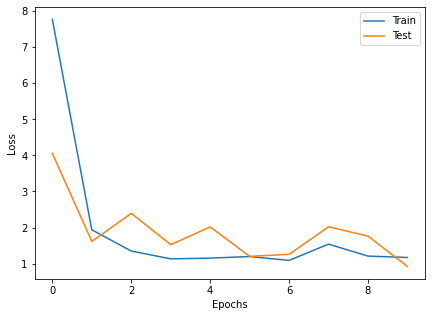

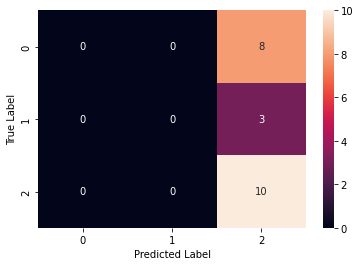

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.280856102705002, Test Loss: 4.994413375854492
Epoch 2-- Train Loss:9.692501068115234, Test Loss: 1.5572980642318726
Epoch 3-- Train Loss:1.2781525651613872, Test Loss: 0.03551774099469185
Epoch 4-- Train Loss:1.305602103471756, Test Loss: 2.2801594734191895
Epoch 5-- Train Loss:1.3483365575472515, Test Loss: 2.1024234294891357
Epoch 6-- Train Loss:1.155765563249588, Test Loss: 2.5190088748931885
Epoch 7-- Train Loss:1.2942914565404255, Test Loss: 1.163487195968628
Epoch 8-- Train Loss:1.2072066167990367, Test Loss: 1.456681489944458
Epoch 9-- Train Loss:1.18697323401769, Test Loss: 1.5215167999267578
Epoch 10-- Train Loss:1.1963168780008953, Test Loss: 1.0414658784866333


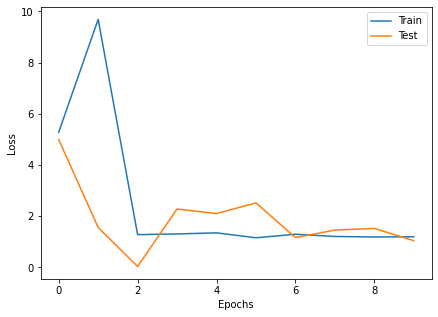

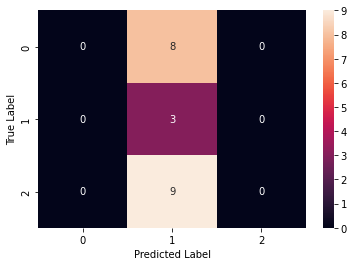

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.458109180132548, Test Loss: 5.868168830871582
Epoch 2-- Train Loss:2.2825717826684317, Test Loss: 2.7428205013275146
Epoch 3-- Train Loss:1.3360570073127747, Test Loss: 0.8840100765228271
Epoch 4-- Train Loss:1.202545960744222, Test Loss: 1.8268394470214844
Epoch 5-- Train Loss:1.2899110913276672, Test Loss: 3.1136646270751953
Epoch 6-- Train Loss:1.2911428610483806, Test Loss: 0.7477536797523499
Epoch 7-- Train Loss:1.116535594065984, Test Loss: 1.0053150653839111
Epoch 8-- Train Loss:1.0616358419259389, Test Loss: 1.1229281425476074
Epoch 9-- Train Loss:1.4778303106625874, Test Loss: 1.692916750907898
Epoch 10-- Train Loss:1.0869020919005077, Test Loss: 1.4183323383331299


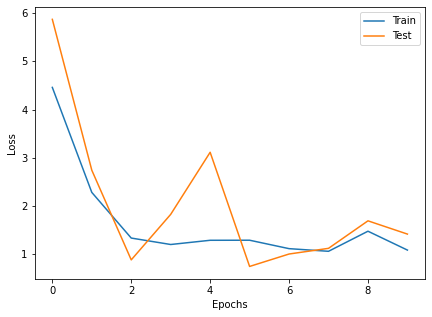

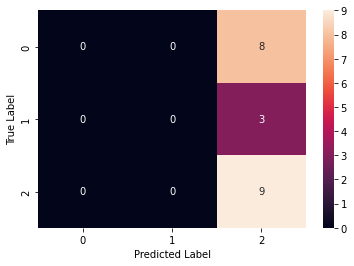

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:10.582426309585571, Test Loss: 11.803624153137207
Epoch 2-- Train Loss:4.962173044681549, Test Loss: 6.313303470611572
Epoch 3-- Train Loss:2.1124864319960275, Test Loss: 0.7554684281349182
Epoch 4-- Train Loss:1.1374940872192383, Test Loss: 1.8139362335205078
Epoch 5-- Train Loss:1.0520090659459431, Test Loss: 1.5015463829040527
Epoch 6-- Train Loss:1.1692936817804973, Test Loss: 1.4790621995925903
Epoch 7-- Train Loss:1.2263033787409465, Test Loss: 1.3243087530136108
Epoch 8-- Train Loss:1.0867660442988079, Test Loss: 1.518254041671753
Epoch 9-- Train Loss:0.9939661920070648, Test Loss: 1.463282585144043
Epoch 10-- Train Loss:1.0321740706761677, Test Loss: 1.5179105997085571


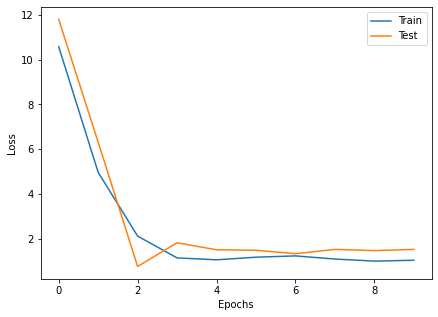

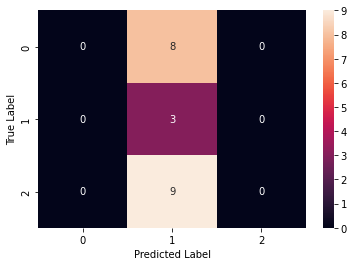

Starting testing
Training Complete
{'0': {'f1-score': '0.0±0.0',
       'precision': '0.0±0.0',
       'recall': '0.0±0.0',
       'support': 8},
 '1': {'f1-score': '0.104±0.128',
       'precision': '0.06±0.073',
       'recall': '0.4±0.49',
       'support': 4},
 '2': {'f1-score': '0.373±0.305',
       'precision': '0.271±0.222',
       'recall': '0.6±0.49',
       'support': 9},
 'accuracy': '0.331±0.149',
 'macro avg': {'f1-score': '0.159±0.059',
               'precision': '0.11±0.05',
               'recall': '0.333±0.0',
               'support': 21},
 'weighted avg': {'f1-score': '0.184±0.12',
                  'precision': '0.132±0.09',
                  'recall': '0.331±0.149',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0031, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.9888210821719396, Test Loss: 0.06576292216777802
Epoch 2-- Train Loss:1.2291521657080877, Test Loss: 0.09092985838651657
Epoch 3-- Train Loss:1.095968118735

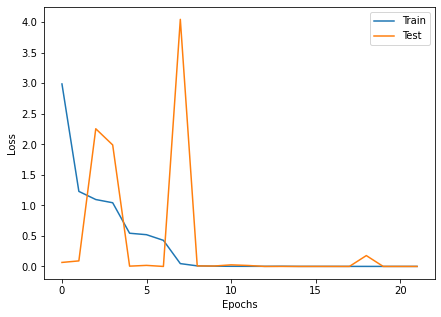

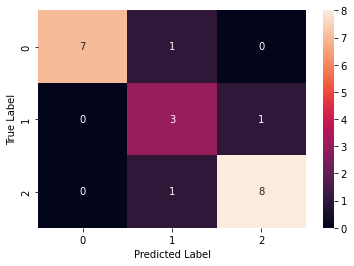

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.111549733650117, Test Loss: 0.053287576884031296
Epoch 2-- Train Loss:1.3749076880159832, Test Loss: 2.243237257003784
Epoch 3-- Train Loss:1.2091916430564154, Test Loss: 1.604275107383728
Epoch 4-- Train Loss:2.011561862060002, Test Loss: 2.149594783782959
Epoch 5-- Train Loss:1.1158180790288108, Test Loss: 1.323858618736267
Epoch 6-- Train Loss:0.849082621790114, Test Loss: 3.22708797454834
Epoch 7-- Train Loss:0.7771035823084059, Test Loss: 0.04857086017727852
Epoch 8-- Train Loss:0.8840227538631076, Test Loss: 0.14778488874435425
Epoch 9-- Train Loss:0.6071139673391978, Test Loss: 1.4754525423049927
Epoch 10-- Train Loss:0.4999655130363646, Test Loss: 1.5247951745986938
Epoch 11-- Train Loss:0.14054889081134683, Test Loss: 18.084474563598633
Epoch 12-- Train Loss:0.9135534907025951, Test Loss: 0.7433789372444153
Epoch 13-- Train Loss:0.34108557028784636, Test Loss: 0.12380912154912949
Epoch 14-- Train L

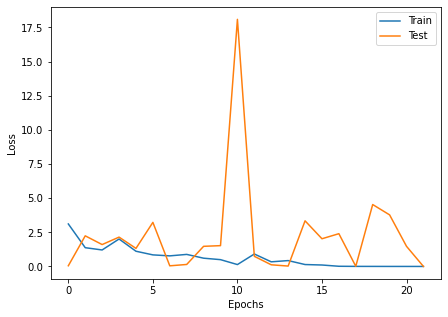

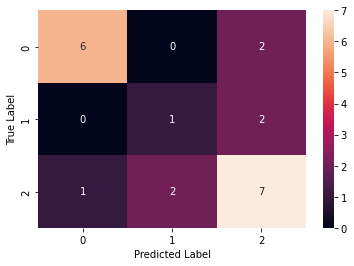

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.3835965324015844, Test Loss: 4.309764862060547
Epoch 2-- Train Loss:1.4701369078386397, Test Loss: 0.535742461681366
Epoch 3-- Train Loss:0.6478035749778861, Test Loss: 1.1429846286773682
Epoch 4-- Train Loss:0.34080694493882, Test Loss: 0.469083309173584
Epoch 5-- Train Loss:0.32845549282085684, Test Loss: 0.753711462020874
Epoch 6-- Train Loss:0.05466750360626195, Test Loss: 0.024908464401960373
Epoch 7-- Train Loss:0.012789016672676163, Test Loss: 0.6870391964912415
Epoch 8-- Train Loss:0.004060098701128958, Test Loss: 1.7028696537017822
Epoch 9-- Train Loss:0.0025169736091768193, Test Loss: 0.7205889225006104
Epoch 10-- Train Loss:0.0020486012143096774, Test Loss: 0.06169935315847397
Epoch 11-- Train Loss:0.001418368100920426, Test Loss: 0.04280022531747818
Epoch 12-- Train Loss:0.0012488895502299005, Test Loss: 1.5665267705917358
Epoch 13-- Train Loss:0.008730906592973042, Test Loss: 3.4192285537719727

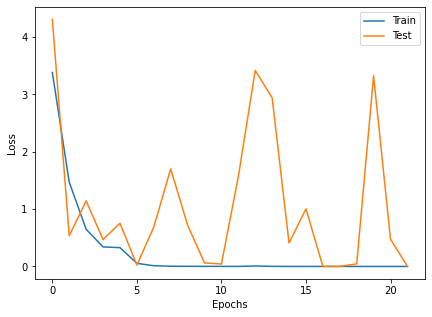

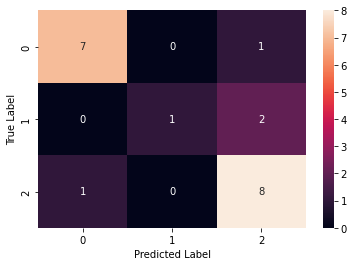

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.9365590924308416, Test Loss: 1.8631757497787476
Epoch 2-- Train Loss:1.1636986278352284, Test Loss: 1.1273486614227295
Epoch 3-- Train Loss:0.9532912380638576, Test Loss: 0.3753308355808258
Epoch 4-- Train Loss:0.6388415490232763, Test Loss: 0.5437555909156799
Epoch 5-- Train Loss:0.415555393434174, Test Loss: 0.4199301600456238
Epoch 6-- Train Loss:0.4751804695863809, Test Loss: 0.19483333826065063
Epoch 7-- Train Loss:0.22072915050999395, Test Loss: 1.29705011844635
Epoch 8-- Train Loss:0.052674693719988376, Test Loss: 0.010539893992245197
Epoch 9-- Train Loss:0.02035570565688734, Test Loss: 0.02552257664501667
Epoch 10-- Train Loss:0.003961525942681224, Test Loss: 0.06412283331155777
Epoch 11-- Train Loss:0.0054374911679977754, Test Loss: 0.7659475207328796
Epoch 12-- Train Loss:0.0025223950450752107, Test Loss: 0.4136544466018677
Epoch 13-- Train Loss:0.0021252563740182225, Test Loss: 0.0086989374831318

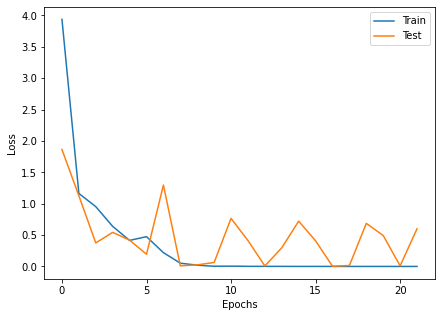

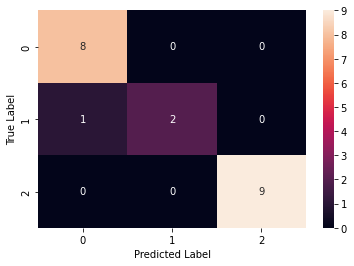

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:3.3352902687731243, Test Loss: 2.3909759521484375
Epoch 2-- Train Loss:1.0370976343041374, Test Loss: 2.2304253578186035
Epoch 3-- Train Loss:0.7246965964635214, Test Loss: 2.444366693496704
Epoch 4-- Train Loss:0.3744150880014613, Test Loss: 0.8787715435028076
Epoch 5-- Train Loss:0.5725138183417064, Test Loss: 1.052122712135315
Epoch 6-- Train Loss:1.1261795475369407, Test Loss: 0.25263628363609314
Epoch 7-- Train Loss:0.2757948532345749, Test Loss: 0.9147964715957642
Epoch 8-- Train Loss:0.12297375956993728, Test Loss: 1.010460376739502
Epoch 9-- Train Loss:0.1135346611873025, Test Loss: 1.3301275968551636
Epoch 10-- Train Loss:0.05694931958402906, Test Loss: 2.6027257442474365
Epoch 11-- Train Loss:0.007997879170857015, Test Loss: 0.9147502183914185
Epoch 12-- Train Loss:0.006741258671917464, Test Loss: 0.019155915826559067
Epoch 13-- Train Loss:0.0051657871237174345, Test Loss: 2.588637590408325
Epoch 14

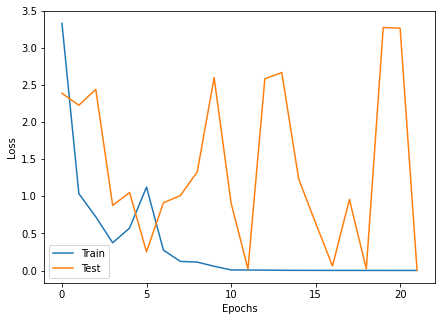

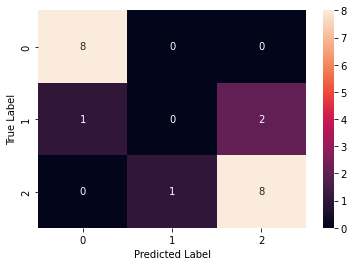

Starting testing
Training Complete
{'0': {'f1-score': '0.878±0.069',
       'precision': '0.863±0.085',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.45±0.283',
       'precision': '0.57±0.399',
       'recall': '0.417±0.269',
       'support': 4},
 '2': {'f1-score': '0.821±0.106',
       'precision': '0.817±0.118',
       'recall': '0.831±0.116',
       'support': 9},
 'accuracy': '0.795±0.096',
 'macro avg': {'f1-score': '0.716±0.126',
               'precision': '0.75±0.159',
               'recall': '0.716±0.114',
               'support': 21},
 'weighted avg': {'f1-score': '0.786±0.095',
                  'precision': '0.796±0.104',
                  'recall': '0.795±0.096',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0011, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.2240663170814514, Test Loss: 5.673562049865723
Epoch 2-- Train Loss:1.4502891798814137, Test Loss: 3.8017470836639404
Epoch 3-- Train L

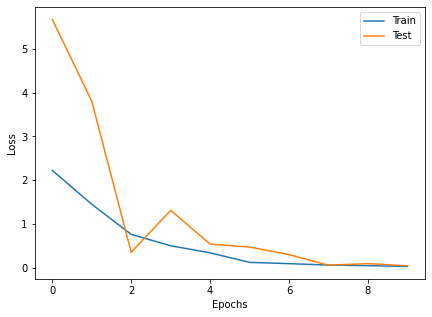

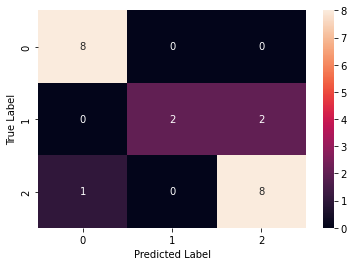

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.8806013564268749, Test Loss: 5.504518508911133
Epoch 2-- Train Loss:1.7798954745133717, Test Loss: 3.8795113563537598
Epoch 3-- Train Loss:1.4804382522900899, Test Loss: 4.914045333862305
Epoch 4-- Train Loss:1.2129620512326558, Test Loss: 3.5111210346221924
Epoch 5-- Train Loss:1.0592738166451454, Test Loss: 1.0587774515151978
Epoch 6-- Train Loss:0.34772801399230957, Test Loss: 0.640056848526001
Epoch 7-- Train Loss:0.2362851221114397, Test Loss: 0.24790066480636597
Epoch 8-- Train Loss:0.15044928466280302, Test Loss: 0.3874967694282532
Epoch 9-- Train Loss:0.07580623837808768, Test Loss: 0.32281798124313354
Epoch 10-- Train Loss:0.0705672378341357, Test Loss: 0.18000046908855438


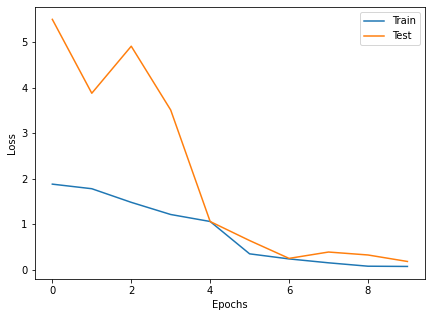

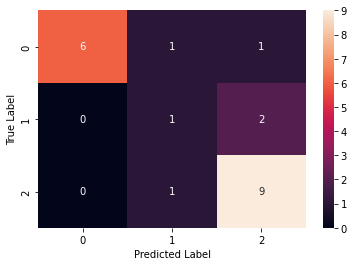

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.0790104071299234, Test Loss: 0.7122461795806885
Epoch 2-- Train Loss:1.1752313524484634, Test Loss: 5.368846893310547
Epoch 3-- Train Loss:0.872167706489563, Test Loss: 0.0013107375707477331
Epoch 4-- Train Loss:0.8455890665451685, Test Loss: 2.6480088233947754
Epoch 5-- Train Loss:0.2432843210796515, Test Loss: 0.5926899313926697
Epoch 6-- Train Loss:0.08413625570635001, Test Loss: 0.761603832244873
Epoch 7-- Train Loss:0.06133804035683473, Test Loss: 0.3823922872543335
Epoch 8-- Train Loss:0.035080669835830726, Test Loss: 0.5444396734237671
Epoch 9-- Train Loss:0.031065212252239387, Test Loss: 0.5675572752952576
Epoch 10-- Train Loss:0.02756005898118019, Test Loss: 0.6152137517929077


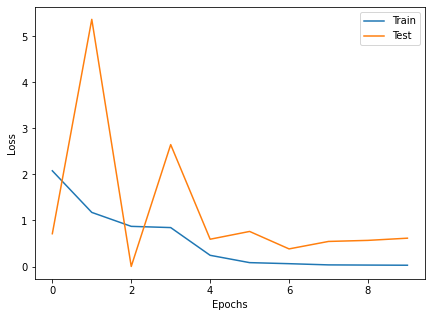

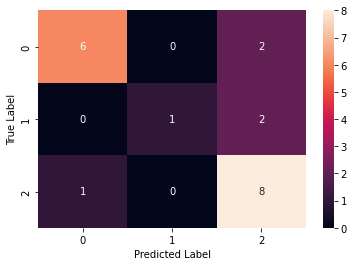

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.94939790169398, Test Loss: 2.9554741382598877
Epoch 2-- Train Loss:1.252785325050354, Test Loss: 1.9091826677322388
Epoch 3-- Train Loss:0.8303979684909185, Test Loss: 0.4945485293865204
Epoch 4-- Train Loss:0.3607414315144221, Test Loss: 0.8339879512786865
Epoch 5-- Train Loss:0.25543532334268093, Test Loss: 0.21748854219913483
Epoch 6-- Train Loss:0.09106527641415596, Test Loss: 0.03357141464948654
Epoch 7-- Train Loss:0.07813108231251438, Test Loss: 0.32435286045074463
Epoch 8-- Train Loss:0.06065039957563082, Test Loss: 0.038398388773202896
Epoch 9-- Train Loss:0.05073150433599949, Test Loss: 0.08971843123435974
Epoch 10-- Train Loss:0.03898462435851494, Test Loss: 0.06410007178783417


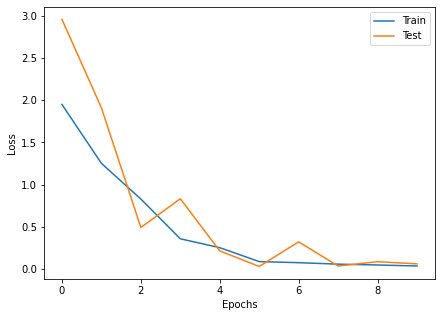

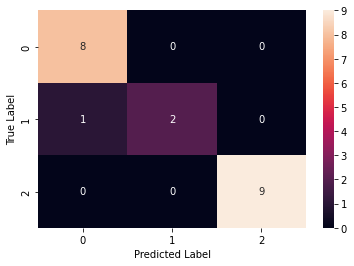

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.189341902732849, Test Loss: 2.747893810272217
Epoch 2-- Train Loss:1.0321860512097676, Test Loss: 0.7598842978477478
Epoch 3-- Train Loss:0.46841874221960705, Test Loss: 0.7857135534286499
Epoch 4-- Train Loss:0.3316442494591077, Test Loss: 3.228074073791504
Epoch 5-- Train Loss:0.18699050197998682, Test Loss: 1.0168137550354004
Epoch 6-- Train Loss:0.09540220598379771, Test Loss: 1.1687779426574707
Epoch 7-- Train Loss:0.06951892996827762, Test Loss: 1.0578207969665527
Epoch 8-- Train Loss:0.05146812771757444, Test Loss: 0.1737631857395172
Epoch 9-- Train Loss:0.04561572025219599, Test Loss: 0.4250350892543793
Epoch 10-- Train Loss:0.02874981379136443, Test Loss: 1.885600209236145


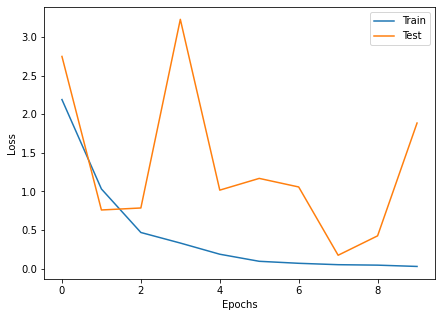

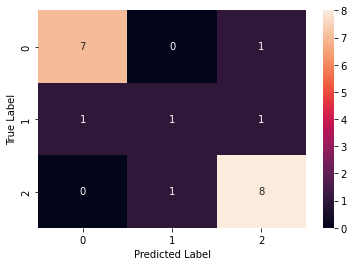

Starting testing
Training Complete
{'0': {'f1-score': '0.895±0.069',
       'precision': '0.924±0.063',
       'recall': '0.875±0.112',
       'support': 8},
 '1': {'f1-score': '0.58±0.238',
       'precision': '0.767±0.291',
       'recall': '0.5±0.258',
       'support': 4},
 '2': {'f1-score': '0.853±0.079',
       'precision': '0.803±0.11',
       'recall': '0.913±0.044',
       'support': 9},
 'accuracy': '0.834±0.091',
 'macro avg': {'f1-score': '0.776±0.123',
               'precision': '0.831±0.112',
               'recall': '0.763±0.129',
               'support': 21},
 'weighted avg': {'f1-score': '0.827±0.093',
                  'precision': '0.847±0.083',
                  'recall': '0.834±0.091',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.790132034392584, Test Loss: 0.03693084418773651
Epoch 2-- Train Loss:1.365779378584453, Test Loss: 0.13427196443080902
Epoch 3-- Train 

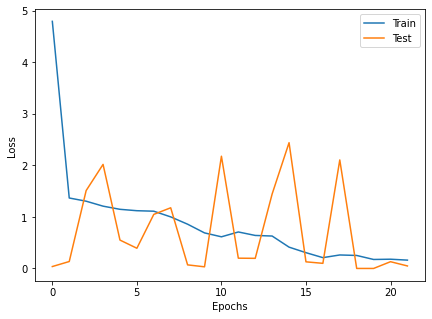

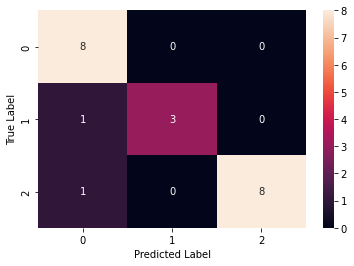

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.374033116158985, Test Loss: 0.06459679454565048
Epoch 2-- Train Loss:1.3986844193367731, Test Loss: 1.7854318618774414
Epoch 3-- Train Loss:1.264977460815793, Test Loss: 1.326210618019104
Epoch 4-- Train Loss:1.0548570922442846, Test Loss: 1.30666184425354
Epoch 5-- Train Loss:1.1299673162755512, Test Loss: 2.74411678314209
Epoch 6-- Train Loss:1.0017246220793043, Test Loss: 2.383610963821411
Epoch 7-- Train Loss:1.1218560934066772, Test Loss: 0.20851045846939087
Epoch 8-- Train Loss:0.9846577757880801, Test Loss: 1.7820461988449097
Epoch 9-- Train Loss:0.9457825918992361, Test Loss: 0.44533395767211914
Epoch 10-- Train Loss:0.9620973183995202, Test Loss: 0.44902554154396057
Epoch 11-- Train Loss:0.9526144315799078, Test Loss: 1.0008083581924438
Epoch 12-- Train Loss:0.9609266916910807, Test Loss: 0.3402489125728607
Epoch 13-- Train Loss:0.8647776089963459, Test Loss: 1.5913466215133667
Epoch 14-- Train Los

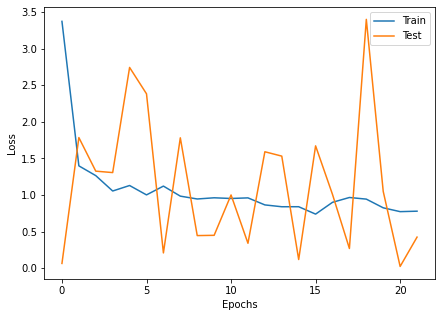

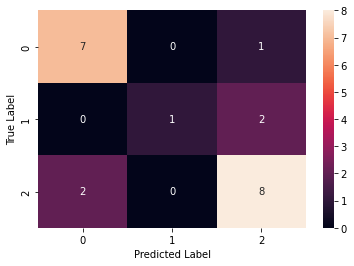

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.000180741151174, Test Loss: 1.8490300178527832
Epoch 2-- Train Loss:1.2905511487097967, Test Loss: 0.6829116940498352
Epoch 3-- Train Loss:1.36535648504893, Test Loss: 1.2761614322662354
Epoch 4-- Train Loss:1.1410043665340968, Test Loss: 0.6948851943016052
Epoch 5-- Train Loss:1.0962352993942441, Test Loss: 1.2101869583129883
Epoch 6-- Train Loss:0.8889085096972329, Test Loss: 0.5766143202781677
Epoch 7-- Train Loss:0.8073085943857828, Test Loss: 0.9368574023246765
Epoch 8-- Train Loss:0.9455766734622774, Test Loss: 0.7840688228607178
Epoch 9-- Train Loss:0.7203603216579982, Test Loss: 0.5954319834709167
Epoch 10-- Train Loss:0.5705159874189467, Test Loss: 1.1996852159500122
Epoch 11-- Train Loss:1.061456158579815, Test Loss: 0.5827199816703796
Epoch 12-- Train Loss:1.0015897012892223, Test Loss: 0.7382579445838928
Epoch 13-- Train Loss:0.9258465837864649, Test Loss: 0.4834173619747162
Epoch 14-- Train Los

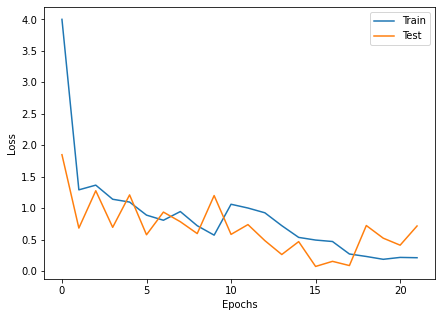

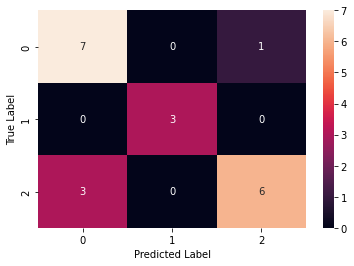

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:8.811135033766428, Test Loss: 3.8840746879577637
Epoch 2-- Train Loss:1.2931372608457292, Test Loss: 1.3224631547927856
Epoch 3-- Train Loss:1.4688227914628529, Test Loss: 1.1166964769363403
Epoch 4-- Train Loss:1.3110601873624892, Test Loss: 1.3568933010101318
Epoch 5-- Train Loss:1.1864532317434038, Test Loss: 1.5760544538497925
Epoch 6-- Train Loss:1.1168015542484464, Test Loss: 0.7550601363182068
Epoch 7-- Train Loss:1.1479244700499944, Test Loss: 1.3163816928863525
Epoch 8-- Train Loss:1.1656982813562666, Test Loss: 1.1400431394577026
Epoch 9-- Train Loss:1.165211714449383, Test Loss: 0.8872321248054504
Epoch 10-- Train Loss:1.1526933511098225, Test Loss: 1.0224558115005493
Epoch 11-- Train Loss:1.135032438096546, Test Loss: 1.4778456687927246
Epoch 12-- Train Loss:1.1308516434260778, Test Loss: 1.002242922782898
Epoch 13-- Train Loss:1.1151024188314165, Test Loss: 1.068035364151001
Epoch 14-- Train Loss

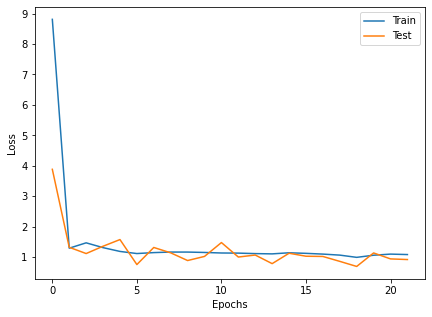

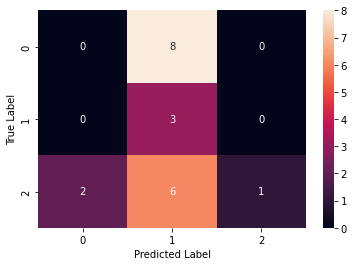

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:5.780140431154342, Test Loss: 2.7626686096191406
Epoch 2-- Train Loss:2.407476876463209, Test Loss: 3.681650400161743
Epoch 3-- Train Loss:1.3458753994532995, Test Loss: 3.495939254760742
Epoch 4-- Train Loss:1.3104250374294462, Test Loss: 1.1609930992126465
Epoch 5-- Train Loss:1.2077198908442544, Test Loss: 1.0839533805847168
Epoch 6-- Train Loss:1.190178053719657, Test Loss: 1.2654863595962524
Epoch 7-- Train Loss:1.1802047264008295, Test Loss: 1.0743036270141602
Epoch 8-- Train Loss:1.128849514893123, Test Loss: 1.09819495677948
Epoch 9-- Train Loss:1.1223517202195668, Test Loss: 1.2235007286071777
Epoch 10-- Train Loss:1.0641037566321236, Test Loss: 1.4592233896255493
Epoch 11-- Train Loss:1.099819458666302, Test Loss: 0.9174209237098694
Epoch 12-- Train Loss:1.0817342684382485, Test Loss: 0.9076240062713623
Epoch 13-- Train Loss:1.1377734428360349, Test Loss: 1.2101871967315674
Epoch 14-- Train Loss:1.0

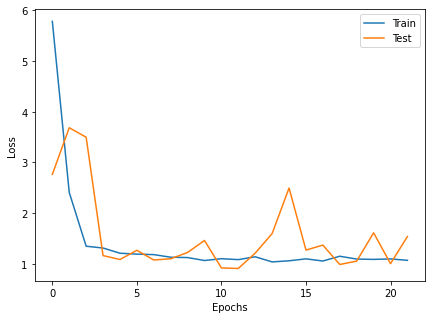

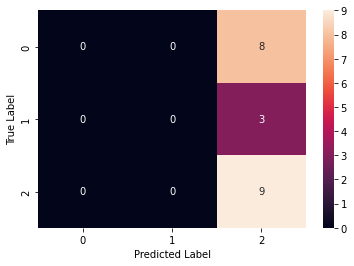

Starting testing
Training Complete
{'0': {'f1-score': '0.498±0.408',
       'precision': '0.456±0.373',
       'recall': '0.55±0.451',
       'support': 8},
 '1': {'f1-score': '0.526±0.368',
       'precision': '0.632±0.454',
       'recall': '0.617±0.393',
       'support': 4},
 '2': {'f1-score': '0.655±0.249',
       'precision': '0.807±0.205',
       'recall': '0.693±0.311',
       'support': 9},
 'accuracy': '0.623±0.26',
 'macro avg': {'f1-score': '0.56±0.315',
               'precision': '0.631±0.308',
               'recall': '0.62±0.231',
               'support': 21},
 'weighted avg': {'f1-score': '0.572±0.308',
                  'precision': '0.64±0.265',
                  'recall': '0.623±0.26',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0081, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.533042220842271, Test Loss: 0.007045899052172899
Epoch 2-- Train Loss:1.5512461236545019, Test Loss: 0.16542862355709076
Epoch 3-- Train 

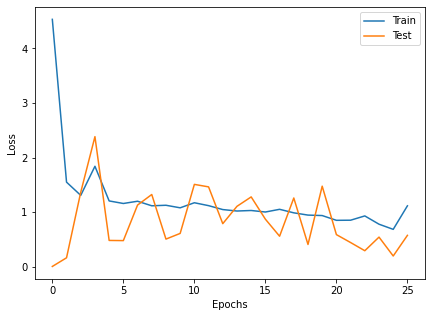

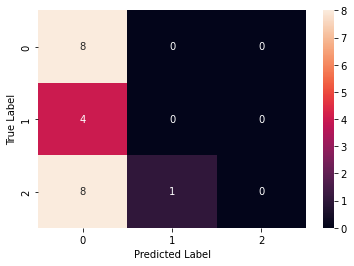

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.177853010949635, Test Loss: 1.7404896020889282
Epoch 2-- Train Loss:1.1395289245105924, Test Loss: 1.8739720582962036
Epoch 3-- Train Loss:1.2168819223131453, Test Loss: 0.6696029305458069
Epoch 4-- Train Loss:1.1293765192940122, Test Loss: 1.139714241027832
Epoch 5-- Train Loss:1.1329374370120822, Test Loss: 1.1692521572113037
Epoch 6-- Train Loss:1.1465923672630673, Test Loss: 0.9432298541069031
Epoch 7-- Train Loss:1.1371518912769498, Test Loss: 1.157405138015747
Epoch 8-- Train Loss:1.1138310829798381, Test Loss: 0.8010974526405334
Epoch 9-- Train Loss:1.104768259184701, Test Loss: 1.4315929412841797
Epoch 10-- Train Loss:1.1045771894000826, Test Loss: 1.1247718334197998
Epoch 11-- Train Loss:1.1031675849642073, Test Loss: 0.9086815118789673
Epoch 12-- Train Loss:1.087078917594183, Test Loss: 1.7908916473388672
Epoch 13-- Train Loss:1.096882695243472, Test Loss: 1.1917308568954468
Epoch 14-- Train Loss:

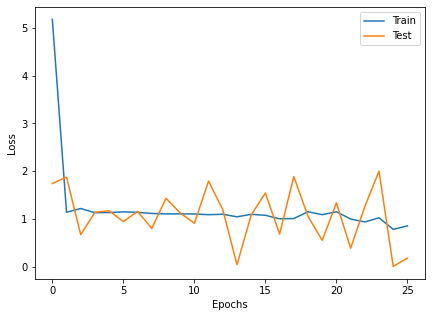

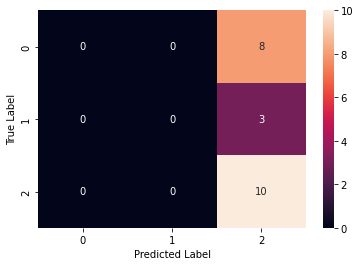

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:6.500522324017116, Test Loss: 2.2266368865966797
Epoch 2-- Train Loss:1.3071165397053672, Test Loss: 0.7935450077056885
Epoch 3-- Train Loss:1.291695475578308, Test Loss: 1.0296134948730469
Epoch 4-- Train Loss:1.2219655825978233, Test Loss: 1.7395148277282715
Epoch 5-- Train Loss:1.294355375426156, Test Loss: 1.0674107074737549
Epoch 6-- Train Loss:1.2179634429159618, Test Loss: 1.101499319076538
Epoch 7-- Train Loss:1.1400696890694755, Test Loss: 0.7451738119125366
Epoch 8-- Train Loss:1.1428684109733218, Test Loss: 1.098219633102417
Epoch 9-- Train Loss:1.1459785387629555, Test Loss: 1.0238288640975952
Epoch 10-- Train Loss:1.1116163162958055, Test Loss: 0.9375367760658264
Epoch 11-- Train Loss:1.1173358956972759, Test Loss: 0.9388852715492249
Epoch 12-- Train Loss:1.0950347128368558, Test Loss: 1.2489330768585205
Epoch 13-- Train Loss:1.1432250511078608, Test Loss: 1.149014949798584
Epoch 14-- Train Loss:

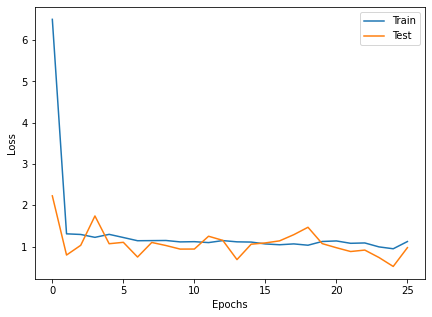

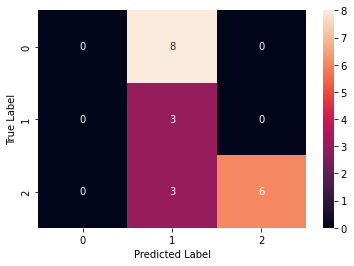

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.548010153429849, Test Loss: 1.5405381917953491
Epoch 2-- Train Loss:1.1823376956440153, Test Loss: 0.6926586627960205
Epoch 3-- Train Loss:1.227741076832726, Test Loss: 1.255012035369873
Epoch 4-- Train Loss:1.160634350209009, Test Loss: 1.0423808097839355
Epoch 5-- Train Loss:1.161148644628979, Test Loss: 1.327209234237671
Epoch 6-- Train Loss:1.1354936474845523, Test Loss: 0.9002664685249329
Epoch 7-- Train Loss:1.1050003000668116, Test Loss: 1.1217060089111328
Epoch 8-- Train Loss:1.108032484849294, Test Loss: 1.6175119876861572
Epoch 9-- Train Loss:1.0585327034904843, Test Loss: 0.8466384410858154
Epoch 10-- Train Loss:1.0489223514284407, Test Loss: 0.939608097076416
Epoch 11-- Train Loss:0.9677495615822929, Test Loss: 2.3999414443969727
Epoch 12-- Train Loss:1.1679648011922836, Test Loss: 1.175421953201294
Epoch 13-- Train Loss:1.0491449946448916, Test Loss: 1.1630187034606934
Epoch 14-- Train Loss:0.9

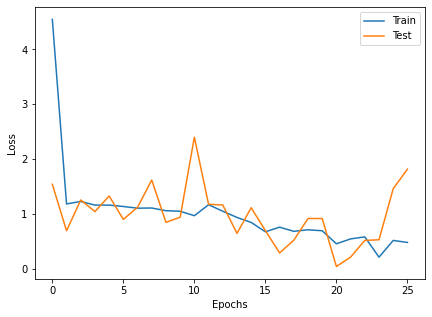

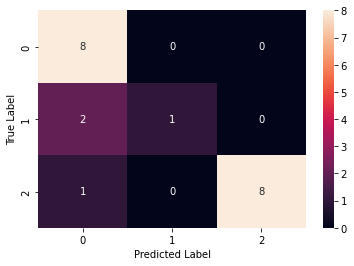

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.408335314620109, Test Loss: 1.8412038087844849
Epoch 2-- Train Loss:1.2971038818359375, Test Loss: 1.0862367153167725
Epoch 3-- Train Loss:3.8027069057737077, Test Loss: 4.249325275421143
Epoch 4-- Train Loss:3.182078735814208, Test Loss: 1.8859107494354248
Epoch 5-- Train Loss:1.1650136028017317, Test Loss: 1.0317447185516357
Epoch 6-- Train Loss:1.0876555953707014, Test Loss: 1.3055546283721924
Epoch 7-- Train Loss:0.9993787180809748, Test Loss: 1.773871898651123
Epoch 8-- Train Loss:0.9792301399367196, Test Loss: 0.6953397393226624
Epoch 9-- Train Loss:0.8633092457339877, Test Loss: 1.025573492050171
Epoch 10-- Train Loss:0.8343939710231054, Test Loss: 1.3744930028915405
Epoch 11-- Train Loss:0.8382669843378521, Test Loss: 0.7934476733207703
Epoch 12-- Train Loss:0.8130929626169658, Test Loss: 2.3403701782226562
Epoch 13-- Train Loss:0.8395707252479735, Test Loss: 0.9150518774986267
Epoch 14-- Train Loss

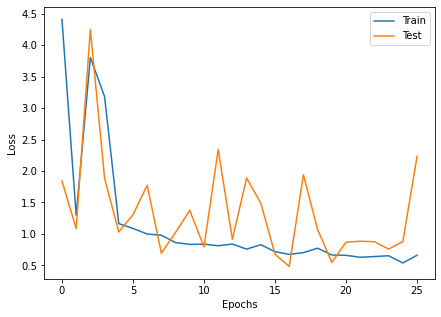

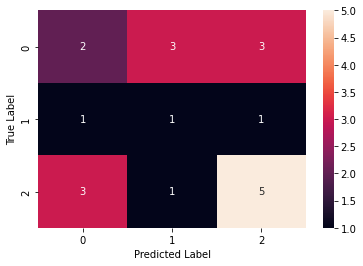

Starting testing
Training Complete
{'0': {'f1-score': '0.344±0.328',
       'precision': '0.305±0.277',
       'recall': '0.45±0.458',
       'support': 8},
 '1': {'f1-score': '0.221±0.197',
       'precision': '0.283±0.37',
       'recall': '0.333±0.365',
       'support': 4},
 '2': {'f1-score': '0.559±0.3',
       'precision': '0.57±0.351',
       'recall': '0.6±0.334',
       'support': 9},
 'accuracy': '0.501±0.153',
 'macro avg': {'f1-score': '0.375±0.19',
               'precision': '0.386±0.264',
               'recall': '0.461±0.146',
               'support': 21},
 'weighted avg': {'f1-score': '0.424±0.193',
                  'precision': '0.422±0.239',
                  'recall': '0.501±0.153',
                  'support': 21}}
{'num_epochs': 46, 'lr': 0.0021, 'batch_size': 32}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:3.1083014806111655, Test Loss: 4.133660793304443
Epoch 2-- Train Loss:3.0478397210439048, Test Loss: 2.631638526916504
Epoch 3-- Train Loss:

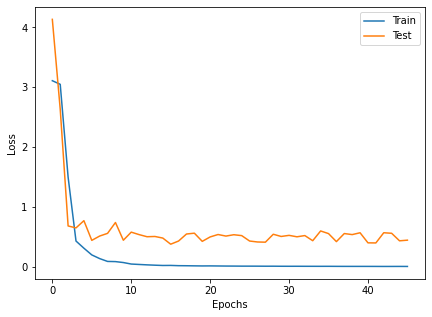

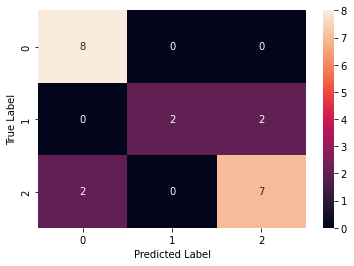

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:3.2242266734441123, Test Loss: 2.5100574493408203
Epoch 2-- Train Loss:2.6489717165629068, Test Loss: 3.3501226902008057
Epoch 3-- Train Loss:2.8224210341771445, Test Loss: 1.6927036046981812
Epoch 4-- Train Loss:0.6354899456103643, Test Loss: 0.7628096342086792
Epoch 5-- Train Loss:0.408596138159434, Test Loss: 0.9675823450088501
Epoch 6-- Train Loss:0.25548545519510907, Test Loss: 0.7317124009132385
Epoch 7-- Train Loss:0.14607466757297516, Test Loss: 0.7131307721138
Epoch 8-- Train Loss:0.11225852370262146, Test Loss: 0.6408599019050598
Epoch 9-- Train Loss:0.06986820325255394, Test Loss: 0.7187049388885498
Epoch 10-- Train Loss:0.04672547057271004, Test Loss: 0.5955101251602173
Epoch 11-- Train Loss:0.039193437745173774, Test Loss: 0.5553524494171143
Epoch 12-- Train Loss:0.02919379559655984, Test Loss: 0.5857849717140198
Epoch 13-- Train Loss:0.02915547974407673, Test Loss: 0.6500800848007202
Epoch 14-- 

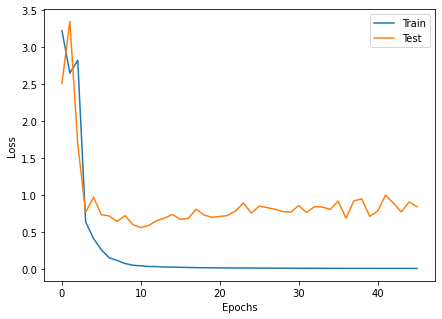

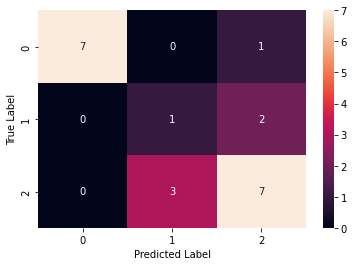

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.3296632369359336, Test Loss: 3.614955186843872
Epoch 2-- Train Loss:1.7262298663457234, Test Loss: 1.1613528728485107
Epoch 3-- Train Loss:0.6798042456309, Test Loss: 1.165759801864624
Epoch 4-- Train Loss:0.3420703013737996, Test Loss: 0.8176339268684387
Epoch 5-- Train Loss:1.1181636253992717, Test Loss: 1.0262833833694458
Epoch 6-- Train Loss:0.13042985647916794, Test Loss: 0.560407280921936
Epoch 7-- Train Loss:0.09811652451753616, Test Loss: 0.7513458728790283
Epoch 8-- Train Loss:0.0665555124481519, Test Loss: 0.7196555137634277
Epoch 9-- Train Loss:0.04605548828840256, Test Loss: 0.8635951280593872
Epoch 10-- Train Loss:0.031090866774320602, Test Loss: 0.6990860104560852
Epoch 11-- Train Loss:0.02530466951429844, Test Loss: 0.7639085054397583
Epoch 12-- Train Loss:0.0215245612586538, Test Loss: 0.7505201101303101
Epoch 13-- Train Loss:0.01708439737558365, Test Loss: 0.8279762268066406
Epoch 14-- Trai

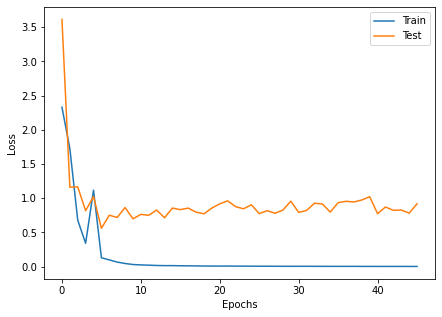

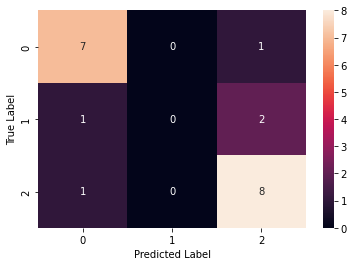

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.050236145655314, Test Loss: 6.373758792877197
Epoch 2-- Train Loss:2.24671870470047, Test Loss: 4.249804496765137
Epoch 3-- Train Loss:2.439667562643687, Test Loss: 0.5971335768699646
Epoch 4-- Train Loss:0.4705537756284078, Test Loss: 0.6101810932159424
Epoch 5-- Train Loss:0.31113500396410626, Test Loss: 0.4183865785598755
Epoch 6-- Train Loss:0.17854016025861105, Test Loss: 0.337398886680603
Epoch 7-- Train Loss:0.10799039403597514, Test Loss: 0.3023830056190491
Epoch 8-- Train Loss:0.08492880314588547, Test Loss: 0.3364023268222809
Epoch 9-- Train Loss:0.06898911421497662, Test Loss: 0.2979494035243988
Epoch 10-- Train Loss:0.05119388923048973, Test Loss: 0.30019721388816833
Epoch 11-- Train Loss:0.04332608605424563, Test Loss: 0.33474332094192505
Epoch 12-- Train Loss:0.03631685674190521, Test Loss: 0.3145315647125244
Epoch 13-- Train Loss:0.031069347634911537, Test Loss: 0.2544173002243042
Epoch 14-- 

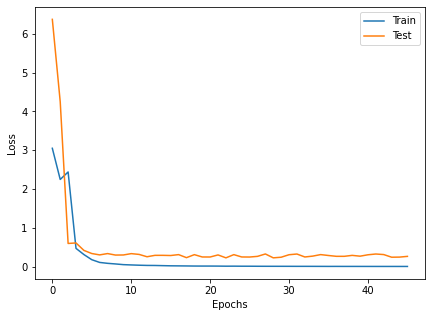

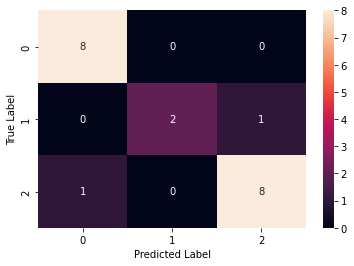

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.7946794827779136, Test Loss: 4.427530288696289
Epoch 2-- Train Loss:3.106628974278768, Test Loss: 2.817873477935791
Epoch 3-- Train Loss:1.6928975383440654, Test Loss: 0.8019936680793762
Epoch 4-- Train Loss:0.46833235025405884, Test Loss: 0.9370095133781433
Epoch 5-- Train Loss:0.41667675971984863, Test Loss: 0.8169214129447937
Epoch 6-- Train Loss:0.21344375113646188, Test Loss: 0.6882111430168152
Epoch 7-- Train Loss:0.13846629858016968, Test Loss: 0.6263523697853088
Epoch 8-- Train Loss:0.07661234835783641, Test Loss: 0.6169208288192749
Epoch 9-- Train Loss:0.06276408831278484, Test Loss: 0.5519640445709229
Epoch 10-- Train Loss:0.059745173901319504, Test Loss: 0.6165412664413452
Epoch 11-- Train Loss:0.04388470451037089, Test Loss: 0.6141808032989502
Epoch 12-- Train Loss:0.03503730768958727, Test Loss: 0.6349517107009888
Epoch 13-- Train Loss:0.030828315764665604, Test Loss: 0.5133452415466309
Epoch 1

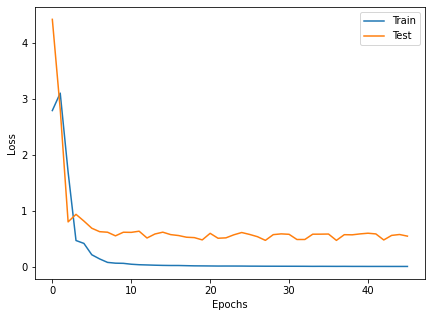

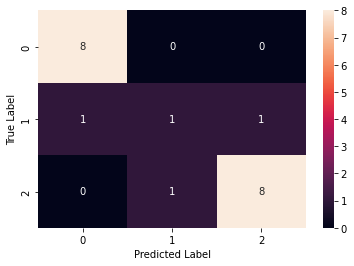

Starting testing
Training Complete
{'0': {'f1-score': '0.877±0.039',
       'precision': '0.868±0.078',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.47±0.34',
       'precision': '0.55±0.4',
       'recall': '0.433±0.327',
       'support': 4},
 '2': {'f1-score': '0.823±0.055',
       'precision': '0.802±0.073',
       'recall': '0.849±0.049',
       'support': 9},
 'accuracy': '0.805±0.067',
 'macro avg': {'f1-score': '0.724±0.129',
               'precision': '0.74±0.149',
               'recall': '0.727±0.117',
               'support': 21},
 'weighted avg': {'f1-score': '0.791±0.075',
                  'precision': '0.792±0.088',
                  'recall': '0.805±0.067',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:4.925232257161822, Test Loss: 0.07548466324806213
Epoch 2-- Train Loss:1.3760264799708413, Test Loss: 0.1099591851234436
Epoch 3-- Train Loss

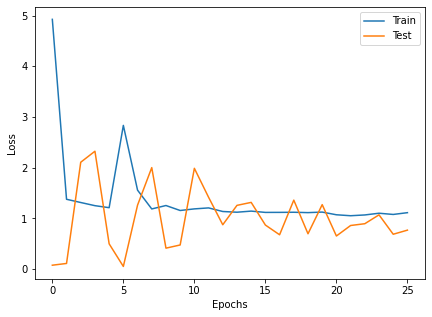

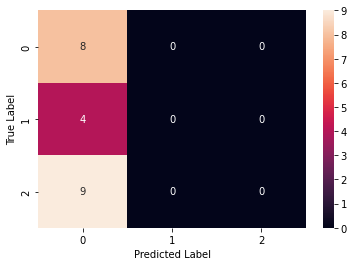

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:5.6052064789193015, Test Loss: 2.4007644653320312
Epoch 2-- Train Loss:1.1986171858651298, Test Loss: 2.179009437561035
Epoch 3-- Train Loss:1.2819934714408148, Test Loss: 0.551889955997467
Epoch 4-- Train Loss:1.150463757060823, Test Loss: 1.4003291130065918
Epoch 5-- Train Loss:1.1576394864491053, Test Loss: 1.284928321838379
Epoch 6-- Train Loss:1.1583124541101002, Test Loss: 0.8757086396217346
Epoch 7-- Train Loss:1.1389941431227184, Test Loss: 1.1406481266021729
Epoch 8-- Train Loss:1.1141949750128246, Test Loss: 0.7414941787719727
Epoch 9-- Train Loss:1.1039162107876368, Test Loss: 1.3099992275238037
Epoch 10-- Train Loss:1.1101044501577104, Test Loss: 1.1690125465393066
Epoch 11-- Train Loss:1.1176190092450096, Test Loss: 0.8949041962623596
Epoch 12-- Train Loss:1.1035256584485371, Test Loss: 1.3695569038391113
Epoch 13-- Train Loss:1.1033795192128135, Test Loss: 1.1327252388000488
Epoch 14-- Train Los

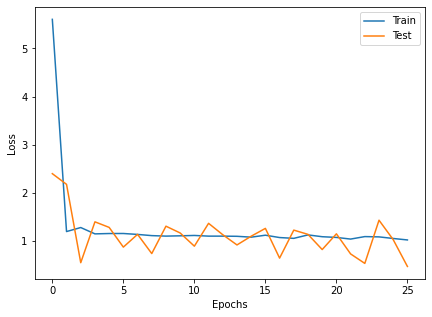

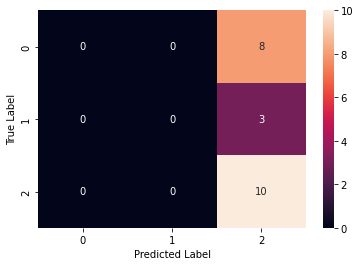

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:5.215193212032318, Test Loss: 2.189037322998047
Epoch 2-- Train Loss:1.343197376955123, Test Loss: 0.8269311189651489
Epoch 3-- Train Loss:1.2703642504555839, Test Loss: 1.00969660282135
Epoch 4-- Train Loss:1.1953392653238206, Test Loss: 1.5161267518997192
Epoch 5-- Train Loss:1.2178581328619094, Test Loss: 1.107029914855957
Epoch 6-- Train Loss:1.189723014831543, Test Loss: 1.1247552633285522
Epoch 7-- Train Loss:1.1334532272248041, Test Loss: 0.7495049834251404
Epoch 8-- Train Loss:1.1267230879692804, Test Loss: 1.113838791847229
Epoch 9-- Train Loss:1.1308000485102336, Test Loss: 1.048393964767456
Epoch 10-- Train Loss:1.1119732062021892, Test Loss: 0.9637541174888611
Epoch 11-- Train Loss:1.1161660381725855, Test Loss: 0.9454450011253357
Epoch 12-- Train Loss:1.0920822478476024, Test Loss: 1.4371310472488403
Epoch 13-- Train Loss:1.141689487865993, Test Loss: 1.165341854095459
Epoch 14-- Train Loss:1.109

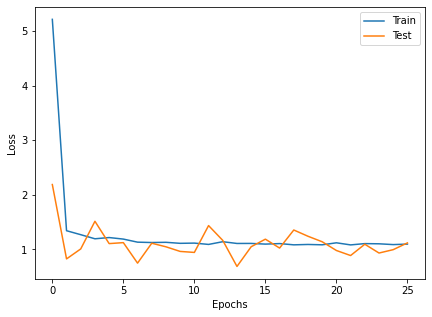

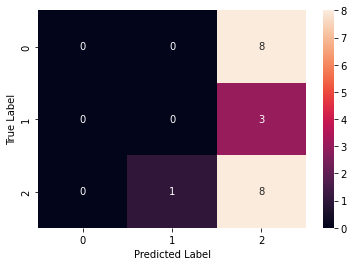

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:6.374716756491883, Test Loss: 1.9341926574707031
Epoch 2-- Train Loss:1.2303461063475836, Test Loss: 0.8831659555435181
Epoch 3-- Train Loss:1.366046672775632, Test Loss: 1.3508321046829224
Epoch 4-- Train Loss:1.168428605511075, Test Loss: 1.063652515411377
Epoch 5-- Train Loss:1.1678038920675005, Test Loss: 1.19537353515625
Epoch 6-- Train Loss:1.1466659761610485, Test Loss: 0.8703172206878662
Epoch 7-- Train Loss:1.1233339848972501, Test Loss: 1.116284966468811
Epoch 8-- Train Loss:1.128769570872897, Test Loss: 1.4971750974655151
Epoch 9-- Train Loss:1.1124021808306377, Test Loss: 0.9115071296691895
Epoch 10-- Train Loss:1.1125317102386838, Test Loss: 1.0157358646392822
Epoch 11-- Train Loss:1.0810391590708779, Test Loss: 1.4720300436019897
Epoch 12-- Train Loss:1.1131734479041326, Test Loss: 1.0431597232818604
Epoch 13-- Train Loss:1.0467506249745686, Test Loss: 0.8711010813713074
Epoch 14-- Train Loss:0.

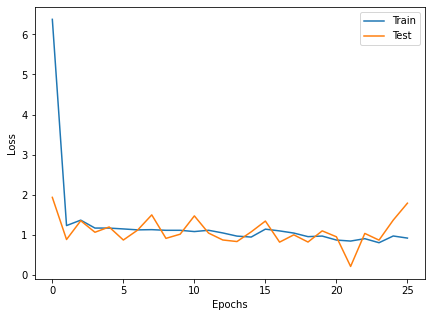

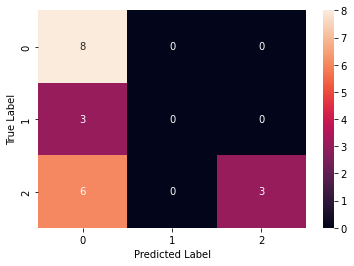

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.471905931120827, Test Loss: 1.5625535249710083
Epoch 2-- Train Loss:1.2407429161525907, Test Loss: 1.0669207572937012
Epoch 3-- Train Loss:1.1751854987371535, Test Loss: 0.939877450466156
Epoch 4-- Train Loss:1.079900398140862, Test Loss: 1.7341455221176147
Epoch 5-- Train Loss:1.0946043928464253, Test Loss: 1.046581506729126
Epoch 6-- Train Loss:1.0153505901495616, Test Loss: 2.0205016136169434
Epoch 7-- Train Loss:0.9175785538696107, Test Loss: 1.466183066368103
Epoch 8-- Train Loss:0.8965192692620414, Test Loss: 0.6953098773956299
Epoch 9-- Train Loss:0.7482201896962666, Test Loss: 2.72649884223938
Epoch 10-- Train Loss:0.831727113042559, Test Loss: 0.7537006735801697
Epoch 11-- Train Loss:0.552787782180877, Test Loss: 0.36362338066101074
Epoch 12-- Train Loss:0.6234905826193946, Test Loss: 0.8443087935447693
Epoch 13-- Train Loss:0.5057701220115026, Test Loss: 6.292565822601318
Epoch 14-- Train Loss:1.0

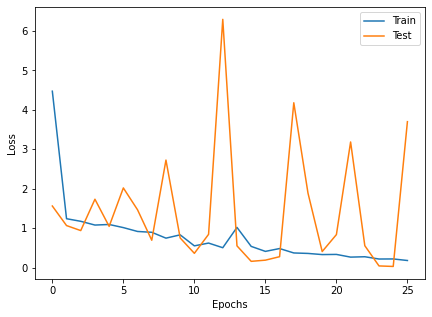

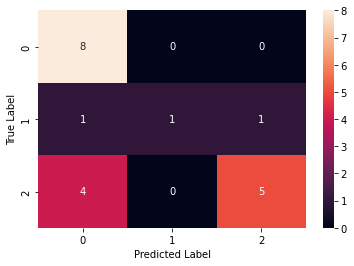

Starting testing
Training Complete
{'0': {'f1-score': '0.391±0.326',
       'precision': '0.293±0.251',
       'recall': '0.6±0.49',
       'support': 8},
 '1': {'f1-score': '0.1±0.2',
       'precision': '0.2±0.4',
       'recall': '0.067±0.133',
       'support': 4},
 '2': {'f1-score': '0.487±0.25',
       'precision': '0.552±0.347',
       'recall': '0.578±0.387',
       'support': 9},
 'accuracy': '0.511±0.109',
 'macro avg': {'f1-score': '0.326±0.173',
               'precision': '0.348±0.27',
               'recall': '0.415±0.116',
               'support': 21},
 'weighted avg': {'f1-score': '0.391±0.17',
                  'precision': '0.397±0.256',
                  'recall': '0.511±0.109',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0061, 'batch_size': 16}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:7.062877158323924, Test Loss: 9.949264526367188
Epoch 2-- Train Loss:2.119471867879232, Test Loss: 2.7363250255584717
Epoch 3-- Train Loss:1.37597

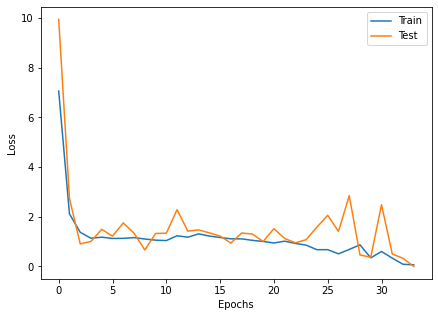

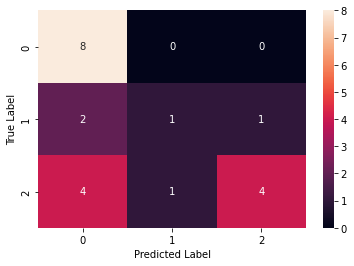

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:6.6977152824401855, Test Loss: 8.284775733947754
Epoch 2-- Train Loss:2.321562647819519, Test Loss: 1.6395188570022583
Epoch 3-- Train Loss:1.1891791423161824, Test Loss: 0.9553344249725342
Epoch 4-- Train Loss:1.3566527565320332, Test Loss: 2.5680689811706543
Epoch 5-- Train Loss:1.3109819889068604, Test Loss: 1.5224318504333496
Epoch 6-- Train Loss:1.2254623174667358, Test Loss: 0.8639211654663086
Epoch 7-- Train Loss:1.1622056861718495, Test Loss: 1.1125097274780273
Epoch 8-- Train Loss:1.2258254090944927, Test Loss: 1.5087913274765015
Epoch 9-- Train Loss:1.1052582263946533, Test Loss: 1.2715872526168823
Epoch 10-- Train Loss:1.1527570486068726, Test Loss: 1.5213035345077515
Epoch 11-- Train Loss:1.1208572785059612, Test Loss: 0.6547573208808899
Epoch 12-- Train Loss:1.0549141367276509, Test Loss: 1.8491472005844116
Epoch 13-- Train Loss:1.1311447819073994, Test Loss: 1.3215432167053223
Epoch 14-- Train L

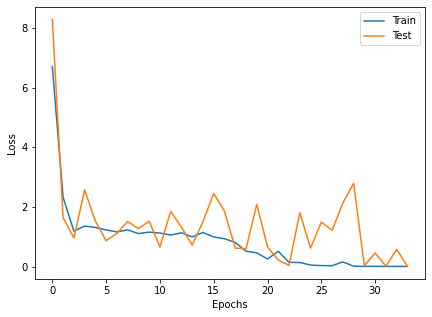

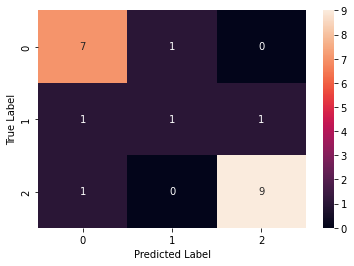

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:4.145153005917867, Test Loss: 6.461722373962402
Epoch 2-- Train Loss:1.3948152462641399, Test Loss: 1.7957435846328735
Epoch 3-- Train Loss:1.0557136038939159, Test Loss: 1.209469199180603
Epoch 4-- Train Loss:1.0562852229292428, Test Loss: 3.250671863555908
Epoch 5-- Train Loss:1.2853365043799083, Test Loss: 1.0320005416870117
Epoch 6-- Train Loss:0.5584106345971426, Test Loss: 1.0628485679626465
Epoch 7-- Train Loss:0.32888571669658023, Test Loss: 0.40668436884880066
Epoch 8-- Train Loss:0.20663351193070412, Test Loss: 2.9890458583831787
Epoch 9-- Train Loss:4.1376776744922, Test Loss: 4.241690158843994
Epoch 10-- Train Loss:1.1414417227109273, Test Loss: 1.0265514850616455
Epoch 11-- Train Loss:0.6450189550717672, Test Loss: 0.8849027156829834
Epoch 12-- Train Loss:0.6176114479700724, Test Loss: 0.17823444306850433
Epoch 13-- Train Loss:0.10183124989271164, Test Loss: 0.07640776038169861
Epoch 14-- Train L

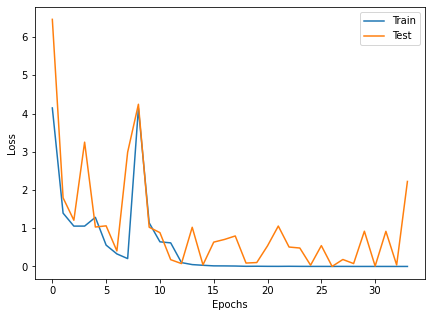

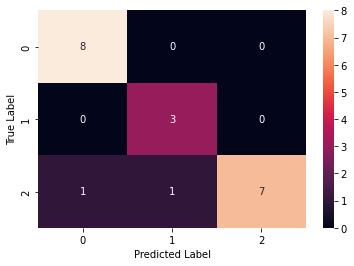

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:4.268822326906957, Test Loss: 3.6594576835632324
Epoch 2-- Train Loss:4.567173143227895, Test Loss: 1.6504548788070679
Epoch 3-- Train Loss:1.2464101612567902, Test Loss: 2.186081647872925
Epoch 4-- Train Loss:1.3110046585400899, Test Loss: 3.1356232166290283
Epoch 5-- Train Loss:1.5923330585161846, Test Loss: 0.8839538097381592
Epoch 6-- Train Loss:1.084003875652949, Test Loss: 1.623923897743225
Epoch 7-- Train Loss:1.0441384712855022, Test Loss: 0.5370418429374695
Epoch 8-- Train Loss:0.9432266453901926, Test Loss: 0.8530543446540833
Epoch 9-- Train Loss:0.7099559356768926, Test Loss: 0.20277385413646698
Epoch 10-- Train Loss:0.37007156014442444, Test Loss: 0.4742066562175751
Epoch 11-- Train Loss:0.8547950312495232, Test Loss: 0.9527685046195984
Epoch 12-- Train Loss:0.5242633372545242, Test Loss: 0.12879163026809692
Epoch 13-- Train Loss:0.23355220809268454, Test Loss: 0.025067491456866264
Epoch 14-- Trai

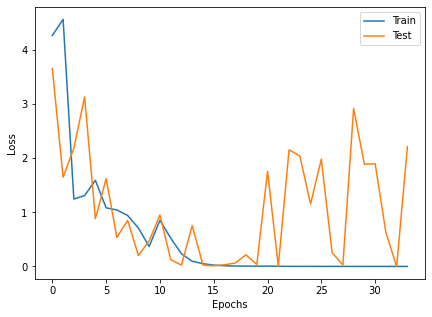

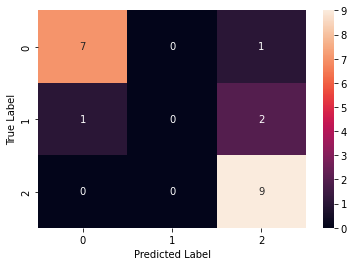

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:4.951772212982178, Test Loss: 4.354952812194824
Epoch 2-- Train Loss:2.0688639978567758, Test Loss: 2.3291776180267334
Epoch 3-- Train Loss:1.089896668990453, Test Loss: 1.650197148323059
Epoch 4-- Train Loss:1.0965187748273213, Test Loss: 2.466737747192383
Epoch 5-- Train Loss:1.484388828277588, Test Loss: 0.8344735503196716
Epoch 6-- Train Loss:1.1873785257339478, Test Loss: 1.5762075185775757
Epoch 7-- Train Loss:1.0466751754283905, Test Loss: 0.6332755088806152
Epoch 8-- Train Loss:0.8629205822944641, Test Loss: 0.869742751121521
Epoch 9-- Train Loss:1.017086923122406, Test Loss: 1.9046554565429688
Epoch 10-- Train Loss:0.6846323609352112, Test Loss: 0.9345974326133728
Epoch 11-- Train Loss:0.4534522667527199, Test Loss: 1.8505080938339233
Epoch 12-- Train Loss:0.8224012951056162, Test Loss: 1.6151171922683716
Epoch 13-- Train Loss:0.2603453211874391, Test Loss: 3.175774574279785
Epoch 14-- Train Loss:0.6

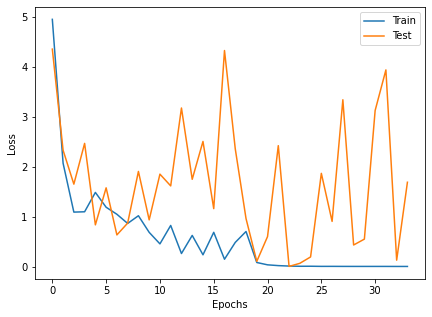

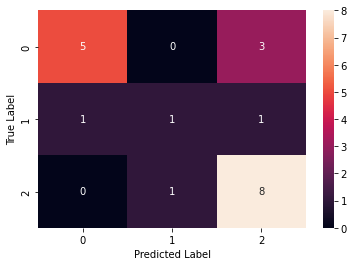

Starting testing
Training Complete
{'0': {'f1-score': '0.817±0.078',
       'precision': '0.767±0.125',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.398±0.273',
       'precision': '0.45±0.245',
       'recall': '0.383±0.332',
       'support': 4},
 '2': {'f1-score': '0.798±0.1',
       'precision': '0.871±0.123',
       'recall': '0.78±0.174',
       'support': 9},
 'accuracy': '0.766±0.092',
 'macro avg': {'f1-score': '0.671±0.128',
               'precision': '0.696±0.121',
               'recall': '0.688±0.129',
               'support': 21},
 'weighted avg': {'f1-score': '0.744±0.103',
                  'precision': '0.765±0.092',
                  'recall': '0.766±0.092',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0021, 'batch_size': 8}
FOLD 0
--------------------------------
Epoch 1-- Train Loss:2.961939122189175, Test Loss: 2.046924591064453
Epoch 2-- Train Loss:0.8255411833524704, Test Loss: 2.117443799972534
Epoch 3-- Train Loss:

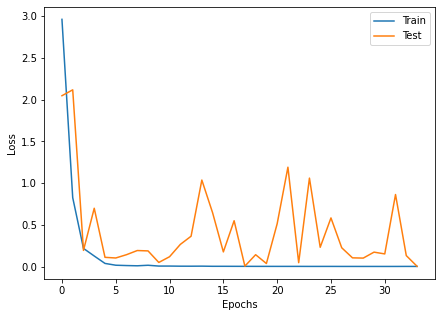

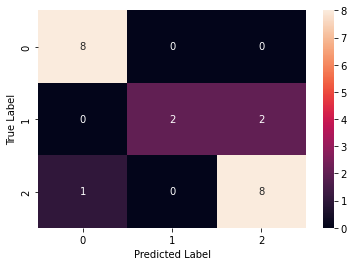

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.880916021086953, Test Loss: 6.5511932373046875
Epoch 2-- Train Loss:1.1767822151834315, Test Loss: 2.6747493743896484
Epoch 3-- Train Loss:0.9354583424600688, Test Loss: 0.534295916557312
Epoch 4-- Train Loss:0.3274007937447591, Test Loss: 1.865082025527954
Epoch 5-- Train Loss:0.4479649993167682, Test Loss: 1.391854166984558
Epoch 6-- Train Loss:0.1165325493467125, Test Loss: 0.11569179594516754
Epoch 7-- Train Loss:0.020836410282010383, Test Loss: 0.02947486750781536
Epoch 8-- Train Loss:0.06744025139646097, Test Loss: 1.8634033203125
Epoch 9-- Train Loss:0.005192360999485986, Test Loss: 0.09509048610925674
Epoch 10-- Train Loss:0.0035043804567645898, Test Loss: 0.9699644446372986
Epoch 11-- Train Loss:0.0029559538075277073, Test Loss: 1.0264593362808228
Epoch 12-- Train Loss:0.003136927542403679, Test Loss: 1.3692156076431274
Epoch 13-- Train Loss:0.0024911874206736684, Test Loss: 1.7560378313064575
Epoc

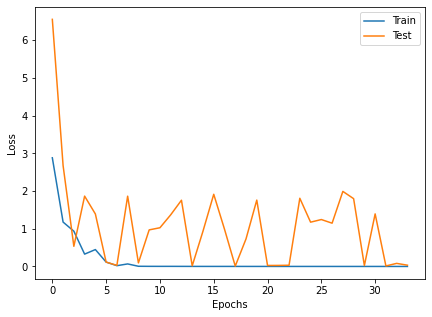

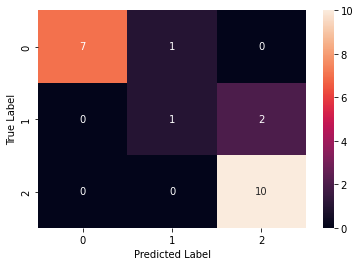

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:3.0365464795719492, Test Loss: 3.863934278488159
Epoch 2-- Train Loss:1.058243448084051, Test Loss: 1.8220970630645752
Epoch 3-- Train Loss:0.5267395411025394, Test Loss: 1.630138874053955
Epoch 4-- Train Loss:0.15811696055937896, Test Loss: 0.9314362406730652
Epoch 5-- Train Loss:0.07413524346934124, Test Loss: 0.7644688487052917
Epoch 6-- Train Loss:0.0737514439070682, Test Loss: 0.5868684649467468
Epoch 7-- Train Loss:0.01036525216080587, Test Loss: 0.11657843738794327
Epoch 8-- Train Loss:0.006498194193806161, Test Loss: 0.4499008059501648
Epoch 9-- Train Loss:0.004139997065067291, Test Loss: 0.0033737209159880877
Epoch 10-- Train Loss:0.0039605422749776735, Test Loss: 0.5712202191352844
Epoch 11-- Train Loss:0.0027800021396780557, Test Loss: 0.6659739017486572
Epoch 12-- Train Loss:0.0028679600641639395, Test Loss: 0.5537675023078918
Epoch 13-- Train Loss:0.002383381085978313, Test Loss: 0.12991632521152

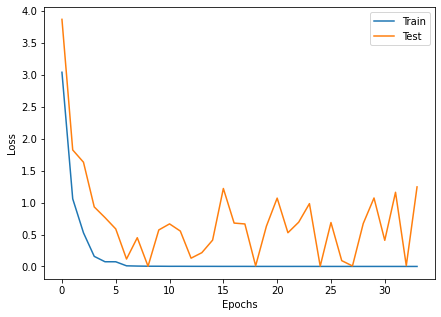

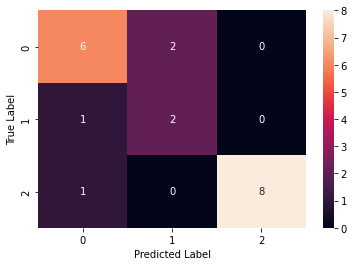

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:3.0718722207979723, Test Loss: 3.058619976043701
Epoch 2-- Train Loss:1.355410023169084, Test Loss: 1.6499998569488525
Epoch 3-- Train Loss:0.5321721272035078, Test Loss: 1.0233371257781982
Epoch 4-- Train Loss:0.20757217772982337, Test Loss: 0.6042748689651489
Epoch 5-- Train Loss:0.1576133854687214, Test Loss: 0.14063052833080292
Epoch 6-- Train Loss:0.04885275585746223, Test Loss: 0.628588080406189
Epoch 7-- Train Loss:0.012273677794093435, Test Loss: 0.002347400179132819
Epoch 8-- Train Loss:0.008530639958652582, Test Loss: 0.05027484521269798
Epoch 9-- Train Loss:0.00691325661980293, Test Loss: 0.0019452573033049703
Epoch 10-- Train Loss:0.005698704097250646, Test Loss: 0.12971210479736328
Epoch 11-- Train Loss:0.004008569394830953, Test Loss: 0.16544100642204285
Epoch 12-- Train Loss:0.0037733262235468083, Test Loss: 0.18432225286960602
Epoch 13-- Train Loss:0.003088482703209262, Test Loss: 0.0112274559

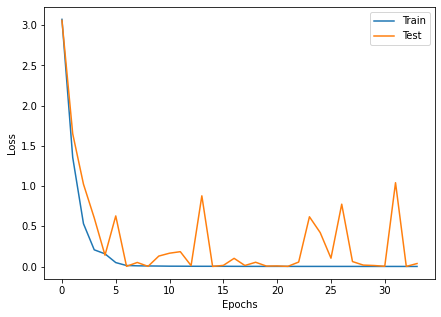

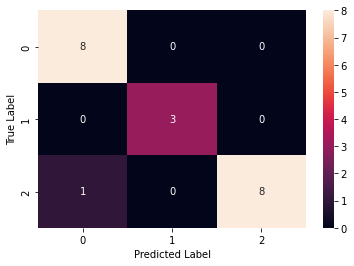

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:2.761146220293912, Test Loss: 7.221610069274902
Epoch 2-- Train Loss:1.718646214766936, Test Loss: 0.45501241087913513
Epoch 3-- Train Loss:0.28650949167257006, Test Loss: 1.8322724103927612
Epoch 4-- Train Loss:0.07576406645503911, Test Loss: 0.30573803186416626
Epoch 5-- Train Loss:0.044027243232862515, Test Loss: 0.34796807169914246
Epoch 6-- Train Loss:0.02925536912781271, Test Loss: 2.914108991622925
Epoch 7-- Train Loss:0.012696230106733063, Test Loss: 0.08835506439208984
Epoch 8-- Train Loss:0.008571377532048658, Test Loss: 0.13876961171627045
Epoch 9-- Train Loss:0.005940110962414606, Test Loss: 0.6519768834114075
Epoch 10-- Train Loss:0.004525568473830142, Test Loss: 2.839581251144409
Epoch 11-- Train Loss:0.003921756616116248, Test Loss: 0.24061530828475952
Epoch 12-- Train Loss:0.003429427086798982, Test Loss: 0.5926302671432495
Epoch 13-- Train Loss:0.002970308478159661, Test Loss: 3.2668063640594

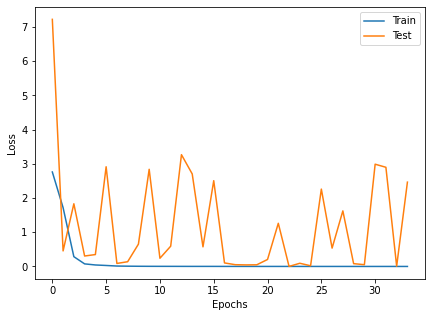

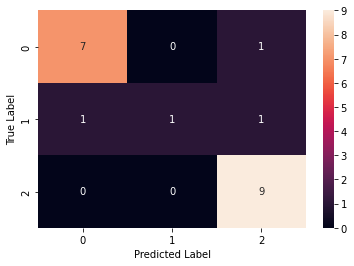

Starting testing
Training Complete
{'0': {'f1-score': '0.89±0.09',
       'precision': '0.883±0.106',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.599±0.156',
       'precision': '0.75±0.224',
       'recall': '0.567±0.249',
       'support': 4},
 '2': {'f1-score': '0.916±0.039',
       'precision': '0.907±0.083',
       'recall': '0.933±0.054',
       'support': 9},
 'accuracy': '0.863±0.049',
 'macro avg': {'f1-score': '0.802±0.07',
               'precision': '0.847±0.069',
               'recall': '0.8±0.085',
               'support': 21},
 'weighted avg': {'f1-score': '0.857±0.05',
                  'precision': '0.875±0.047',
                  'recall': '0.863±0.049',
                  'support': 21}}


In [44]:
for hparam_dict in hparam_list:
    print(hparam_dict)
    name ='bit'
    results = train_model(name=name, dataset=dataset, k_folds =5,  device=device, **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )

## 3.4 Parametric Scattering Network



In [22]:
# Define the grid search for the hyperparameters
hparam_grid = {}
hparam_grid['lr'] = np.arange(1e-4,1e-2, 1e-3)
hparam_grid['batch_size'] = [4, 8, 16, 32]
hparam_grid['num_epochs']=np.arange(10,50, 4)
# Sample from the search space randomly based on number of desired search iterations
n_eval=10
hparam_list = list(ParameterSampler(hparam_grid,
                                    n_iter=n_eval,
                                    random_state=42))


{'num_epochs': 46, 'lr': 0.0001, 'batch_size': 16}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:1.6511743865460933, Test Loss: 1.1504417657852173
Epoch 2-- Train Loss:0.5822375454978707, Test Loss: 1.0148062705993652
Epoch 3-- Train Loss:0.23149222129237992, Test Loss: 0.9111117124557495
Epoch 4-- Train Loss:0.04845491237938404, Test Loss: 1.0157426595687866
Epoch 5-- Train Loss:0.06725978432223201, Test Loss: 0.9200582504272461
Epoch 6-- Train Loss:0.04649618648303052, Test Loss: 0.9207347631454468
Epoch 7-- Train Loss:0.05015535611892119, Test Loss: 0.8441040515899658
Epoch 8-- Train Loss:0.012345837060820486, Test Loss: 0.6933653354644775
Epoch 9-- Train Loss:0.023614153653587284, Test Loss: 0.5501223802566528
Epoch 10-- Train Loss:0.009928850534616155, Test Loss: 0.5849012136459351
Epoch 11-- Train Loss:0.005256984557490796, Test Loss: 0.5305948853492737
Epoch 12-- Train Loss:0.012799799209458248, Test Loss: 0.4603067636489868
E

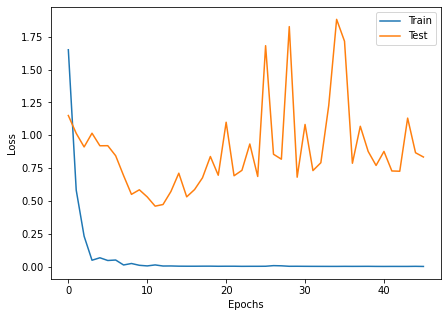

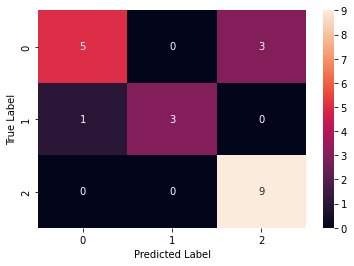

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:2.9232913982123137, Test Loss: 1.0301212072372437
Epoch 2-- Train Loss:1.0346205979585268, Test Loss: 1.1520161628723145
Epoch 3-- Train Loss:1.2983578940232594, Test Loss: 1.0672518014907837
Epoch 4-- Train Loss:5.136768778165181, Test Loss: 1.3330281972885132
Epoch 5-- Train Loss:1.52078173618429, Test Loss: 1.0667085647583008
Epoch 6-- Train Loss:0.32166745823072534, Test Loss: 1.095537543296814
Epoch 7-- Train Loss:0.0887134562205271, Test Loss: 0.8840491771697998
Epoch 8-- Train Loss:0.0465226634598442, Test Loss: 1.005340576171875
Epoch 9-- Train Loss:0.0070974479939044, Test Loss: 0.916653037071228
Epoch 10-- Train Loss:0.007183416261492918, Test Loss: 0.5406287908554077
Epoch 11-- Train Loss:0.004531542720239183, Test Loss: 0.690539538860321
Epoch 12-- Train Loss:0.005922034581682094, Test Loss: 0.4534456729888916
Epoch 13-- Train Loss:0.002644389537939181, Test L

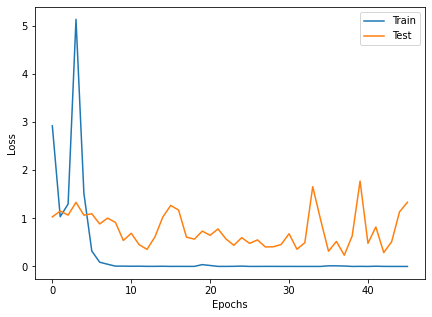

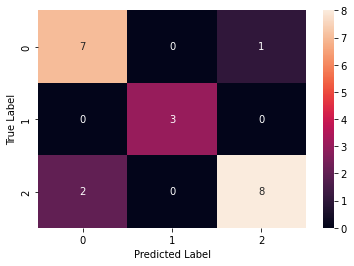

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:1.5656292537848155, Test Loss: 0.9720282554626465
Epoch 2-- Train Loss:2.8592534760634103, Test Loss: 0.8714840412139893
Epoch 3-- Train Loss:1.0070584920661834, Test Loss: 0.8737667202949524
Epoch 4-- Train Loss:0.6825770313541094, Test Loss: 0.9309301376342773
Epoch 5-- Train Loss:0.2650979598268653, Test Loss: 0.5718914270401001
Epoch 6-- Train Loss:0.06468575913459063, Test Loss: 0.6655191779136658
Epoch 7-- Train Loss:0.13457003996397057, Test Loss: 0.8855881094932556
Epoch 8-- Train Loss:0.27187434199731797, Test Loss: 0.8459169864654541
Epoch 9-- Train Loss:0.0034891989392538867, Test Loss: 0.44327205419540405
Epoch 10-- Train Loss:0.004037241024586062, Test Loss: 0.4508535861968994
Epoch 11-- Train Loss:0.008001414074290855, Test Loss: 0.5339147448539734
Epoch 12-- Train Loss:0.002549222253340607, Test Loss: 0.43637463450431824
Epoch 13-- Train Loss:0.002343782034

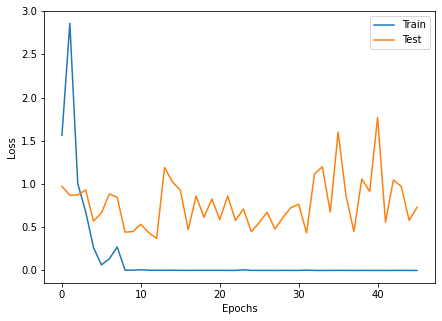

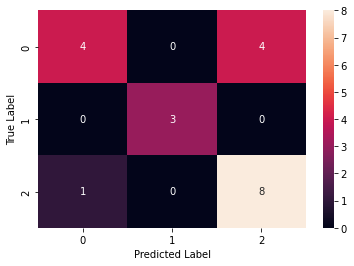

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:3.131433665752411, Test Loss: 1.1396583318710327
Epoch 2-- Train Loss:4.221514344215393, Test Loss: 1.4532406330108643
Epoch 3-- Train Loss:3.1178372303644815, Test Loss: 1.000443935394287
Epoch 4-- Train Loss:0.6394223943352699, Test Loss: 1.0645740032196045
Epoch 5-- Train Loss:0.4353614053787472, Test Loss: 0.9198991060256958
Epoch 6-- Train Loss:0.8594197724790623, Test Loss: 1.3903899192810059
Epoch 7-- Train Loss:5.266639133294423, Test Loss: 0.9573040008544922
Epoch 8-- Train Loss:0.6120207236726097, Test Loss: 0.9385069608688354
Epoch 9-- Train Loss:0.14143271963500106, Test Loss: 0.9366352558135986
Epoch 10-- Train Loss:0.03867601560583959, Test Loss: 1.5413936376571655
Epoch 11-- Train Loss:0.04957202028890606, Test Loss: 1.0207884311676025
Epoch 12-- Train Loss:0.004720363279072141, Test Loss: 0.9744517207145691
Epoch 13-- Train Loss:0.0015142024518960777, Test

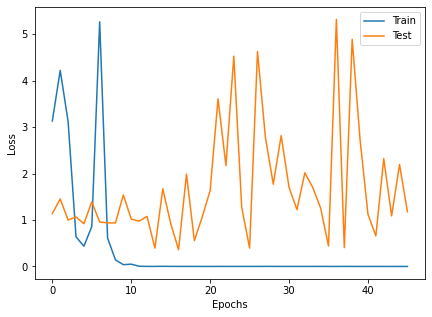

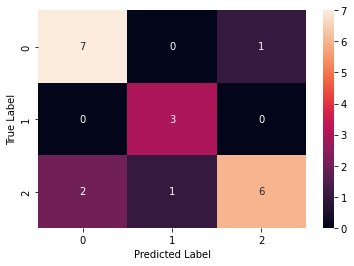

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:1.6634068588415782, Test Loss: 1.1121444702148438
Epoch 2-- Train Loss:2.835181603829066, Test Loss: 1.3070130348205566
Epoch 3-- Train Loss:1.1456007764985163, Test Loss: 1.3857338428497314
Epoch 4-- Train Loss:0.29216893995180726, Test Loss: 1.0738766193389893
Epoch 5-- Train Loss:0.203354045341257, Test Loss: 1.2192039489746094
Epoch 6-- Train Loss:0.016241683490155385, Test Loss: 1.5299885272979736
Epoch 7-- Train Loss:0.004441898665390909, Test Loss: 1.2197320461273193
Epoch 8-- Train Loss:0.004043164876444886, Test Loss: 1.590069055557251
Epoch 9-- Train Loss:0.003612305679922656, Test Loss: 1.4348688125610352
Epoch 10-- Train Loss:0.0030992650523936995, Test Loss: 2.4503140449523926
Epoch 11-- Train Loss:0.0023229689473964754, Test Loss: 2.300811290740967
Epoch 12-- Train Loss:0.0025515648012515157, Test Loss: 2.765249252319336
Epoch 13-- Train Loss:0.0043304184024

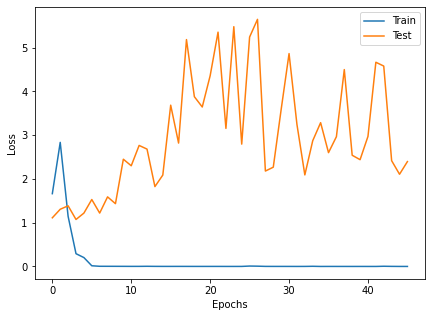

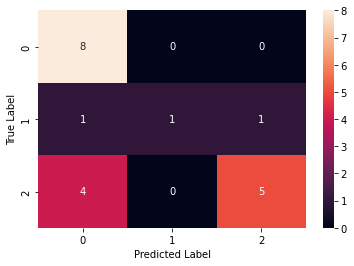

Starting testing
Training Complete
{'0': {'f1-score': '0.75±0.072',
       'precision': '0.76±0.08',
       'recall': '0.775±0.166',
       'support': 8},
 '1': {'f1-score': '0.776±0.174',
       'precision': '0.883±0.145',
       'recall': '0.75±0.247',
       'support': 4},
 '2': {'f1-score': '0.799±0.079',
       'precision': '0.816±0.079',
       'recall': '0.804±0.147',
       'support': 9},
 'accuracy': '0.783±0.054',
 'macro avg': {'f1-score': '0.775±0.071',
               'precision': '0.82±0.04',
               'recall': '0.776±0.078',
               'support': 21},
 'weighted avg': {'f1-score': '0.776±0.061',
                  'precision': '0.806±0.036',
                  'recall': '0.783±0.054',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0081, 'batch_size': 16}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:103.57831572492917, Test Loss: 50.302364349365234
Epoch 2-- Train Loss:50.06020641326904, Test Loss:

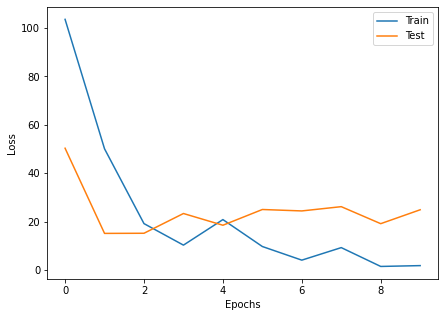

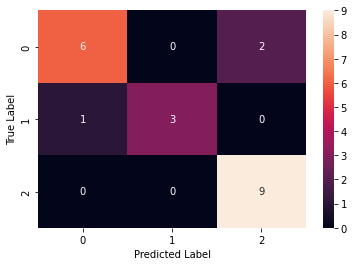

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:111.90040461222331, Test Loss: 111.46141052246094
Epoch 2-- Train Loss:183.40191459655762, Test Loss: 122.8553466796875
Epoch 3-- Train Loss:74.5921745300293, Test Loss: 107.31045532226562
Epoch 4-- Train Loss:21.803032716115315, Test Loss: 134.55699157714844
Epoch 5-- Train Loss:3.8641338096931577, Test Loss: 113.49242401123047
Epoch 6-- Train Loss:16.56623109181722, Test Loss: 118.1807861328125
Epoch 7-- Train Loss:12.43163832028707, Test Loss: 135.43043518066406
Epoch 8-- Train Loss:36.146386901537575, Test Loss: 246.7410430908203
Epoch 9-- Train Loss:157.88753445943198, Test Loss: 75.0262451171875
Epoch 10-- Train Loss:32.489848931630455, Test Loss: 49.65795135498047


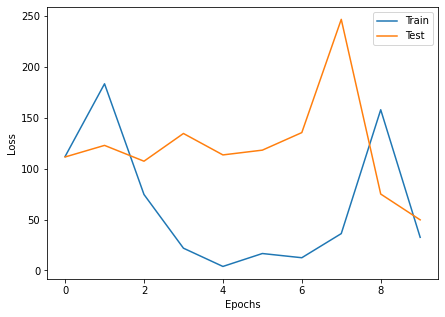

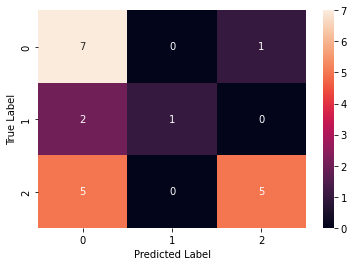

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:126.87295919656754, Test Loss: 49.896419525146484
Epoch 2-- Train Loss:84.1699784596761, Test Loss: 18.649044036865234
Epoch 3-- Train Loss:47.69590280453364, Test Loss: 24.222370147705078
Epoch 4-- Train Loss:62.30094941457113, Test Loss: 19.868228912353516
Epoch 5-- Train Loss:18.787534435590107, Test Loss: 33.168880462646484
Epoch 6-- Train Loss:20.183070023854572, Test Loss: 4.596272945404053
Epoch 7-- Train Loss:3.9278223514556885, Test Loss: 17.681289672851562
Epoch 8-- Train Loss:1.4661694169044495, Test Loss: 9.781993865966797
Epoch 9-- Train Loss:1.6681640148162842, Test Loss: 24.47271728515625
Epoch 10-- Train Loss:2.674198849162243, Test Loss: 37.4898681640625


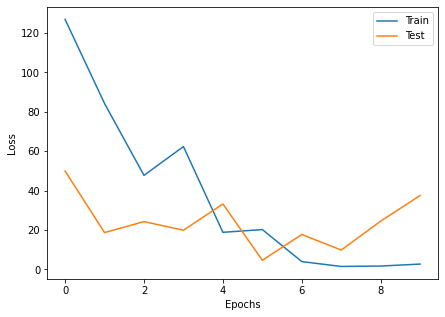

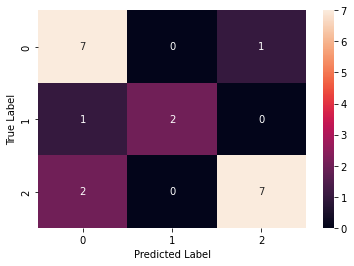

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:98.42836034297943, Test Loss: 24.723114013671875
Epoch 2-- Train Loss:42.488877614339195, Test Loss: 15.384228706359863
Epoch 3-- Train Loss:5.5402186852443265, Test Loss: 17.158065795898438
Epoch 4-- Train Loss:0.027576065183630316, Test Loss: 9.213299751281738
Epoch 5-- Train Loss:3.9361180011487704, Test Loss: 12.387535095214844
Epoch 6-- Train Loss:20.61961093793313, Test Loss: 16.84701919555664
Epoch 7-- Train Loss:6.380662739276886, Test Loss: 5.8872480392456055
Epoch 8-- Train Loss:1.1163590749104817, Test Loss: 47.29890441894531
Epoch 9-- Train Loss:3.1775042696875366, Test Loss: 11.685592651367188
Epoch 10-- Train Loss:0.0, Test Loss: 10.646820068359375


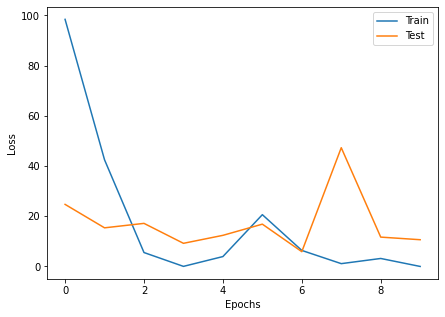

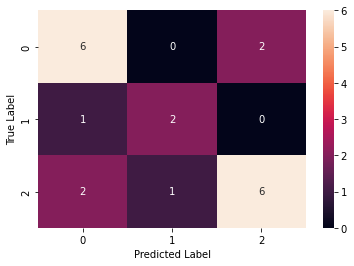

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:107.61732884248097, Test Loss: 23.418249130249023
Epoch 2-- Train Loss:55.029897133509316, Test Loss: 48.48973083496094
Epoch 3-- Train Loss:28.53223458925883, Test Loss: 46.32744598388672
Epoch 4-- Train Loss:6.218947847684224, Test Loss: 37.771095275878906
Epoch 5-- Train Loss:20.071238199869793, Test Loss: 71.89520263671875
Epoch 6-- Train Loss:1.92353355884552, Test Loss: 61.730960845947266
Epoch 7-- Train Loss:1.6490691651900609, Test Loss: 37.34540557861328
Epoch 8-- Train Loss:0.004099099275966485, Test Loss: 82.07833099365234
Epoch 9-- Train Loss:0.0, Test Loss: 34.319786071777344
Epoch 10-- Train Loss:0.0, Test Loss: 87.01069641113281


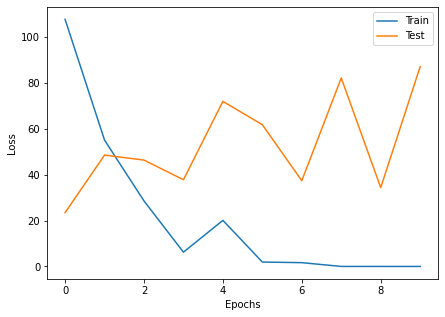

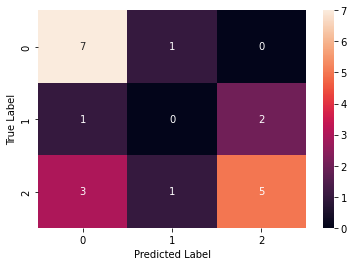

Starting testing
Training Complete
{'0': {'f1-score': '0.761±0.069',
       'precision': '0.669±0.089',
       'recall': '0.9±0.094',
       'support': 8},
 '1': {'f1-score': '0.546±0.304',
       'precision': '0.7±0.4',
       'recall': '0.483±0.281',
       'support': 4},
 '2': {'f1-score': '0.754±0.107',
       'precision': '0.86±0.092',
       'recall': '0.678±0.124',
       'support': 9},
 'accuracy': '0.735±0.089',
 'macro avg': {'f1-score': '0.687±0.14',
               'precision': '0.743±0.157',
               'recall': '0.687±0.123',
               'support': 21},
 'weighted avg': {'f1-score': '0.726±0.103',
                  'precision': '0.761±0.103',
                  'recall': '0.735±0.089',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0031, 'batch_size': 4}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:92.37613421110879, Test Loss: 36.70851516723633
Epoch 2-- Train Loss:55.70680775488089, Test Loss: 19.5

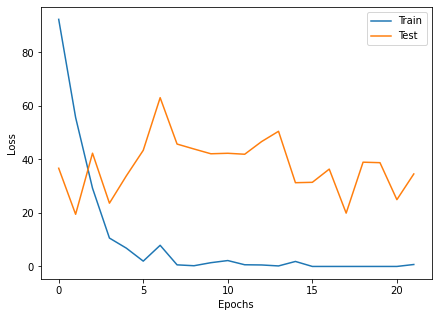

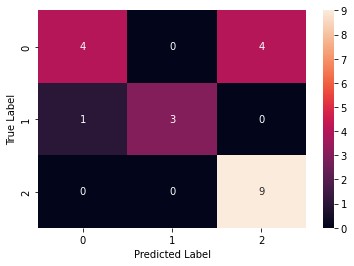

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:101.70661531175885, Test Loss: 57.75191116333008
Epoch 2-- Train Loss:59.6505012512207, Test Loss: 18.176950454711914
Epoch 3-- Train Loss:10.9151778666757, Test Loss: 25.35483741760254
Epoch 4-- Train Loss:27.65939867973239, Test Loss: 20.570558547973633
Epoch 5-- Train Loss:5.084231361303301, Test Loss: 1.8826287984848022
Epoch 6-- Train Loss:21.800607309454964, Test Loss: 163.66514587402344
Epoch 7-- Train Loss:29.156563614095962, Test Loss: 36.586456298828125
Epoch 8-- Train Loss:2.5399411973499118, Test Loss: 23.60907554626465
Epoch 9-- Train Loss:0.8848304336979276, Test Loss: 15.933135032653809
Epoch 10-- Train Loss:0.891941853931972, Test Loss: 37.79549789428711
Epoch 11-- Train Loss:3.372398194812593, Test Loss: 22.960830688476562
Epoch 12-- Train Loss:4.235403333391462, Test Loss: 25.42213249206543
Epoch 13-- Train Loss:0.34119604315076557, Test Loss: 7.14678716

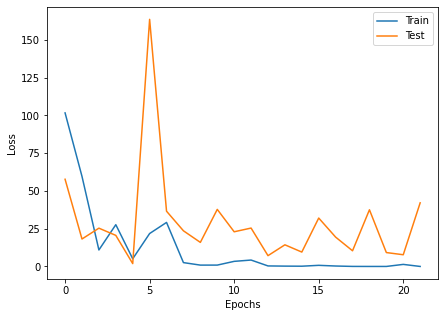

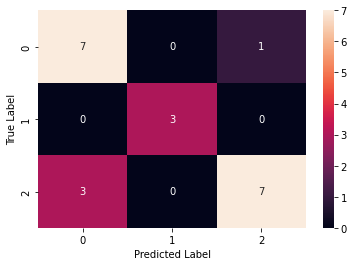

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:95.51029410248711, Test Loss: 19.969770431518555
Epoch 2-- Train Loss:28.059999934470266, Test Loss: 10.817789077758789
Epoch 3-- Train Loss:21.483828953334264, Test Loss: 32.66810607910156
Epoch 4-- Train Loss:20.525797700899602, Test Loss: 65.2643051147461
Epoch 5-- Train Loss:26.24332246326265, Test Loss: 32.575050354003906
Epoch 6-- Train Loss:3.7073683147668057, Test Loss: 31.3445987701416
Epoch 7-- Train Loss:2.615264353522521, Test Loss: 55.87635040283203
Epoch 8-- Train Loss:6.494173367818196, Test Loss: 39.62576675415039
Epoch 9-- Train Loss:9.553968747456869, Test Loss: 65.23304748535156
Epoch 10-- Train Loss:1.400850114368257, Test Loss: 77.43568420410156
Epoch 11-- Train Loss:0.9339117116871334, Test Loss: 54.56764602661133
Epoch 12-- Train Loss:1.747854369027274, Test Loss: 69.93946075439453
Epoch 13-- Train Loss:5.561933971586681, Test Loss: 95.4262771606445

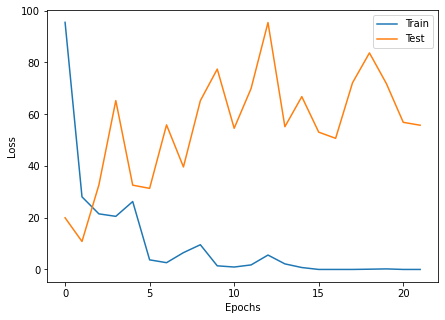

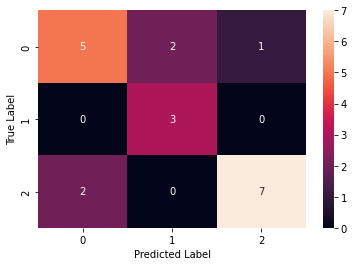

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:108.66973259903136, Test Loss: 14.334142684936523
Epoch 2-- Train Loss:41.378237376687174, Test Loss: 21.250356674194336
Epoch 3-- Train Loss:35.0281077472263, Test Loss: 15.852078437805176
Epoch 4-- Train Loss:3.724151683705194, Test Loss: 19.411285400390625
Epoch 5-- Train Loss:3.907490230741955, Test Loss: 9.857979774475098
Epoch 6-- Train Loss:1.6340843968656533, Test Loss: 17.565092086791992
Epoch 7-- Train Loss:0.7869820367722284, Test Loss: 9.500494003295898
Epoch 8-- Train Loss:1.0076496257431808, Test Loss: 9.434274673461914
Epoch 9-- Train Loss:0.8864006996154785, Test Loss: 45.682640075683594
Epoch 10-- Train Loss:1.2052604171310402, Test Loss: 52.68851852416992
Epoch 11-- Train Loss:1.1249215440115048, Test Loss: 12.192028999328613
Epoch 12-- Train Loss:0.0, Test Loss: 6.158274173736572
Epoch 13-- Train Loss:1.419158124349451e-09, Test Loss: 7.383092403411865


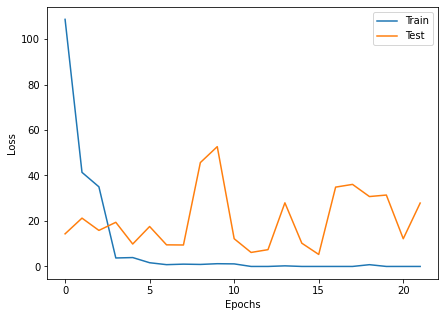

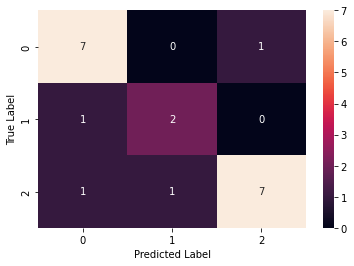

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:63.380045759258294, Test Loss: 23.160634994506836
Epoch 2-- Train Loss:33.25526408197233, Test Loss: 44.13278579711914
Epoch 3-- Train Loss:4.67782709910465, Test Loss: 86.77767181396484
Epoch 4-- Train Loss:25.979680404669914, Test Loss: 96.69071960449219
Epoch 5-- Train Loss:7.887900052374572, Test Loss: 128.8382110595703
Epoch 6-- Train Loss:8.153083298112355, Test Loss: 147.3677978515625
Epoch 7-- Train Loss:6.658121961259271, Test Loss: 129.391357421875
Epoch 8-- Train Loss:3.499230521065848, Test Loss: 132.2176055908203
Epoch 9-- Train Loss:0.1198598986233362, Test Loss: 136.3856201171875
Epoch 10-- Train Loss:0.7852445342856905, Test Loss: 121.28184509277344
Epoch 11-- Train Loss:4.851027023224604, Test Loss: 140.59963989257812
Epoch 12-- Train Loss:0.6477667490641276, Test Loss: 124.25579833984375
Epoch 13-- Train Loss:0.0, Test Loss: 110.30252838134766
Epoch 14--

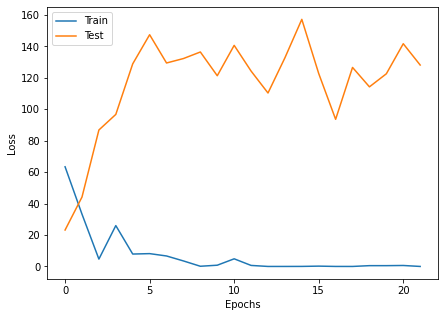

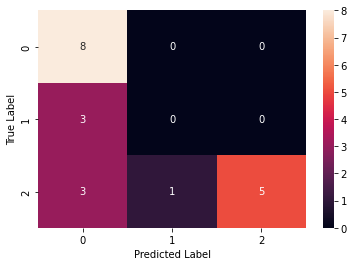

Starting testing
Training Complete
{'0': {'f1-score': '0.731±0.112',
       'precision': '0.715±0.124',
       'recall': '0.8±0.203',
       'support': 8},
 '1': {'f1-score': '0.631±0.318',
       'precision': '0.62±0.336',
       'recall': '0.683±0.367',
       'support': 4},
 '2': {'f1-score': '0.81±0.058',
       'precision': '0.9±0.094',
       'recall': '0.762±0.144',
       'support': 9},
 'accuracy': '0.765±0.08',
 'macro avg': {'f1-score': '0.724±0.138',
               'precision': '0.745±0.128',
               'recall': '0.749±0.132',
               'support': 21},
 'weighted avg': {'f1-score': '0.752±0.095',
                  'precision': '0.784±0.082',
                  'recall': '0.765±0.08',
                  'support': 21}}
{'num_epochs': 10, 'lr': 0.0011, 'batch_size': 16}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:16.75921709338824, Test Loss: 4.580846786499023
Epoch 2-- Train Loss:8.995615601539612, Test Loss: 3.0

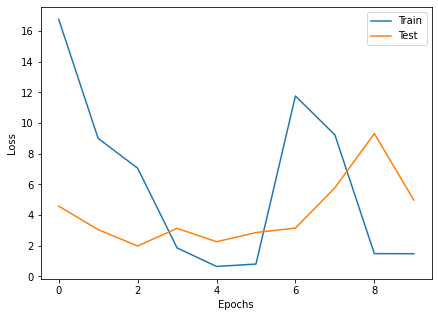

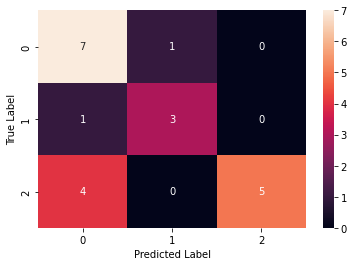

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:25.96028423309326, Test Loss: 13.050182342529297
Epoch 2-- Train Loss:75.13512849807739, Test Loss: 11.654740333557129
Epoch 3-- Train Loss:24.903452157974243, Test Loss: 6.957282543182373
Epoch 4-- Train Loss:5.113679728160302, Test Loss: 7.9141974449157715
Epoch 5-- Train Loss:1.297555389503638, Test Loss: 8.361318588256836
Epoch 6-- Train Loss:4.1156858239943785, Test Loss: 9.378369331359863
Epoch 7-- Train Loss:10.725498954455057, Test Loss: 6.303571701049805
Epoch 8-- Train Loss:9.833275040380613, Test Loss: 19.59493637084961
Epoch 9-- Train Loss:20.495781262715656, Test Loss: 5.885649681091309
Epoch 10-- Train Loss:12.678665002187094, Test Loss: 5.0723676681518555


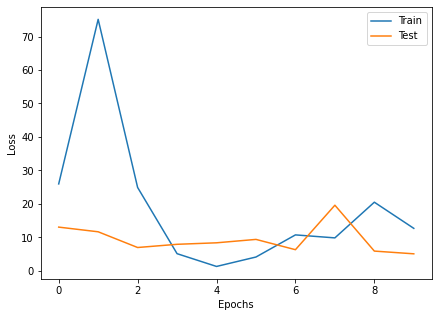

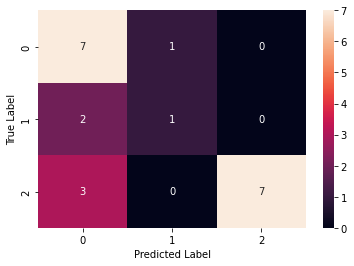

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:22.768731653690338, Test Loss: 2.8643717765808105
Epoch 2-- Train Loss:32.060855547587074, Test Loss: 3.2916884422302246
Epoch 3-- Train Loss:21.140968778481085, Test Loss: 1.7294597625732422
Epoch 4-- Train Loss:3.1184152960777283, Test Loss: 2.1001949310302734
Epoch 5-- Train Loss:2.309340465736265, Test Loss: 0.5479445457458496
Epoch 6-- Train Loss:0.17923138508043243, Test Loss: 0.5573008060455322
Epoch 7-- Train Loss:0.05852669099381084, Test Loss: 1.3971116542816162
Epoch 8-- Train Loss:2.571990349548734, Test Loss: 1.291422963142395
Epoch 9-- Train Loss:0.8978898284167881, Test Loss: 1.7821537256240845
Epoch 10-- Train Loss:0.292026540644822, Test Loss: 7.4700798988342285


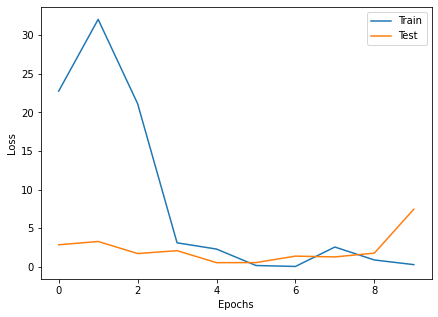

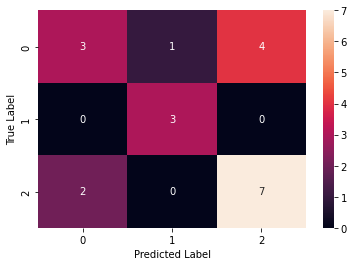

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:16.81910264492035, Test Loss: 4.009797096252441
Epoch 2-- Train Loss:12.864389340082804, Test Loss: 9.770644187927246
Epoch 3-- Train Loss:22.3144207795461, Test Loss: 6.113746643066406
Epoch 4-- Train Loss:0.8085446884797722, Test Loss: 1.8692439794540405
Epoch 5-- Train Loss:4.395057688777645, Test Loss: 4.175962448120117
Epoch 6-- Train Loss:1.2542028472918985, Test Loss: 2.1809473037719727
Epoch 7-- Train Loss:0.1656383041687756, Test Loss: 2.0772407054901123
Epoch 8-- Train Loss:0.005566284075513295, Test Loss: 11.787336349487305
Epoch 9-- Train Loss:1.113564499869805e-09, Test Loss: 1.400331735610962
Epoch 10-- Train Loss:0.027143657207489014, Test Loss: 1.735086441040039


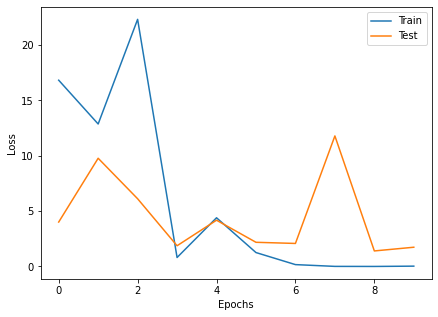

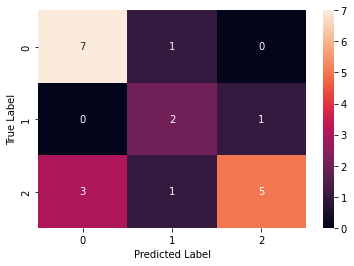

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:24.08553461233775, Test Loss: 3.488267183303833
Epoch 2-- Train Loss:15.036925474802652, Test Loss: 8.082771301269531
Epoch 3-- Train Loss:9.859704538711156, Test Loss: 8.107667922973633
Epoch 4-- Train Loss:1.7362929383913677, Test Loss: 6.098049640655518
Epoch 5-- Train Loss:4.522598348926291, Test Loss: 11.471298217773438
Epoch 6-- Train Loss:0.9120790702679642, Test Loss: 11.383469581604004
Epoch 7-- Train Loss:0.67664781325013, Test Loss: 5.908659934997559
Epoch 8-- Train Loss:0.021244244805226725, Test Loss: 16.781036376953125
Epoch 9-- Train Loss:0.09283838669459026, Test Loss: 5.468703746795654
Epoch 10-- Train Loss:0.0013078375866192686, Test Loss: 18.542869567871094


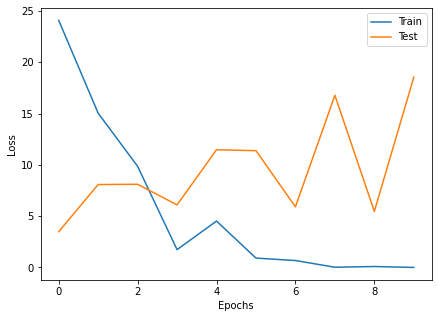

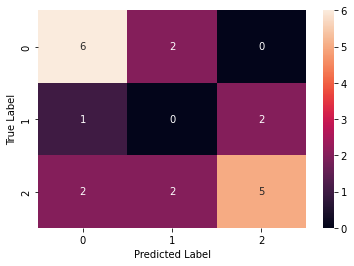

Starting testing
Training Complete
{'0': {'f1-score': '0.666±0.134',
       'precision': '0.621±0.069',
       'recall': '0.75±0.224',
       'support': 8},
 '1': {'f1-score': '0.571±0.295',
       'precision': '0.537±0.273',
       'recall': '0.617±0.332',
       'support': 4},
 '2': {'f1-score': '0.679±0.097',
       'precision': '0.803±0.162',
       'recall': '0.607±0.118',
       'support': 9},
 'accuracy': '0.667±0.077',
 'macro avg': {'f1-score': '0.639±0.102',
               'precision': '0.654±0.115',
               'recall': '0.658±0.104',
               'support': 21},
 'weighted avg': {'f1-score': '0.659±0.081',
                  'precision': '0.692±0.102',
                  'recall': '0.667±0.077',
                  'support': 21}}
{'num_epochs': 22, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:163.6616039815403, Test Loss: 152.18727111816406
Epoch 2-- Train Loss:64.8485437461308, Test Los

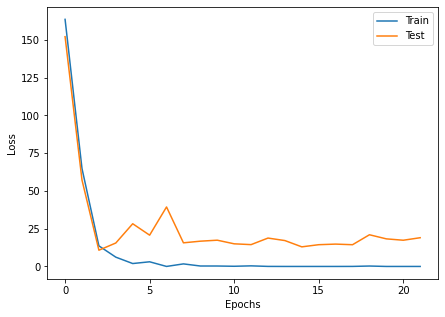

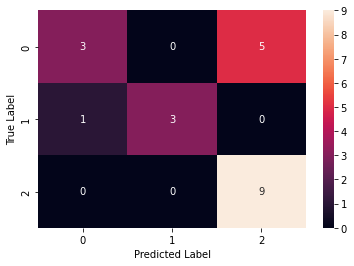

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:249.56347397395544, Test Loss: 104.3151626586914
Epoch 2-- Train Loss:29.153913358936, Test Loss: 17.96698760986328
Epoch 3-- Train Loss:2.2188158415790116, Test Loss: 2.730851173400879
Epoch 4-- Train Loss:6.429536004067984, Test Loss: 8.251456260681152
Epoch 5-- Train Loss:5.452665255220588, Test Loss: 1.9049865007400513
Epoch 6-- Train Loss:3.8540228164793873, Test Loss: 1.3258180618286133
Epoch 7-- Train Loss:1.6266301051070657, Test Loss: 2.9626963138580322
Epoch 8-- Train Loss:0.6764732471410103, Test Loss: 1.3046640157699585
Epoch 9-- Train Loss:1.1094981710515879, Test Loss: 1.3858922719955444
Epoch 10-- Train Loss:0.6776713623021036, Test Loss: 1.6784600019454956
Epoch 11-- Train Loss:1.1264744779770004, Test Loss: 2.362027645111084
Epoch 12-- Train Loss:0.33301387966812834, Test Loss: 1.6766963005065918
Epoch 13-- Train Loss:0.23905732089878934, Test Loss: 1.627

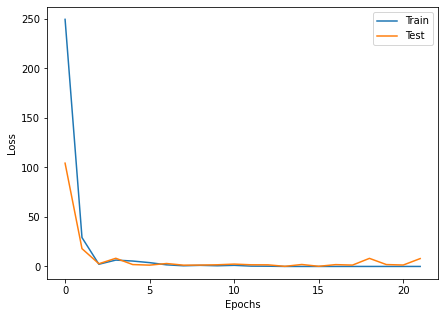

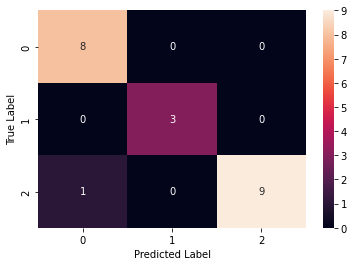

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:172.57342408721647, Test Loss: 97.26365661621094
Epoch 2-- Train Loss:59.84091599782308, Test Loss: 11.140161514282227
Epoch 3-- Train Loss:19.65133326601274, Test Loss: 13.648183822631836
Epoch 4-- Train Loss:11.331037311947771, Test Loss: 25.89949607849121
Epoch 5-- Train Loss:6.5144685889149105, Test Loss: 5.557933807373047
Epoch 6-- Train Loss:2.3172567018497867, Test Loss: 1.5052396059036255
Epoch 7-- Train Loss:0.9713005952837177, Test Loss: 5.206497669219971
Epoch 8-- Train Loss:0.7915613187583901, Test Loss: 1.4481995105743408
Epoch 9-- Train Loss:0.5609313611457251, Test Loss: 1.0415135622024536
Epoch 10-- Train Loss:0.02376142837220825, Test Loss: 3.057809352874756
Epoch 11-- Train Loss:0.056962580312365674, Test Loss: 4.227568626403809
Epoch 12-- Train Loss:0.08737309523475763, Test Loss: 4.131415367126465
Epoch 13-- Train Loss:0.00013446308337130457, Test Loss

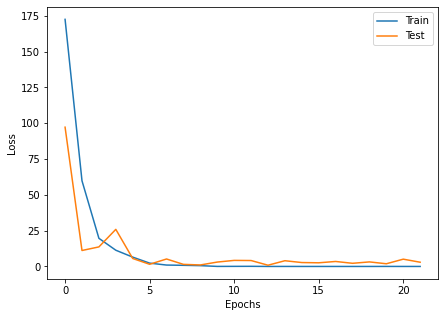

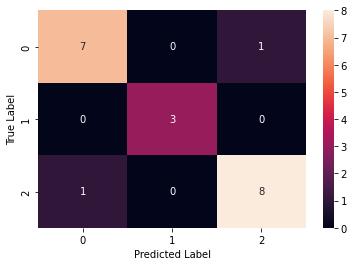

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:197.58461725711823, Test Loss: 12.970271110534668
Epoch 2-- Train Loss:26.710553864763607, Test Loss: 29.083200454711914
Epoch 3-- Train Loss:7.8075049596993615, Test Loss: 7.231724739074707
Epoch 4-- Train Loss:5.690551463852259, Test Loss: 38.05843734741211
Epoch 5-- Train Loss:5.366771344594817, Test Loss: 8.041047096252441
Epoch 6-- Train Loss:0.444839873068965, Test Loss: 9.133749008178711
Epoch 7-- Train Loss:1.261173232160478, Test Loss: 15.505955696105957
Epoch 8-- Train Loss:1.749733836805847, Test Loss: 4.968453884124756
Epoch 9-- Train Loss:1.469561543371085, Test Loss: 5.022193908691406
Epoch 10-- Train Loss:0.36812490776769413, Test Loss: 5.041144371032715
Epoch 11-- Train Loss:0.0116602066995421, Test Loss: 1.8461910486221313
Epoch 12-- Train Loss:0.06319776693650594, Test Loss: 3.540133237838745
Epoch 13-- Train Loss:0.010981538233040954, Test Loss: 6.68797

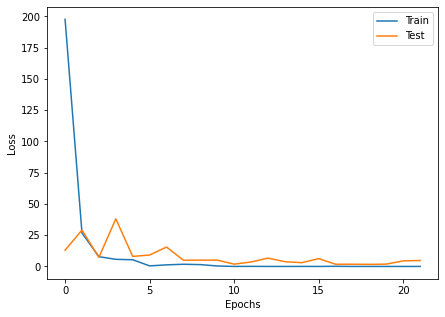

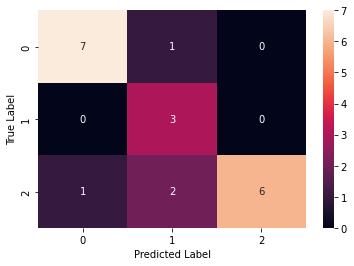

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:178.05514855611892, Test Loss: 195.2045135498047
Epoch 2-- Train Loss:62.23021722407568, Test Loss: 38.63882827758789
Epoch 3-- Train Loss:10.683061038147063, Test Loss: 63.663246154785156
Epoch 4-- Train Loss:12.155112860635633, Test Loss: 15.080123901367188
Epoch 5-- Train Loss:2.5206155502020833, Test Loss: 33.2454719543457
Epoch 6-- Train Loss:1.529195291397281, Test Loss: 26.80592918395996
Epoch 7-- Train Loss:0.2316215889794486, Test Loss: 25.382307052612305
Epoch 8-- Train Loss:0.18910729885101318, Test Loss: 23.497777938842773
Epoch 9-- Train Loss:0.16683819006317163, Test Loss: 25.618764877319336
Epoch 10-- Train Loss:0.8653254179599961, Test Loss: 20.85597801208496
Epoch 11-- Train Loss:0.020172760408881697, Test Loss: 19.1193790435791
Epoch 12-- Train Loss:6.250518409734425e-09, Test Loss: 17.827484130859375
Epoch 13-- Train Loss:8.469069143757224e-07, Test Los

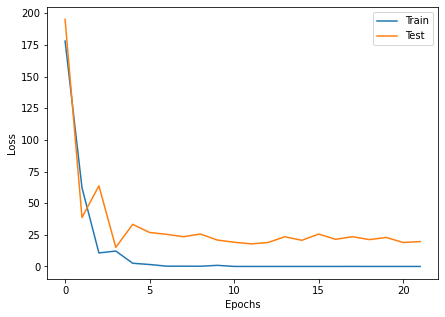

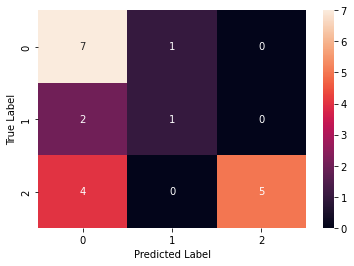

Starting testing
Training Complete
{'0': {'f1-score': '0.738±0.208',
       'precision': '0.739±0.132',
       'recall': '0.8±0.281',
       'support': 8},
 '1': {'f1-score': '0.823±0.221',
       'precision': '0.85±0.2',
       'recall': '0.817±0.26',
       'support': 4},
 '2': {'f1-score': '0.803±0.097',
       'precision': '0.898±0.155',
       'recall': '0.78±0.187',
       'support': 9},
 'accuracy': '0.794±0.121',
 'macro avg': {'f1-score': '0.788±0.144',
               'precision': '0.829±0.104',
               'recall': '0.799±0.147',
               'support': 21},
 'weighted avg': {'f1-score': '0.782±0.131',
                  'precision': '0.831±0.096',
                  'recall': '0.794±0.121',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0081, 'batch_size': 4}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:171.52063227460272, Test Loss: 115.30496215820312
Epoch 2-- Train Loss:66.21521709078834, Test Loss: 1

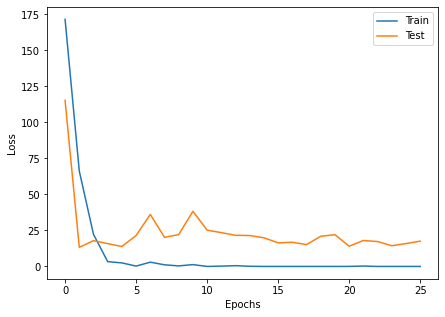

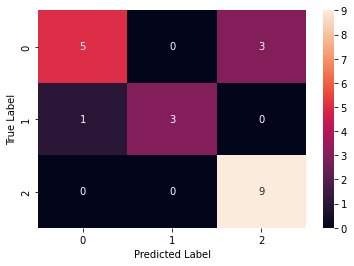

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:183.36928977852776, Test Loss: 133.1552276611328
Epoch 2-- Train Loss:40.63728859611586, Test Loss: 33.47072219848633
Epoch 3-- Train Loss:13.189092124878828, Test Loss: 19.200822830200195
Epoch 4-- Train Loss:6.620843981965301, Test Loss: 16.26988410949707
Epoch 5-- Train Loss:6.2308801128750755, Test Loss: 12.849854469299316
Epoch 6-- Train Loss:1.5571461896137802, Test Loss: 4.539853572845459
Epoch 7-- Train Loss:1.14891423871755, Test Loss: 6.412362575531006
Epoch 8-- Train Loss:2.095709671361792, Test Loss: 4.927430629730225
Epoch 9-- Train Loss:0.3157823568747387, Test Loss: 3.5498101711273193
Epoch 10-- Train Loss:0.21175336936080136, Test Loss: 5.665482997894287
Epoch 11-- Train Loss:0.0, Test Loss: 6.311032772064209
Epoch 12-- Train Loss:6.556609644294196e-05, Test Loss: 8.360015869140625
Epoch 13-- Train Loss:1.3983896555000035e-07, Test Loss: 6.674699783325195


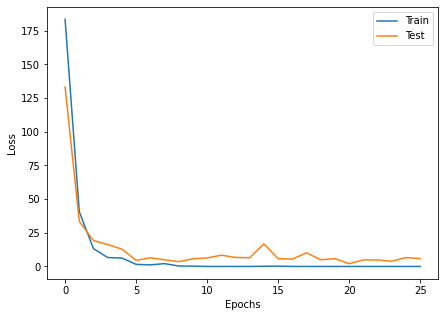

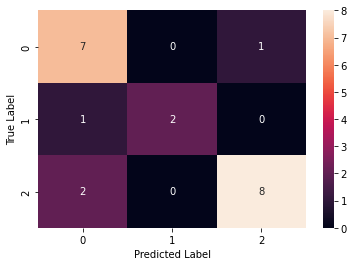

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:154.5196374616438, Test Loss: 115.5584945678711
Epoch 2-- Train Loss:82.71949023292179, Test Loss: 8.212045669555664
Epoch 3-- Train Loss:14.883793797014267, Test Loss: 4.352194309234619
Epoch 4-- Train Loss:2.96974474374637, Test Loss: 2.978379249572754
Epoch 5-- Train Loss:4.324761489818735, Test Loss: 9.22144889831543
Epoch 6-- Train Loss:1.6412589464009562, Test Loss: 7.6510772705078125
Epoch 7-- Train Loss:0.8029964810739488, Test Loss: 2.272080183029175
Epoch 8-- Train Loss:0.22814632947881988, Test Loss: 3.0642991065979004
Epoch 9-- Train Loss:0.27102724763173025, Test Loss: 3.80823016166687
Epoch 10-- Train Loss:0.0032955149194855322, Test Loss: 5.163234710693359
Epoch 11-- Train Loss:0.12782040366229402, Test Loss: 2.9202330112457275
Epoch 12-- Train Loss:0.26942498979787194, Test Loss: 2.952052593231201
Epoch 13-- Train Loss:0.5717019466764244, Test Loss: 5.8765

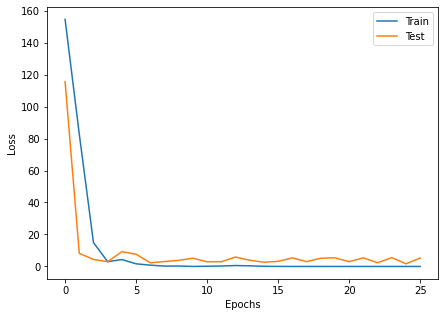

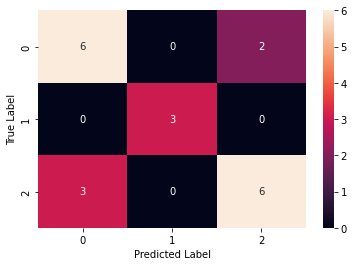

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:172.78267531735557, Test Loss: 147.6084442138672
Epoch 2-- Train Loss:49.311935089439864, Test Loss: 23.344646453857422
Epoch 3-- Train Loss:14.876958618663656, Test Loss: 40.13240432739258
Epoch 4-- Train Loss:12.639418267247189, Test Loss: 18.873279571533203
Epoch 5-- Train Loss:10.127180311101933, Test Loss: 21.279653549194336
Epoch 6-- Train Loss:2.998590413725673, Test Loss: 4.860346794128418
Epoch 7-- Train Loss:0.16987701977613293, Test Loss: 4.770676612854004
Epoch 8-- Train Loss:1.76606480493432, Test Loss: 13.937227249145508
Epoch 9-- Train Loss:0.6803658604795557, Test Loss: 3.34373140335083
Epoch 10-- Train Loss:3.689757010403939e-07, Test Loss: 5.0763258934021
Epoch 11-- Train Loss:0.38991564018088604, Test Loss: 2.822826385498047
Epoch 12-- Train Loss:0.0, Test Loss: 1.8232110738754272
Epoch 13-- Train Loss:0.0032643902869451615, Test Loss: 2.170809268951416

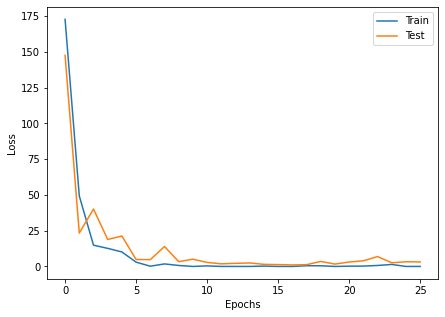

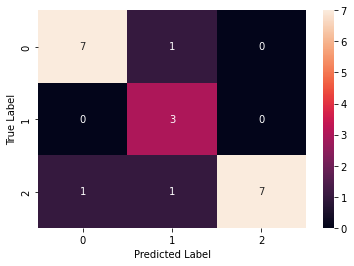

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:167.2629785594486, Test Loss: 209.4736785888672
Epoch 2-- Train Loss:71.04760645968574, Test Loss: 50.521331787109375
Epoch 3-- Train Loss:12.561126986349342, Test Loss: 74.96988677978516
Epoch 4-- Train Loss:14.295756294613792, Test Loss: 52.76530075073242
Epoch 5-- Train Loss:1.3563980745918798, Test Loss: 43.11423873901367
Epoch 6-- Train Loss:6.36486027796119, Test Loss: 41.976844787597656
Epoch 7-- Train Loss:0.6744597154091595, Test Loss: 70.06574249267578
Epoch 8-- Train Loss:0.053196076835904806, Test Loss: 68.20803833007812
Epoch 9-- Train Loss:2.0849014323020603, Test Loss: 36.16522979736328
Epoch 10-- Train Loss:0.2900497705808708, Test Loss: 48.03092575073242
Epoch 11-- Train Loss:0.19623488066939726, Test Loss: 52.998252868652344
Epoch 12-- Train Loss:0.3449708989688328, Test Loss: 53.2072868347168
Epoch 13-- Train Loss:0.8582093945102921, Test Loss: 52.02779

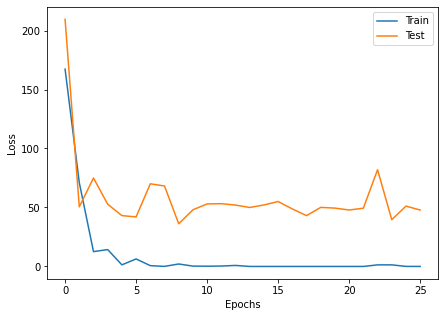

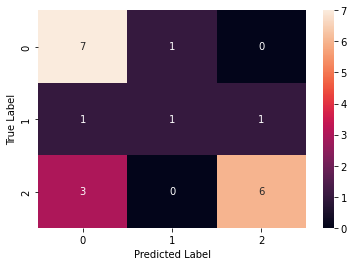

Starting testing
Training Complete
{'0': {'f1-score': '0.739±0.116',
       'precision': '0.715±0.111',
       'recall': '0.8±0.187',
       'support': 8},
 '1': {'f1-score': '0.786±0.212',
       'precision': '0.9±0.2',
       'recall': '0.75±0.247',
       'support': 4},
 '2': {'f1-score': '0.791±0.088',
       'precision': '0.856±0.133',
       'recall': '0.76±0.148',
       'support': 9},
 'accuracy': '0.773±0.104',
 'macro avg': {'f1-score': '0.772±0.125',
               'precision': '0.824±0.089',
               'recall': '0.77±0.136',
               'support': 21},
 'weighted avg': {'f1-score': '0.771±0.105',
                  'precision': '0.809±0.09',
                  'recall': '0.773±0.104',
                  'support': 21}}
{'num_epochs': 46, 'lr': 0.0021, 'batch_size': 32}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:14.879828055699667, Test Loss: 2.1787619590759277
Epoch 2-- Train Loss:23.331278642018635, Test Loss: 3.

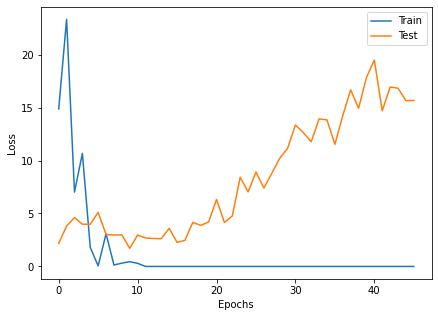

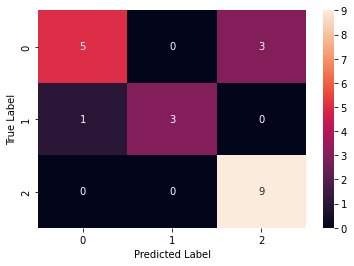

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:38.7442421913147, Test Loss: 2.1315395832061768
Epoch 2-- Train Loss:22.48860462506612, Test Loss: 5.519809246063232
Epoch 3-- Train Loss:14.682569742202759, Test Loss: 4.605408191680908
Epoch 4-- Train Loss:3.3301844199498496, Test Loss: 2.270838737487793
Epoch 5-- Train Loss:5.605872472127278, Test Loss: 3.4128849506378174
Epoch 6-- Train Loss:0.8916014830271403, Test Loss: 4.4948883056640625
Epoch 7-- Train Loss:0.541615811487039, Test Loss: 3.4655051231384277
Epoch 8-- Train Loss:3.9388723373413086, Test Loss: 4.600481033325195
Epoch 9-- Train Loss:0.07330616315205891, Test Loss: 4.810766696929932
Epoch 10-- Train Loss:0.12130457162857056, Test Loss: 4.0088605880737305
Epoch 11-- Train Loss:1.3261558725237896e-07, Test Loss: 3.448941469192505
Epoch 12-- Train Loss:4.756515300149052e-08, Test Loss: 3.0511951446533203
Epoch 13-- Train Loss:1.546827292031594e-06, Test Lo

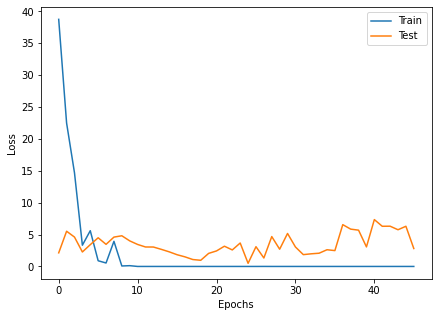

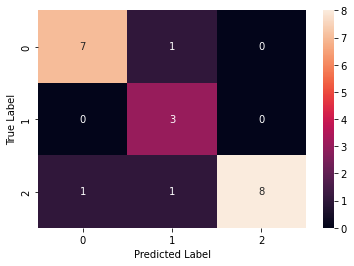

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:17.86856484413147, Test Loss: 2.8469204902648926
Epoch 2-- Train Loss:29.686113039652508, Test Loss: 3.116680860519409
Epoch 3-- Train Loss:9.912654558817545, Test Loss: 1.636938214302063
Epoch 4-- Train Loss:2.1395909786224365, Test Loss: 2.235769510269165
Epoch 5-- Train Loss:1.1386206150054932, Test Loss: 1.2777018547058105
Epoch 6-- Train Loss:0.5255987644195557, Test Loss: 3.0995185375213623
Epoch 7-- Train Loss:0.00017458105382199088, Test Loss: 0.9664180874824524
Epoch 8-- Train Loss:1.047133465607961, Test Loss: 2.3782079219818115
Epoch 9-- Train Loss:0.8403065553866327, Test Loss: 1.068442702293396
Epoch 10-- Train Loss:0.49067616183310747, Test Loss: 1.915675163269043
Epoch 11-- Train Loss:0.13494356800219975, Test Loss: 0.9788860082626343
Epoch 12-- Train Loss:4.649980153592637e-06, Test Loss: 1.682530403137207
Epoch 13-- Train Loss:0.001434059061349302, Test L

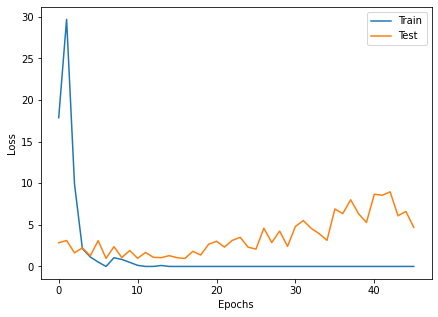

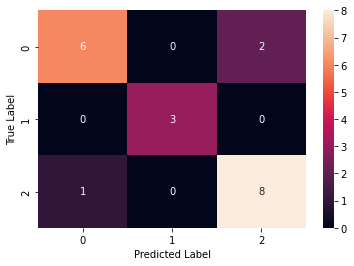

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:16.20100458463033, Test Loss: 1.275117039680481
Epoch 2-- Train Loss:33.83494631449381, Test Loss: 4.422520637512207
Epoch 3-- Train Loss:14.501381874084473, Test Loss: 2.074530601501465
Epoch 4-- Train Loss:8.49146819114685, Test Loss: 3.873429298400879
Epoch 5-- Train Loss:4.842543443044026, Test Loss: 1.502851128578186
Epoch 6-- Train Loss:2.056067864100138, Test Loss: 2.2065646648406982
Epoch 7-- Train Loss:0.8117605050404867, Test Loss: 2.1347768306732178
Epoch 8-- Train Loss:0.09250271320343018, Test Loss: 2.674555540084839
Epoch 9-- Train Loss:0.14861083509579961, Test Loss: 1.9963560104370117
Epoch 10-- Train Loss:2.7395430758285027e-05, Test Loss: 5.191285133361816
Epoch 11-- Train Loss:0.008307802287163213, Test Loss: 4.630669593811035
Epoch 12-- Train Loss:0.1519434948762258, Test Loss: 5.060269355773926
Epoch 13-- Train Loss:0.0, Test Loss: 5.039459705352783
E

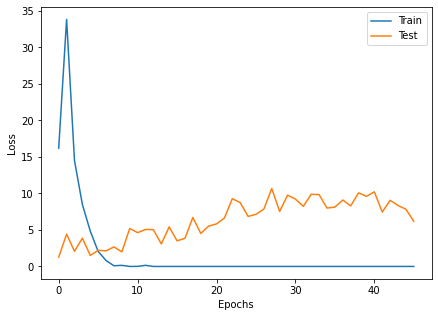

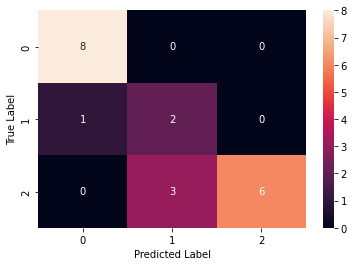

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:13.963509798049927, Test Loss: 6.809237480163574
Epoch 2-- Train Loss:14.23397127787272, Test Loss: 6.181463241577148
Epoch 3-- Train Loss:4.72673495610555, Test Loss: 8.562045097351074
Epoch 4-- Train Loss:3.218739112218221, Test Loss: 8.086441040039062
Epoch 5-- Train Loss:1.5661748498678207, Test Loss: 8.562093734741211
Epoch 6-- Train Loss:1.883400797843933, Test Loss: 7.594674587249756
Epoch 7-- Train Loss:0.3031221230824788, Test Loss: 8.847107887268066
Epoch 8-- Train Loss:1.2767700056234996, Test Loss: 8.493173599243164
Epoch 9-- Train Loss:0.49189873749370844, Test Loss: 9.650738716125488
Epoch 10-- Train Loss:0.3217510633985512, Test Loss: 8.781661987304688
Epoch 11-- Train Loss:0.16607492547458, Test Loss: 9.498565673828125
Epoch 12-- Train Loss:0.0, Test Loss: 9.563682556152344
Epoch 13-- Train Loss:0.0, Test Loss: 10.369810104370117
Epoch 14-- Train Loss:2.75

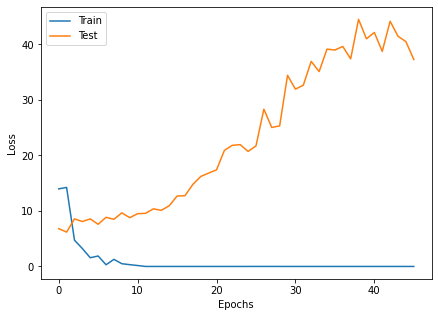

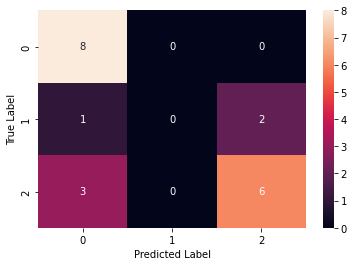

Starting testing
Training Complete
{'0': {'f1-score': '0.816±0.083',
       'precision': '0.803±0.084',
       'recall': '0.85±0.146',
       'support': 8},
 '1': {'f1-score': '0.621±0.351',
       'precision': '0.6±0.379',
       'recall': '0.683±0.367',
       'support': 4},
 '2': {'f1-score': '0.806±0.064',
       'precision': '0.856±0.118',
       'recall': '0.782±0.122',
       'support': 9},
 'accuracy': '0.793±0.051',
 'macro avg': {'f1-score': '0.748±0.128',
               'precision': '0.753±0.144',
               'recall': '0.772±0.115',
               'support': 21},
 'weighted avg': {'f1-score': '0.783±0.076',
                  'precision': '0.799±0.103',
                  'recall': '0.793±0.051',
                  'support': 21}}
{'num_epochs': 26, 'lr': 0.0091, 'batch_size': 4}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:163.6616039815403, Test Loss: 152.18727111816406
Epoch 2-- Train Loss:64.8485437461308, Test Loss:

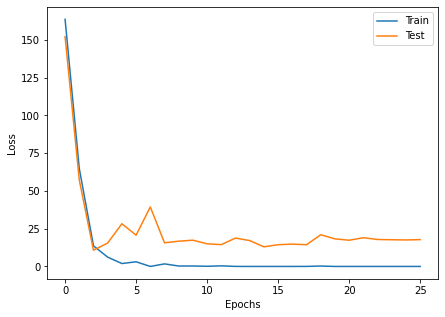

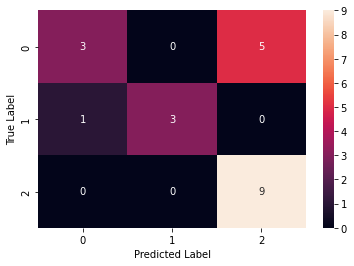

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:181.49570203211454, Test Loss: 97.22332000732422
Epoch 2-- Train Loss:35.02666108097349, Test Loss: 41.80998229980469
Epoch 3-- Train Loss:6.803875598169508, Test Loss: 42.17531967163086
Epoch 4-- Train Loss:7.374957175612678, Test Loss: 3.984243154525757
Epoch 5-- Train Loss:5.142083558163923, Test Loss: 65.37162017822266
Epoch 6-- Train Loss:9.231502489591506, Test Loss: 5.303335666656494
Epoch 7-- Train Loss:1.3528986607459117, Test Loss: 7.733138561248779
Epoch 8-- Train Loss:2.4944353269426847, Test Loss: 6.530637264251709
Epoch 9-- Train Loss:0.7799482153207057, Test Loss: 5.765841960906982
Epoch 10-- Train Loss:0.9091874911843293, Test Loss: 7.139871597290039
Epoch 11-- Train Loss:0.8267975153468913, Test Loss: 1.9862991571426392
Epoch 12-- Train Loss:0.0016959577693515236, Test Loss: 11.649673461914062
Epoch 13-- Train Loss:1.292561570326576e-06, Test Loss: 5.8784

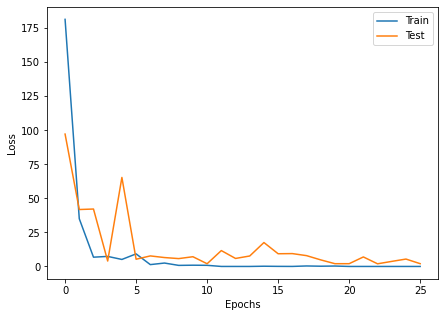

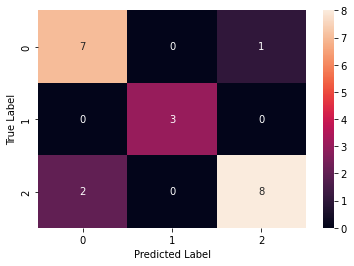

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:198.07475779170082, Test Loss: 62.1602897644043
Epoch 2-- Train Loss:38.580341668356034, Test Loss: 13.81890869140625
Epoch 3-- Train Loss:12.807213824242353, Test Loss: 12.429582595825195
Epoch 4-- Train Loss:6.09421307700021, Test Loss: 5.9705681800842285
Epoch 5-- Train Loss:1.3093825254163, Test Loss: 6.311169624328613
Epoch 6-- Train Loss:2.086411942048628, Test Loss: 4.4028472900390625
Epoch 7-- Train Loss:2.942868190030959, Test Loss: 10.544898986816406
Epoch 8-- Train Loss:2.387138620181542, Test Loss: 5.649247646331787
Epoch 9-- Train Loss:0.8262057511112453, Test Loss: 4.225306034088135
Epoch 10-- Train Loss:0.6509101748811081, Test Loss: 5.554586887359619
Epoch 11-- Train Loss:0.013333797360073806, Test Loss: 4.935115337371826
Epoch 12-- Train Loss:0.46705405146159373, Test Loss: 3.451521635055542
Epoch 13-- Train Loss:9.653738667717941e-08, Test Loss: 2.422297

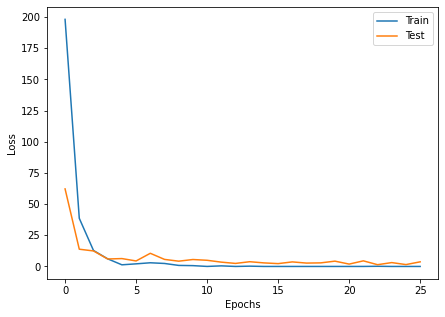

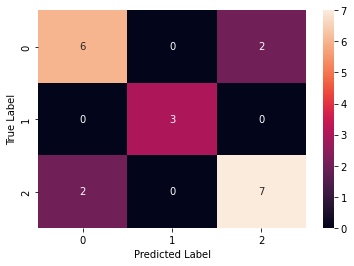

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:157.0127943896112, Test Loss: 16.06228256225586
Epoch 2-- Train Loss:39.85011273828792, Test Loss: 14.632780075073242
Epoch 3-- Train Loss:12.389085203350326, Test Loss: 5.630537986755371
Epoch 4-- Train Loss:2.924717092479682, Test Loss: 12.170236587524414
Epoch 5-- Train Loss:6.471950077945889, Test Loss: 13.452914237976074
Epoch 6-- Train Loss:2.592610618780916, Test Loss: 3.7034549713134766
Epoch 7-- Train Loss:0.5944715049208019, Test Loss: 2.4870333671569824
Epoch 8-- Train Loss:0.8839084923006245, Test Loss: 3.360395908355713
Epoch 9-- Train Loss:0.048013209632353254, Test Loss: 1.4566417932510376
Epoch 10-- Train Loss:0.0003799968134905674, Test Loss: 2.2400710582733154
Epoch 11-- Train Loss:0.33785846418319243, Test Loss: 5.343593597412109
Epoch 12-- Train Loss:0.5513830705278864, Test Loss: 2.0307765007019043
Epoch 13-- Train Loss:9.807423851662005e-05, Test Los

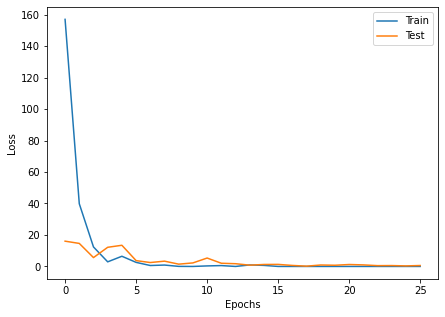

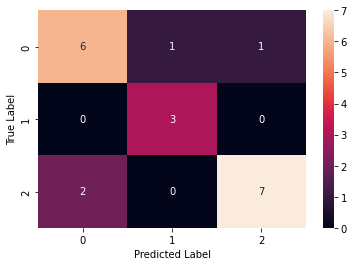

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:168.64261972904205, Test Loss: 432.63836669921875
Epoch 2-- Train Loss:86.44771748497372, Test Loss: 37.531700134277344
Epoch 3-- Train Loss:17.277760928837942, Test Loss: 29.647109985351562
Epoch 4-- Train Loss:4.6587761843942905, Test Loss: 65.9962387084961
Epoch 5-- Train Loss:4.982662500370116, Test Loss: 51.98014450073242
Epoch 6-- Train Loss:3.888624233149347, Test Loss: 37.942596435546875
Epoch 7-- Train Loss:1.997381773392308, Test Loss: 54.0984001159668
Epoch 8-- Train Loss:4.181769143967402, Test Loss: 88.06675720214844
Epoch 9-- Train Loss:0.7451730710052477, Test Loss: 70.46678161621094
Epoch 10-- Train Loss:4.097345524877753e-07, Test Loss: 55.97960662841797
Epoch 11-- Train Loss:9.437601312085809e-07, Test Loss: 65.0250244140625
Epoch 12-- Train Loss:2.004720486833581e-05, Test Loss: 54.384239196777344
Epoch 13-- Train Loss:5.23091936580992e-07, Test Loss: 5

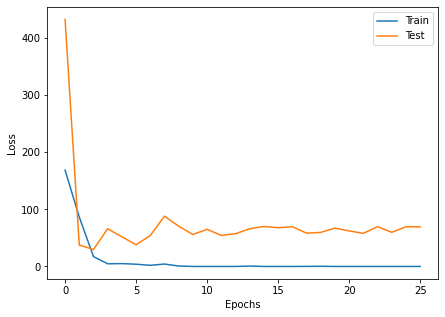

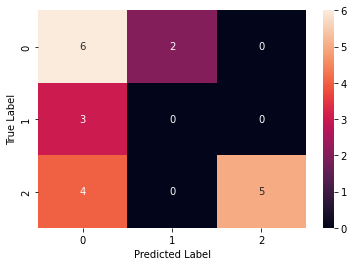

Starting testing
Training Complete
{'0': {'f1-score': '0.74±0.168',
       'precision': '0.788±0.167',
       'recall': '0.75±0.237',
       'support': 8},
 '1': {'f1-score': '0.743±0.377',
       'precision': '0.75±0.387',
       'recall': '0.75±0.387',
       'support': 4},
 '2': {'f1-score': '0.828±0.114',
       'precision': '0.835±0.146',
       'recall': '0.849±0.165',
       'support': 9},
 'accuracy': '0.794±0.145',
 'macro avg': {'f1-score': '0.77±0.2',
               'precision': '0.791±0.202',
               'recall': '0.783±0.195',
               'support': 21},
 'weighted avg': {'f1-score': '0.781±0.157',
                  'precision': '0.807±0.159',
                  'recall': '0.794±0.145',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0061, 'batch_size': 16}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:82.19890974958737, Test Loss: 31.386699676513672
Epoch 2-- Train Loss:27.93747091293335, Test Loss: 1

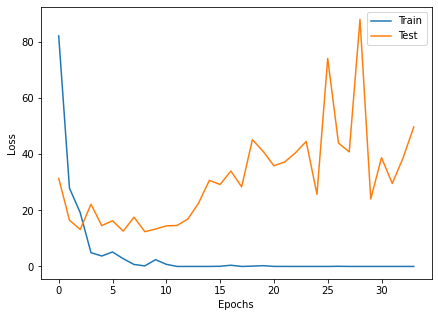

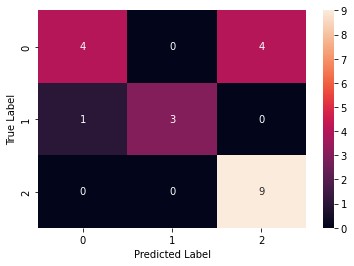

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:95.68704382578532, Test Loss: 35.94748306274414
Epoch 2-- Train Loss:57.385951360066734, Test Loss: 27.913280487060547
Epoch 3-- Train Loss:23.056965351104736, Test Loss: 18.921796798706055
Epoch 4-- Train Loss:40.96852199236552, Test Loss: 103.46855163574219
Epoch 5-- Train Loss:211.81278355916342, Test Loss: 71.29295349121094
Epoch 6-- Train Loss:90.7087459564209, Test Loss: 37.18535614013672
Epoch 7-- Train Loss:118.54769961039226, Test Loss: 51.31366729736328
Epoch 8-- Train Loss:37.7295815149943, Test Loss: 39.713375091552734
Epoch 9-- Train Loss:11.280035575230917, Test Loss: 22.349950790405273
Epoch 10-- Train Loss:7.627309123675029, Test Loss: 9.71873664855957
Epoch 11-- Train Loss:2.5449575583140054, Test Loss: 13.634559631347656
Epoch 12-- Train Loss:2.428868429231443, Test Loss: 9.659704208374023
Epoch 13-- Train Loss:0.4043707052866618, Test Loss: 10.297561645

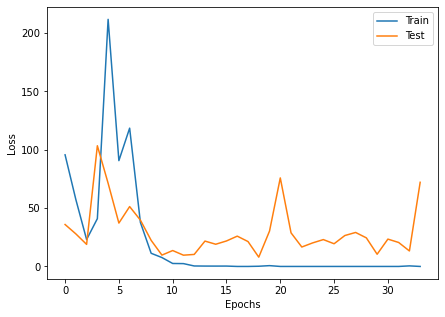

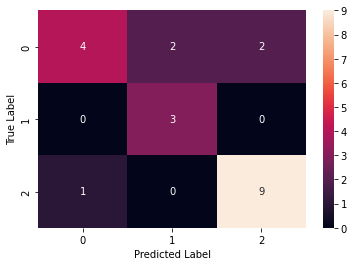

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:92.76363362868626, Test Loss: 36.8746452331543
Epoch 2-- Train Loss:54.771385391553245, Test Loss: 22.821392059326172
Epoch 3-- Train Loss:20.208733631977037, Test Loss: 5.955463886260986
Epoch 4-- Train Loss:1.5399407545725505, Test Loss: 11.252862930297852
Epoch 5-- Train Loss:13.357186019420624, Test Loss: 5.834885597229004
Epoch 6-- Train Loss:6.014381845792134, Test Loss: 7.755879878997803
Epoch 7-- Train Loss:0.7020300501266851, Test Loss: 9.370123863220215
Epoch 8-- Train Loss:1.7395160284724984, Test Loss: 7.360280990600586
Epoch 9-- Train Loss:0.0956601410800922, Test Loss: 11.514090538024902
Epoch 10-- Train Loss:0.03719000243419638, Test Loss: 13.271356582641602
Epoch 11-- Train Loss:0.6861371556993087, Test Loss: 13.52279281616211
Epoch 12-- Train Loss:2.8120250896026846, Test Loss: 7.7109575271606445
Epoch 13-- Train Loss:0.0, Test Loss: 6.688241481781006
Epo

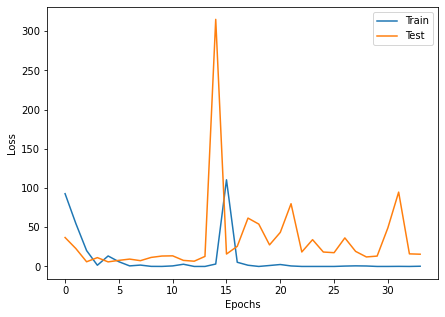

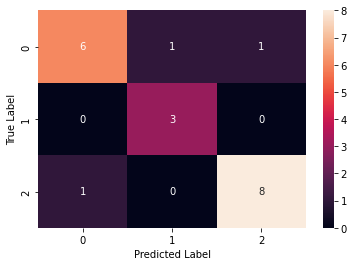

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:83.31515735387802, Test Loss: 23.147300720214844
Epoch 2-- Train Loss:194.91776021321616, Test Loss: 42.178428649902344
Epoch 3-- Train Loss:77.13883384068806, Test Loss: 96.64419555664062
Epoch 4-- Train Loss:88.54403718312581, Test Loss: 29.841758728027344
Epoch 5-- Train Loss:33.87074374842147, Test Loss: 45.86351013183594
Epoch 6-- Train Loss:8.698593365338942, Test Loss: 15.441625595092773
Epoch 7-- Train Loss:4.357461889584859, Test Loss: 15.933706283569336
Epoch 8-- Train Loss:1.3909348733969011, Test Loss: 5.431209564208984
Epoch 9-- Train Loss:0.12356369694073994, Test Loss: 6.9098076820373535
Epoch 10-- Train Loss:0.33848016218164884, Test Loss: 23.619033813476562
Epoch 11-- Train Loss:0.0, Test Loss: 45.5467643737793
Epoch 12-- Train Loss:0.0, Test Loss: 6.096789836883545
Epoch 13-- Train Loss:0.13819295167922974, Test Loss: 37.19487762451172
Epoch 14-- Train L

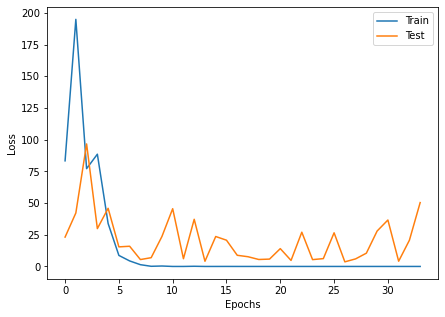

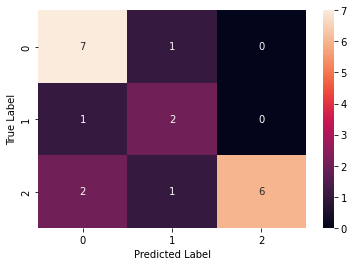

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:89.59045495589574, Test Loss: 16.571231842041016
Epoch 2-- Train Loss:37.36891051133474, Test Loss: 84.4789047241211
Epoch 3-- Train Loss:25.90883543093999, Test Loss: 44.38582229614258
Epoch 4-- Train Loss:30.852723280588787, Test Loss: 61.30779266357422
Epoch 5-- Train Loss:15.004357547280227, Test Loss: 41.35272979736328
Epoch 6-- Train Loss:6.090123434861501, Test Loss: 28.752220153808594
Epoch 7-- Train Loss:0.8932802677154541, Test Loss: 48.28065490722656
Epoch 8-- Train Loss:8.122309736791067e-06, Test Loss: 68.76933288574219
Epoch 9-- Train Loss:1.3893680401142803, Test Loss: 77.04341125488281
Epoch 10-- Train Loss:0.0, Test Loss: 48.48884201049805
Epoch 11-- Train Loss:0.0, Test Loss: 83.87907409667969
Epoch 12-- Train Loss:0.0, Test Loss: 159.05471801757812
Epoch 13-- Train Loss:3.405906697114309, Test Loss: 87.37335968017578
Epoch 14-- Train Loss:0.095763795621

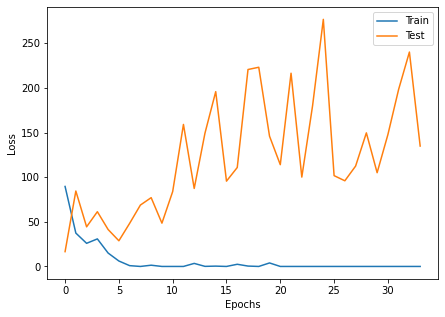

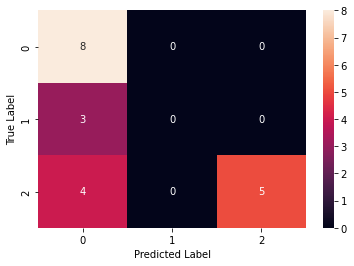

Starting testing
Training Complete
{'0': {'f1-score': '0.714±0.093',
       'precision': '0.744±0.113',
       'recall': '0.75±0.224',
       'support': 8},
 '1': {'f1-score': '0.693±0.355',
       'precision': '0.67±0.368',
       'recall': '0.75±0.387',
       'support': 4},
 '2': {'f1-score': '0.816±0.059',
       'precision': '0.88±0.117',
       'recall': '0.802±0.165',
       'support': 9},
 'accuracy': '0.775±0.074',
 'macro avg': {'f1-score': '0.741±0.145',
               'precision': '0.764±0.138',
               'recall': '0.767±0.135',
               'support': 21},
 'weighted avg': {'f1-score': '0.759±0.091',
                  'precision': '0.796±0.078',
                  'recall': '0.775±0.074',
                  'support': 21}}
{'num_epochs': 34, 'lr': 0.0021, 'batch_size': 8}
FOLD 0
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:54.264472072774716, Test Loss: 15.138416290283203
Epoch 2-- Train Loss:30.996405254710805, Test Los

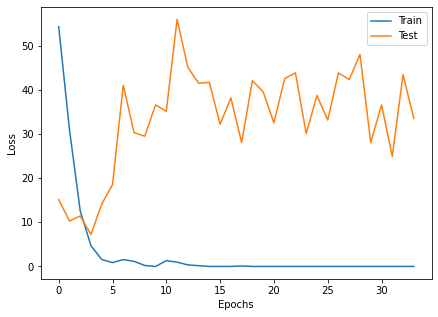

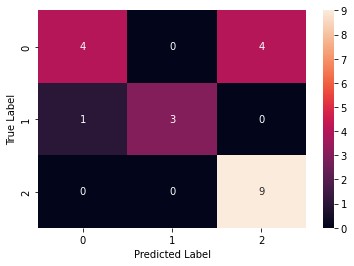

Starting testing
FOLD 1
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:59.26134738055143, Test Loss: 24.998743057250977
Epoch 2-- Train Loss:20.395724310116336, Test Loss: 18.766559600830078
Epoch 3-- Train Loss:12.225920568812978, Test Loss: 10.625046730041504
Epoch 4-- Train Loss:10.3900337797458, Test Loss: 10.233397483825684
Epoch 5-- Train Loss:0.63957833701914, Test Loss: 5.468387603759766
Epoch 6-- Train Loss:2.2591844472018154, Test Loss: 10.34920597076416
Epoch 7-- Train Loss:10.150824455131607, Test Loss: 7.580130100250244
Epoch 8-- Train Loss:1.5589350017486472, Test Loss: 4.59045934677124
Epoch 9-- Train Loss:8.46505981171495, Test Loss: 4.704815864562988
Epoch 10-- Train Loss:0.925471999428489, Test Loss: 11.660197257995605
Epoch 11-- Train Loss:0.3048901035042284, Test Loss: 9.446171760559082
Epoch 12-- Train Loss:1.8049644991564988e-06, Test Loss: 5.435293197631836
Epoch 13-- Train Loss:0.0, Test Loss: 8.098816871643066
Epoch 

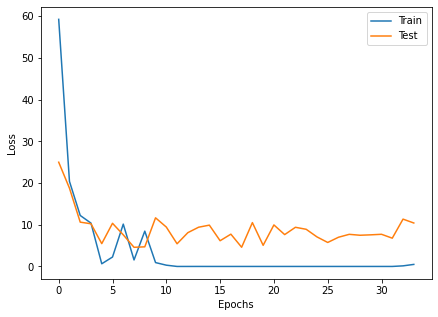

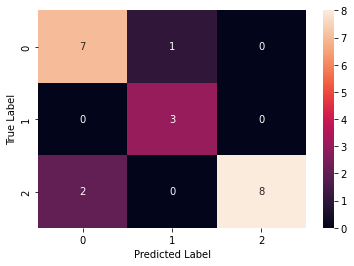

Starting testing
FOLD 2
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:60.11924700303511, Test Loss: 10.504624366760254
Epoch 2-- Train Loss:41.57573465867476, Test Loss: 13.685330390930176
Epoch 3-- Train Loss:4.71856908864257, Test Loss: 6.932512283325195
Epoch 4-- Train Loss:4.3763135649602525, Test Loss: 9.066363334655762
Epoch 5-- Train Loss:13.20746456601377, Test Loss: 12.930277824401855
Epoch 6-- Train Loss:11.771637119125232, Test Loss: 10.271306037902832
Epoch 7-- Train Loss:0.23313532850017343, Test Loss: 15.411284446716309
Epoch 8-- Train Loss:0.7926130557245327, Test Loss: 16.735549926757812
Epoch 9-- Train Loss:0.0, Test Loss: 11.00057315826416
Epoch 10-- Train Loss:0.5421880525443715, Test Loss: 24.41529655456543
Epoch 11-- Train Loss:3.0343365769022057, Test Loss: 13.6376314163208
Epoch 12-- Train Loss:0.026219175620512528, Test Loss: 12.546883583068848
Epoch 13-- Train Loss:0.0, Test Loss: 9.74084758758545
Epoch 14-- Train L

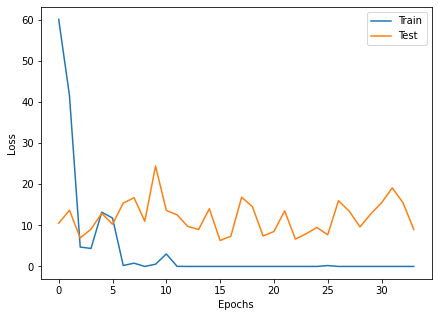

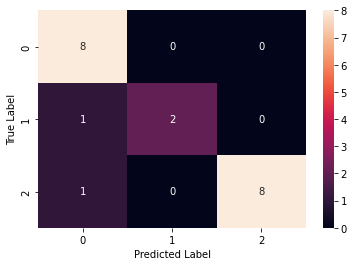

Starting testing
FOLD 3
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:63.49234674193642, Test Loss: 4.981496810913086
Epoch 2-- Train Loss:12.644752308641644, Test Loss: 8.389638900756836
Epoch 3-- Train Loss:23.02587979490107, Test Loss: 18.612974166870117
Epoch 4-- Train Loss:11.947597761502088, Test Loss: 7.227817535400391
Epoch 5-- Train Loss:3.284758041262235, Test Loss: 9.769360542297363
Epoch 6-- Train Loss:0.9731249820099741, Test Loss: 9.959485054016113
Epoch 7-- Train Loss:0.3728078712116588, Test Loss: 8.988734245300293
Epoch 8-- Train Loss:0.6843005445870486, Test Loss: 12.132492065429688
Epoch 9-- Train Loss:2.513767363460927, Test Loss: 46.32099533081055
Epoch 10-- Train Loss:20.338317258706823, Test Loss: 93.61446380615234
Epoch 11-- Train Loss:21.107484703714196, Test Loss: 37.8338508605957
Epoch 12-- Train Loss:3.1210981423487696, Test Loss: 19.563594818115234
Epoch 13-- Train Loss:10.502009521831166, Test Loss: 39.72937011

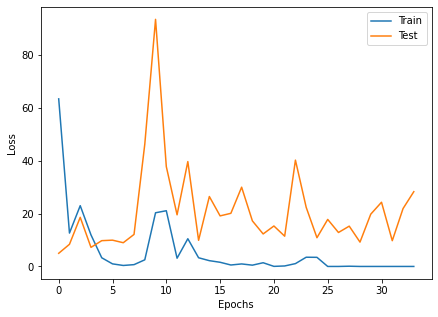

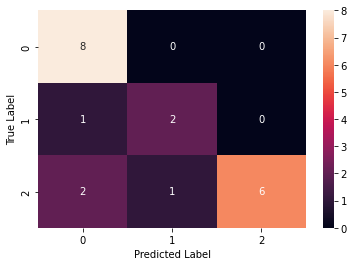

Starting testing
FOLD 4
--------------------------------
Paramatric Scattering Network Created
Epoch 1-- Train Loss:31.69055199623108, Test Loss: 15.91979694366455
Epoch 2-- Train Loss:23.499697078358043, Test Loss: 19.59285545349121
Epoch 3-- Train Loss:16.550357805057004, Test Loss: 16.34307098388672
Epoch 4-- Train Loss:21.447778181596235, Test Loss: 29.324888229370117
Epoch 5-- Train Loss:5.385913297382437, Test Loss: 37.29642868041992
Epoch 6-- Train Loss:7.4713757029722645, Test Loss: 47.77830123901367
Epoch 7-- Train Loss:0.03923435758654715, Test Loss: 60.41035461425781
Epoch 8-- Train Loss:1.0330604709452018e-06, Test Loss: 76.35279083251953
Epoch 9-- Train Loss:0.0, Test Loss: 106.8384017944336
Epoch 10-- Train Loss:2.2293367444283582e-05, Test Loss: 86.96634674072266
Epoch 11-- Train Loss:0.0, Test Loss: 98.95980072021484
Epoch 12-- Train Loss:0.0034228895198215137, Test Loss: 143.4684600830078
Epoch 13-- Train Loss:0.0, Test Loss: 97.88143157958984
Epoch 14-- Train Loss:0.0

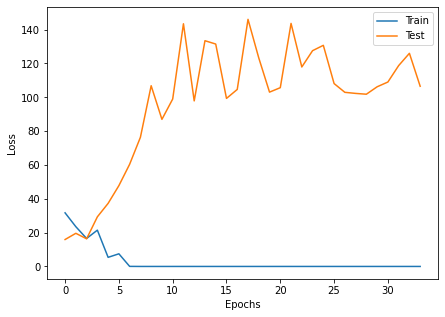

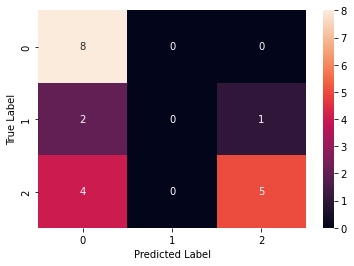

Starting testing
Training Complete
{'0': {'f1-score': '0.77±0.088',
       'precision': '0.721±0.08',
       'recall': '0.875±0.194',
       'support': 8},
 '1': {'f1-score': '0.663±0.332',
       'precision': '0.75±0.387',
       'recall': '0.617±0.332',
       'support': 4},
 '2': {'f1-score': '0.825±0.083',
       'precision': '0.905±0.124',
       'recall': '0.782±0.141',
       'support': 9},
 'accuracy': '0.794±0.08',
 'macro avg': {'f1-score': '0.753±0.147',
               'precision': '0.792±0.165',
               'recall': '0.758±0.128',
               'support': 21},
 'weighted avg': {'f1-score': '0.78±0.103',
                  'precision': '0.811±0.11',
                  'recall': '0.794±0.08',
                  'support': 21}}


In [23]:
name ='scattering'
for hparam_dict in hparam_list:
    print(hparam_dict)
    results = train_model(name=name, dataset=dataset, k_folds =5, device=device, **hparam_dict)
    report = get_avg_classification_report(results, k_folds =5)
    pprint(report)
    save_metrics_mlflow(name, report, results )